# Inner Core Lightning Threshold Analysis
In this notebook, we define the threshold for what constitutes a "lightning burst" in the inner core of a tropical cyclone. 

### How do we define a burst of lightning?
We define a lightning burst based off the number of lightning instances in a 30-minute time bin.
We start by assuming the distribution of lightning in the inner core is Gaussian.

*We look at each basin separately. Below are the basin codes:
* ATL - Atlantic Ocean basin
* CPAC - 
* EPAC - Eastern Pacific basin
* IO - Indian Ocean basin
* SHEM - Southern Hemisphere basin
* WPAC - Western North Pacific basin

## Code
### Import Libraries and Files
Let's start by importing necessary libraries and files. The inner core dataset is created in the `data_processing.ipynb` notebook as `innercore_timebin_joined.csv`.

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import median_abs_deviation
import matplotlib.patches as mpatches

In [2]:
# import data from csv file
innercore_data = pl.read_csv("data_pipeline/innercore_timebin_joined.csv")
innercore_data = innercore_data.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin"),
    pl.col("storm_code").str.extract(r"^(.*?)_", 1).alias("basin"),
    pl.col("lightning_count").log1p().alias("log_lightning_count"),
    pl.when(pl.col("pressure") == 0)
    .then(None)  # Replace 0 with None -> 0 is not possible, treat these as null but don't remove row bc the wind speed value is valid
    .otherwise(pl.col("pressure"))
    .alias("pressure")  # Keep the column name as "pressure"
)
innercore_data = innercore_data.with_columns(
    pl.when(pl.col("TC_Category") == "Unidentified")
    .then(pl.lit("0")) # Replace "unidentified" with 0 for current category
    .otherwise(pl.col("TC_Category"))
    .alias("TC_Category")
)
innercore_data = innercore_data.rename({"Intensification_Category":"Intensification_Category_5", "TC_Category":"Current_Category"})
innercore_data.head()

shape: (5, 21)
┌────────────┬────────────┬────────────┬──────┬───┬────────────┬───────────┬───────────┬───────────┐
│ time_bin   ┆ storm_code ┆ lightning_ ┆ year ┆ … ┆ 24_hour_pr ┆ Current_C ┆ Intensifi ┆ log_light │
│ ---        ┆ ---        ┆ count      ┆ ---  ┆   ┆ essure_dif ┆ ategory   ┆ cation_Ca ┆ ning_coun │
│ datetime[μ ┆ str        ┆ ---        ┆ i64  ┆   ┆ f          ┆ ---       ┆ tegory_5  ┆ t         │
│ s]         ┆            ┆ i64        ┆      ┆   ┆ ---        ┆ str       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆      ┆   ┆ f64        ┆           ┆ str       ┆ f64       │
╞════════════╪════════════╪════════════╪══════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 2010-06-21 ┆ ATL_10_1   ┆ 1          ┆ 2010 ┆ … ┆ -1.0       ┆ 0         ┆ Neutral   ┆ 0.693147  │
│ 07:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ -1.0       ┆ 0         ┆ Neutral   ┆ 0.0       │
│ 07:30:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ -1.0       ┆ 0         ┆ Neutral   ┆ 0.0       │
│ 08:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ -1.0       ┆ 0         ┆ Neutral   ┆ 0.0       │
│ 08:30:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ -1.0       ┆ 0         ┆ Neutral   ┆ 0.0       │
│ 09:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴──────┴───┴────────────┴───────────┴───────────┴───────────┘

We map the intensification bins into 3, combining the rapidly weakening and weakening bins, and the rapidly intensifying and intensifying bins.

In [3]:
# Mapping intensification bins into 3 category instead of 5
category_mapping = {
    "Rapidly Weakening": "Weakening",
    "Weakening": "Weakening",
    "Neutral": "Neutral",
    "Intensifying": "Intensifying",
    "Rapidly Intensifying": "Intensifying"
}

# Apply mapping to create new column
innercore_data = innercore_data.with_columns(
    innercore_data["Intensification_Category_5"].replace(category_mapping).alias("Intensification_Category_3")
)

innercore_data.head()

shape: (5, 22)
┌────────────┬────────────┬────────────┬──────┬───┬────────────┬───────────┬───────────┬───────────┐
│ time_bin   ┆ storm_code ┆ lightning_ ┆ year ┆ … ┆ Current_Ca ┆ Intensifi ┆ log_light ┆ Intensifi │
│ ---        ┆ ---        ┆ count      ┆ ---  ┆   ┆ tegory     ┆ cation_Ca ┆ ning_coun ┆ cation_Ca │
│ datetime[μ ┆ str        ┆ ---        ┆ i64  ┆   ┆ ---        ┆ tegory_5  ┆ t         ┆ tegory_3  │
│ s]         ┆            ┆ i64        ┆      ┆   ┆ str        ┆ ---       ┆ ---       ┆ ---       │
│            ┆            ┆            ┆      ┆   ┆            ┆ str       ┆ f64       ┆ str       │
╞════════════╪════════════╪════════════╪══════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 2010-06-21 ┆ ATL_10_1   ┆ 1          ┆ 2010 ┆ … ┆ 0          ┆ Neutral   ┆ 0.693147  ┆ Neutral   │
│ 07:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ 0          ┆ Neutral   ┆ 0.0       ┆ Neutral   │
│ 07:30:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ 0          ┆ Neutral   ┆ 0.0       ┆ Neutral   │
│ 08:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ 0          ┆ Neutral   ┆ 0.0       ┆ Neutral   │
│ 08:30:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
│ 2010-06-21 ┆ ATL_10_1   ┆ 0          ┆ 2010 ┆ … ┆ 0          ┆ Neutral   ┆ 0.0       ┆ Neutral   │
│ 09:00:00   ┆            ┆            ┆      ┆   ┆            ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴──────┴───┴────────────┴───────────┴───────────┴───────────┘

In [4]:
# Create dataframe for filtering later
storm_names = innercore_data[["storm_code", "storm_name"]].unique()

### Functions

Below are the functions used to evaluate 6 different lightning burst thresholds at the individual TC level. We compare each TC's lightning to itself to identify a burst using the IQR, MAD, and Lognormal methods. The thresholds defined by each of these functions act as a standard for a lightning burst for that TC. If the count in the bin is more than the threshold, we mark it as a lightning burst. Note that we use log-transformed lightning counts in this analysis. We do not include data associated with current wind speeds less than 40 knots in this threshold analysis. 

We also create functions to apply the thresholds and aggregate results, as well as functions used to plot individual TCs for analysis.

In [5]:
# IQR threshold function
def detect_bursts_iqr(group):
    Q1 = group['log_lightning_count'].quantile(0.25)
    Q3 = group['log_lightning_count'].quantile(0.75)
    IQR = Q3 - Q1

    # Set burst threshold for each cyclone individually
    threshold1 = Q3 + 1 * IQR
    threshold2 = Q3 + 1.5* IQR

    # Mark bursts specific to the cyclone
    group['burst_iqr1'] = group['log_lightning_count'] > threshold1
    group['burst_iqr2'] = group['log_lightning_count'] > threshold2
    group['iqr1_threshold'] = threshold1
    group['iqr2_threshold'] = threshold2
    return group

In [6]:
# MAD threshold function
def detect_bursts_mad(group):
    median_log = group['log_lightning_count'].median()
    mad_log = median_abs_deviation(group['log_lightning_count'])

    # Set burst threshold based on MAD for each cyclone
    threshold1 = median_log + 4 * mad_log
    threshold2 = median_log + 5 * mad_log

    # Mark bursts specific to the cyclone
    group['burst_mad1'] = group['log_lightning_count'] > threshold1
    group['burst_mad2'] = group['log_lightning_count'] > threshold2
    group['mad1_threshold'] = threshold1
    group['mad2_threshold'] = threshold2
    return group

In [7]:
# Log normal threshold function
def detect_bursts_lognormal(group):
     # Calculate the mean and standard deviation of the log-transformed lightning count
    mean_log = group['log_lightning_count'].mean()
    std_log = group['log_lightning_count'].std()

    # Set burst thresholds based on log-normal distribution (mean + 2σ and mean + 3σ)
    threshold1 = mean_log + 2 * std_log
    threshold2 = mean_log + 3 * std_log

    # Mark bursts specific to the cyclone
    group['burst_logn1'] = group['log_lightning_count'] > threshold1
    group['burst_logn2'] = group['log_lightning_count'] > threshold2
    group['logn1_threshold'] = threshold1
    group['logn2_threshold'] = threshold2
    return group

In [8]:
# Function to apply the 3 methods, 6 thresholds for individual TCs
def apply_individual_thresholds(df):
    processed = df.groupby(["storm_code"]).apply(detect_bursts_iqr)
    processed.reset_index(drop=True, inplace=True)
    processed = processed.groupby(["storm_code"]).apply(detect_bursts_mad)
    processed.reset_index(drop=True, inplace=True)
    processed = processed.groupby(["storm_code"]).apply(detect_bursts_lognormal)
    processed.reset_index(drop=True, inplace=True)
    # Reset index to keep data points in chronological order
    processed.sort_values(by=["storm_code", "time_bin"], inplace=True)
    processed.reset_index(drop=True, inplace=True)
    return processed

In [17]:
# Function used to aggregate results dataframe
def create_agg_result(processed):
    agg_result = processed.groupby(["storm_code"]).agg(
        mad1_bursts=('burst_mad1', 'sum'),
        mad2_bursts=('burst_mad2', 'sum'),
        mad1_threshold=('mad1_threshold', 'max'),
        mad2_threshold=('mad2_threshold', 'max'),
        iqr1_bursts=('burst_iqr1', 'sum'),
        iqr2_bursts=('burst_iqr2', 'sum'),
        iqr1_threshold=('iqr1_threshold', 'max'),
        iqr2_threshold=('iqr2_threshold', 'max'),
        logn1_bursts=('burst_logn1', 'sum'),
        logn2_bursts=('burst_logn2', 'sum'),
        logn1_threshold=('logn1_threshold', 'max'),
        logn2_threshold=('logn2_threshold', 'max'),
        total_bins=('storm_code', 'count')
    )
    agg_result.reset_index(drop=False, inplace=True)
    agg_result.head(10)

    agg_result["mad1_prop"] = round((agg_result["mad1_bursts"]/agg_result["total_bins"])*100, 2)
    agg_result["mad2_prop"] = round((agg_result["mad2_bursts"]/agg_result["total_bins"])*100, 2)
    agg_result["iqr1_prop"] = round((agg_result["iqr1_bursts"]/agg_result["total_bins"])*100, 2)
    agg_result["iqr2_prop"] = round((agg_result["iqr2_bursts"]/agg_result["total_bins"])*100, 2)
    agg_result["logn1_prop"] = round((agg_result["logn1_bursts"]/agg_result["total_bins"])*100, 2)
    agg_result["logn2_prop"] = round((agg_result["logn2_bursts"]/agg_result["total_bins"])*100, 2)
    return agg_result

In [10]:
def add_bg_colors(ax, lightning_data, color_type):
    """
    Adds background shading based on either the 'Intensification_Category_3' column or 'Current_Category' column.

    Parameters:
    - ax: The matplotlib axis to plot on.
    - lightning_data: DataFrame with 'time_bin', 'Intensification_Category_3', and 'Current_Category'
    - color_type: toggle between coloring by intensification change category or current category, can only take i3, i5, c5 as values
    """
    # Define color mapping
    i3_colors = {
        "Intensifying": "#FFEE8C",
        "Neutral": "lightgreen",
        "Weakening": "lightblue",
        "Unidentified":"white"
    }
    i5_colors = {
        "Rapidly Intensifying": "#f6aeae",
        "Intensifying": "#FFEE8C",
        "Neutral": "lightgreen",
        "Weakening": "lightblue",
        "Rapidly Weakening": "#dab1da",
        "Unidentified":"white"
    }
    c5_colors = {
        "0":'white',
        "1":'#FFEE8C',
        "2":'lightgreen',
        "3":'lightblue',
        "4":'#dab1da',
        "5":'pink'
    }

    # Define color_type toggle
    color_type_toggle = {
        "i3":["Intensification_Category_3", i3_colors],
        "i5":["Intensification_Category_5", i5_colors],
        "c5":["Current_Category", c5_colors]
    }
    # Exit if inputted color type is not valid
    if color_type not in color_type_toggle.keys():
        return(print(f"Not a valid background color type. Choose either: {', '.join(color_type_toggle.keys())}"))

    category_colors = color_type_toggle[color_type][1]
    column_name = color_type_toggle[color_type][0]
    for i in range(len(lightning_data) - 1):
        category = lightning_data[column_name].iloc[i]
        color = category_colors.get(category, "red")  # Default to red if not found - flag this as an error

        ax.axvspan(lightning_data['time_bin'].iloc[i],
                   lightning_data['time_bin'].iloc[i + 1],
                   color=color, alpha=0.3)

    # Create custom legend patches
    legend_patches = [mpatches.Patch(color=c, label=cat) for cat, c in category_colors.items()]
    return legend_patches  # Return legend handles

In [23]:
# Function to plot an individual TC with intensification in the background
def plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, bg_type):
    cyclone_name = storm_names.filter(pl.col("storm_code") == cyclone_id)["storm_name"].item()
    df_cyclone = processed[processed['storm_code'] == cyclone_id]
    lightning_data = innercore_data.filter(pl.col("storm_code") == cyclone_id).to_pandas()

    plt.figure(figsize=(10, 5))

    # Create first y-axis for lightning
    fig, ax1 = plt.subplots(figsize=(14, 8))

    ax1.plot(lightning_data['time_bin'], lightning_data['lightning_count'], label='Lightning Count', color='gray')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Lightning Count", color="gray")
    ax1.tick_params(axis='y', labelcolor="gray")

    # Create second y-axis for pressure
    ax2 = ax1.twinx()
    ax2.plot(lightning_data['time_bin'], lightning_data['pressure'], label='Pressure', color='orange')
    ax2.set_ylabel("Pressure", color="orange")
    ax2.tick_params(axis='y', labelcolor="orange")

    # Create third y-axis for wind knot
    ax2 = ax1.twinx()
    ax2.plot(lightning_data['time_bin'], lightning_data['knots'], label='Wind', color='blue')
    ax2.set_ylabel("Wind", color="blue")
    ax2.tick_params(axis='y', labelcolor="blue")

    # Call bg colors function
    legend_patches = add_bg_colors(ax1, lightning_data, bg_type)

    # Mark bursts detected by MAD
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad1']],
                df_cyclone['lightning_count'][df_cyclone['burst_mad1']],
                color='red', label='MAD Detected Burst -threshold1', s=50, marker='o', alpha=0.7)
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_mad2']],
                df_cyclone['lightning_count'][df_cyclone['burst_mad2']],
                color='yellow', label='MAD Detected Burst - threshold2', s=50, marker='o', alpha=0.7)

    # Mark bursts detected by IQR
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr1']],
                df_cyclone['lightning_count'][df_cyclone['burst_iqr1']],
                color='blue', label='IQR Detected Burst - threshold1', s=50, marker='x', alpha=0.7)
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_iqr2']],
                df_cyclone['lightning_count'][df_cyclone['burst_iqr2']],
                color='green', label='IQR Detected Burst - threshold2', s=50, marker='x', alpha=0.7)

    # Mark bursts detected by lognormal threshold
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_logn1']],
                df_cyclone['lightning_count'][df_cyclone['burst_logn1']],
                color='purple', label='Lognormal Detected Burst - 2 sigma', s=50, marker='^', alpha=0.7)
    ax1.scatter(df_cyclone['time_bin'][df_cyclone['burst_logn2']],
                df_cyclone['lightning_count'][df_cyclone['burst_logn2']],
                color='orange', label='Lognormal Detected Burst - 3 sigma', s=50, marker='^', alpha=0.7)

    plt.xlabel('Time')
    plt.title(f'Lightning Burst Detection for {cyclone_name} ({cyclone_id})')
    ax1.legend(loc='upper left')
    ax2.legend(handles=legend_patches, loc='center left')
    plt.xticks(visible=False)
    plt.grid()
    plt.show()

In [140]:
def group_bins_category(dataset):
    # split bins into 0-2, 1-2, and 3-5 categories - return 3 datasets
    weak_cat = ["0", "1", "2"]
    weak_cat_alt = ["1", "2"]
    strong_cat = ["3", "4", "5"]

    # separate the 2 category groupings
    weak_cat_lightning = dataset[dataset["Current_Category"].isin(weak_cat)]
    print(f"{len(weak_cat_lightning)} non-zero lightning count timebins associated with category {min(weak_cat)}-{max(weak_cat)} wind speeds in EPAC basin.")

    weak_cat_lightning_alt = dataset[dataset["Current_Category"].isin(weak_cat_alt)]
    print(f"{len(weak_cat_lightning_alt)} non-zero lightning count timebins associated with category {min(weak_cat_alt)}-{max(weak_cat_alt)} wind speeds in EPAC basin.")

    strong_cat_lightning = dataset[dataset["Current_Category"].isin(strong_cat)]
    print(f"{len(strong_cat_lightning)} non-zero lightning count timebins associated with category {min(strong_cat)}-{max(strong_cat)} wind speeds in EPAC basin.")

    return weak_cat_lightning, weak_cat_lightning_alt, strong_cat_lightning

In [226]:
def plot_threshold_histogram(dataset, threshold_type, ax=None):
    if ax is None: # enable plotting multiple in a grid if ax passed in
        fig, ax = plt.subplots()
    threshold_names = {
        'mad1':['mad1_threshold','MAD1'],
        'mad2':['mad2_threshold','MAD2'],
        'iqr1':['iqr1_threshold','IQR1'],
        'iqr2':['iqr2_threshold','IQR2'],
        'logn1':['logn1_threshold','Lognormal 2 Sigma'],
        'logn2':['logn2_threshold','Lognormal 3 Sigma'],
    }
    if ax is None:
        fig, ax = plt.subplots()
    plot_data = dataset[threshold_names[threshold_type][0]]
    if plot_data is None or len(plot_data) == 0 or sum(plot_data.isnull()) == len(plot_data):  # Check if data is empty
        ax.text(0.5, 0.5, "No Data Available", fontsize=12, ha='center', va='center')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xticks([])  # Hide x-axis ticks
        ax.set_yticks([])  # Hide y-axis ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(f"Histogram of {threshold_names[threshold_type][1]} Burst Threshold")
    else:
        ax.hist(plot_data, bins=20, edgecolor="black", align="left")
        ax.set_xlabel("Lightning Burst Threshold (Log10 Scale)")
        ax.set_ylabel("Frequency")
        ax.set_title(f"Histogram of {threshold_names[threshold_type][1]} Burst Threshold")

In [82]:
def plot_threshold_boxplot(dataset, category_group, ax=None):
    plt.figure(figsize=(10, 6))
    plt.boxplot([dataset['mad1_threshold'], dataset['mad2_threshold'], dataset['iqr1_threshold'],
                dataset['iqr2_threshold'], dataset['logn1_threshold'], dataset['logn2_threshold']]
                , labels=['MAD1', 'MAD2', 'IQR1', 'IQR2', 'LOGN1', 'LOGN2'],
                patch_artist=True, boxprops=dict(facecolor='lightgreen'))

    plt.title(f'Threshold Value Comparison - {category_group}')
    plt.ylabel('Values')

    plt.show()

In [105]:
def create_burst_summary(dataset):
    threshold_names = {
        'mad1':['mad1_threshold','MAD1'],
        'mad2':['mad2_threshold','MAD2'],
        'iqr1':['iqr1_threshold','IQR1'],
        'iqr2':['iqr2_threshold','IQR2'],
        'logn1':['logn1_threshold','Lognormal 2 Sigma'],
        'logn2':['logn2_threshold','Lognormal 3 Sigma'],
    }
    threshold_keys = list(threshold_names.keys())
    burst_labels = ['burst_iqr1', 'burst_iqr2', 'burst_mad1', 'burst_mad2', 'burst_logn1', 'burst_logn2']
    # Generate burst summary
    burst_summary = {
        "Threshold": threshold_keys,
        "Burst Count": [dataset[b].sum() for b in burst_labels],
        "Timebin Count": [dataset["time_bin"].count() for i in range(len(burst_labels))],
        "Burst Percentage": [round(dataset[b].sum()/dataset["time_bin"].count()*100, 2) for b in burst_labels]
    }
    burst_summary = pd.DataFrame(burst_summary)
    return burst_summary

In [173]:
def create_basin_summary(dataset, category_group, basin):
    valid_categories = ["0-2", "1-2", "3-5", "all"]
    valid_basins = ["ATL", "EPAC", "WPAC", "IO", "SHEM", "CPAC"]
    threshold_names = {
        'mad1':['mad1_threshold','MAD1'],
        'mad2':['mad2_threshold','MAD2'],
        'iqr1':['iqr1_threshold','IQR1'],
        'iqr2':['iqr2_threshold','IQR2'],
        'logn1':['logn1_threshold','Lognormal 2 Sigma'],
        'logn2':['logn2_threshold','Lognormal 3 Sigma'],
    }
    threshold_keys = list(threshold_names.keys())
    threshold_cols = [threshold_names[key][0] for key in threshold_keys]

    # Check for valid input
    if category_group not in valid_categories:
        return(print(f"Not a valid category grouping. Choose either: {', '.join(valid_categories)}"))
    elif basin not in valid_basins:
        return(print(f"Not a valid basin. Choose either: {', '.join(valid_basins)}"))

    burst_summary = create_burst_summary(dataset)

    # Get mean and 2 standard deviations - threshold summary
    threshold_summary = {
        "Basin": [basin for i in range(len(threshold_keys))],
        "Category Group": [category_group for i in range(len(threshold_keys))],
        "Threshold": threshold_keys,
        "Mean": [dataset[col].mean() for col in threshold_cols],
        "Std Dev": [dataset[col].std() for col in threshold_cols],
        "Median": [dataset[col].median() for col in threshold_cols],
        "Min": [dataset[col].min() for col in threshold_cols],
        "Max": [dataset[col].max() for col in threshold_cols],
        "Basin-Category Threshold (Mean-Based)": [dataset[col].mean()+2*dataset[col].std() for col in threshold_cols], # mean + 2 standard deviations
        "Basin-Category Threshold (Median-Based)": [dataset[col].median()+2*dataset[col].std() for col in threshold_cols], # median + 2 standard deviations
    }
    threshold_summary = pd.DataFrame(threshold_summary)
    threshold_summary

    # Join the two dataframes and return
    return pd.merge(threshold_summary, burst_summary, on="Threshold")

In [100]:
def detect_bursts_basin(group, thresholds):

    # Use thresholds passed in as dictionary
    for key, value in thresholds.items():
        threshold = value
        group[f'burst_{key}'] = group['log_lightning_count'] > threshold
        group[f'{key}_threshold'] = threshold

    return group

In [101]:
def apply_basin_thresholds(df, basin_thresholds):
    # drop bins with 0 lightning count
    clean_data = df[df['lightning_count'] != 0]

    processed = clean_data.groupby(["storm_code"]).apply(detect_bursts_basin, thresholds = basin_thresholds)
    processed.reset_index(drop=True, inplace=True)

    processed.sort_values(by=["storm_code", "time_bin"], inplace=True)
    processed.reset_index(drop=True, inplace=True)

    return processed

---------------------

### Individual TC Analysis
We start by applying the 6 different thresholds to each TC individually, where we evaluate burst thresholds in comparison to a TC's own lightning activity for time bins associated with wind speeds greater than or equal to 40 knots. We start by filtering out data associated with wind speeds less than 40 knots.

In [15]:
# Filter out data where wind is less than 40 knots for threshold analysis
analysis_data = innercore_data.filter(pl.col("knots") >= 40)
# Convert polars dataframe to pandas for application of functions
pd_data = analysis_data.to_pandas()

We then apply the functions to the data, including timebins with no lightning activity.

In [301]:
# Apply functions to data, including bins with 0 lightning
processed_w_0 = apply_individual_thresholds(pd_data)

agg_result_w_0 = create_agg_result(processed_w_0)
agg_result_w_0.head(10)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
0   ATL_10_1           40           40        0.000000        0.000000   
1  ATL_10_11           54           54        0.000000        0.000000   
2  ATL_10_12           83           83        0.000000        0.000000   
3  ATL_10_13           43           35        1.732868        2.079442   
4  ATL_10_14           23           23        0.000000        0.000000   
5  ATL_10_17           75           75        0.000000        0.000000   
6  ATL_10_18            0            0        7.791445        9.023858   
7  ATL_10_19           58           58        0.000000        0.000000   
8  ATL_10_20           12            7        3.465736        4.158883   
9  ATL_10_21          100           75        3.465736        4.158883   

   iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
0           40           40        0.000000        0.000000            10   
1           54           54        0.000000        0.000000            25   
2           83           83        0.000000        0.000000            24   
3            6            1        4.552490        5.690612             6   
4           23           23        0.000000        0.000000            15   
5           57           56        1.386294        1.732868            24   
6            0            0        6.425564        7.595410             3   
7            1            0        5.344880        6.681100             6   
8            6            1        4.394449        5.493061             5   
9           35            2        5.545177        6.931472            34   

   logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0             4         1.964998         2.766760         168      23.81   
1            17         0.905833         1.299925         524      10.31   
2            10         2.714949         3.820770         347      23.92   
3             0         4.401910         5.986869         130      33.08   
4             5         1.092380         1.547290         144      15.97   
5             2         3.893827         5.435464         270      27.78   
6             0         5.929778         7.469033         180       0.00   
7             0         4.938227         6.723796         120      48.33   
8             0         4.549465         6.195277          77      15.58   
9             0         5.640493         7.671843         476      21.01   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0      23.81      23.81      23.81        5.95        2.38  
1      10.31      10.31      10.31        4.77        3.24  
2      23.92      23.92      23.92        6.92        2.88  
3      26.92       4.62       0.77        4.62        0.00  
4      15.97      15.97      15.97       10.42        3.47  
5      27.78      21.11      20.74        8.89        0.74  
6       0.00       0.00       0.00        1.67        0.00  
7      48.33       0.83       0.00        5.00        0.00  
8       9.09       7.79       1.30        6.49        0.00  
9      15.76       7.35       0.42        7.14        0.00

In [302]:
# Get mean threshold value for each of the 6 options
agg_result_w_0_mean = agg_result_w_0.drop(columns=("storm_code")).mean()
print(agg_result_w_0_mean[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])
# Get median threshold value for each of the 6 options
agg_result_w_0_median = agg_result_w_0.drop(columns=("storm_code")).median()
print(agg_result_w_0_median[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])

mad1_threshold     1.080206
mad2_threshold     1.289705
iqr1_threshold     2.292736
iqr2_threshold     2.859537
logn1_threshold    3.085677
logn2_threshold    4.239224
dtype: float64
mad1_threshold     0.000000
mad2_threshold     0.000000
iqr1_threshold     1.386294
iqr2_threshold     1.732868
logn1_threshold    2.925341
logn2_threshold    4.069471
dtype: float64


We can see that the threshold values are all very low, meaning that any lightning activity is likely to be flagged as a burst. We plot one TC below to look at a specific example. This can be expected, as we know that many of the timebins have no lightning activity, therefore skewing the threshold lower.

<Figure size 1000x500 with 0 Axes>

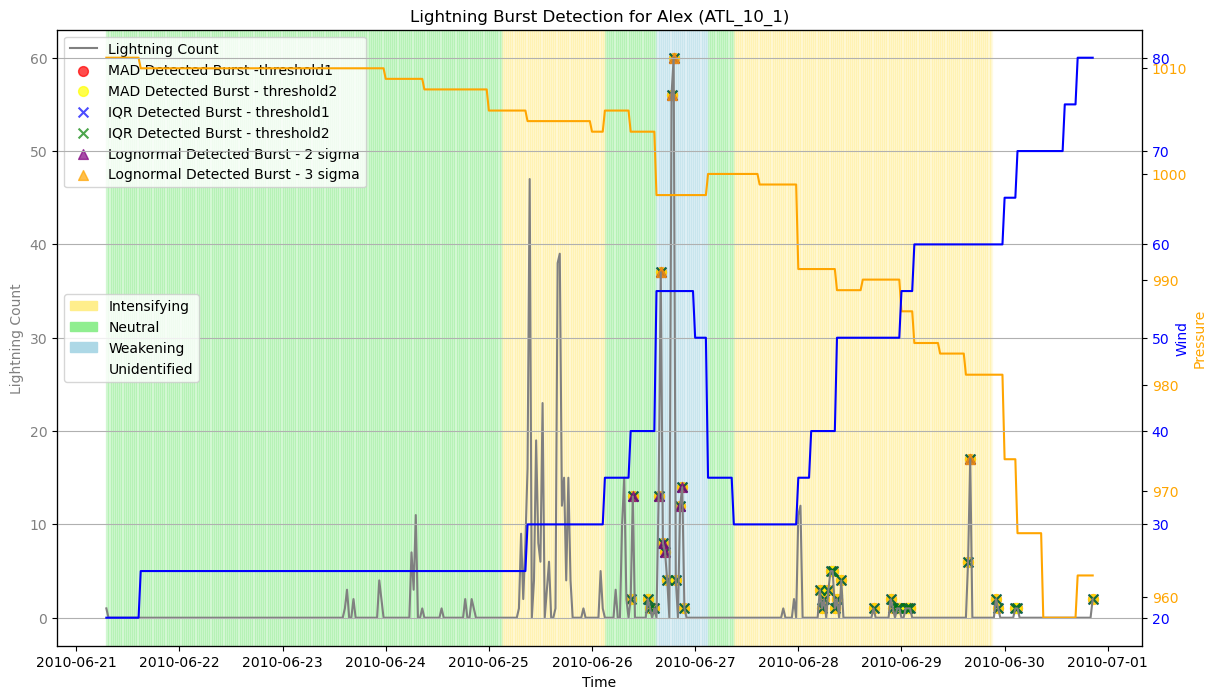

<Figure size 1000x500 with 0 Axes>

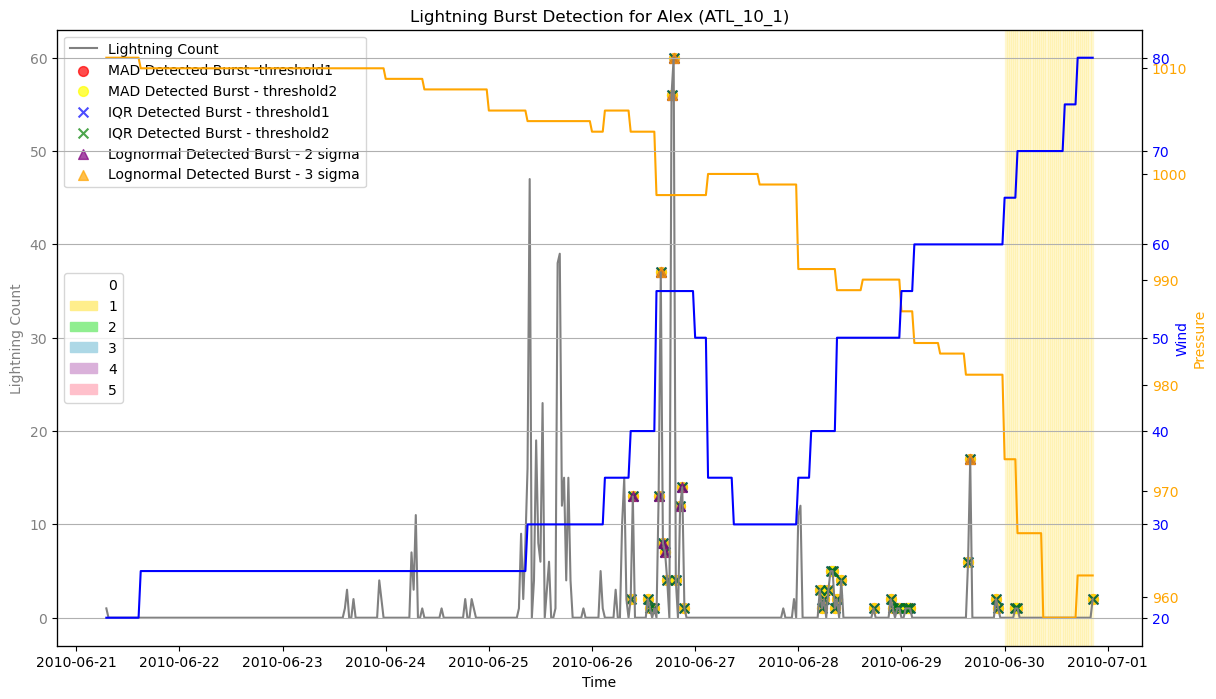

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
0   ATL_10_1           40           40             0.0             0.0   

   iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
0           40           40             0.0             0.0            10   

   logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0             4         1.964998          2.76676         168      23.81   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0      23.81      23.81      23.81        5.95        2.38

In [24]:
# ATL_10_1 with 0 in the analysis
cyclone_id = 'ATL_10_1'
plot_tc_intensification(cyclone_id, processed_w_0, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed_w_0, storm_names, innercore_data, "c5")
# Print the summary for this storm
agg_result_w_0[agg_result_w_0["storm_code"] == cyclone_id]

Next, we try applying the thresholds to the dataset without timebins with 0 lightning count. This slightly alters our definition of a lightning burst - we now compare each set of lightning events to other nonzero lightning events. This should bring up the threshold and bring down the percent of timebins flagged as a burst.

In [303]:
# Apply functions to data(exclude 0 lightning count)
pd_data_0 = pd_data[pd_data['lightning_count'] != 0]

processed = apply_individual_thresholds(pd_data_0)

agg_result = create_agg_result(processed)
agg_result = pd.merge(storm_names.to_pandas(), agg_result, on="storm_code")
agg_result.head(10)

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
0  SHEM_17_18      Donna            0            0        7.279569   
1   EPAC_14_7  Genevieve            0            0        6.340359   
2   SHEM_20_2      Belna            5            2        2.720473   
3  SHEM_20_25     Harold            0            0        6.028249   
4   WPAC_12_5     Guchol            0            0        6.637684   
5   ATL_18_14    Michael            0            0        7.012608   
6     IO_18_5      Luban            0            0        0.693147   
7  SHEM_12_16       Koji            0            0        7.279569   
8   EPAC_13_7        Gil            0            0        5.967748   
9  EPAC_15_12    Ignacio            0            0        7.697354   

   mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
0        8.458224            0            0        6.064650        7.234239   
1        7.438972            0            0        4.937563        5.861341   
2        3.125938            8            2        2.525729        2.983874   
3        6.875547            4            0        5.401175        6.303529   
4        7.655868            0            0        5.478682        6.501779   
5        8.088747            0            0        5.554509        6.540776   
6        0.693147            0            0        0.693147        0.693147   
7        8.458224            0            0        5.481680        6.505526   
8        6.884039            0            0        5.606721        6.661827   
9        8.899100            0            0        6.470024        7.699116   

   ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0  ...             0         5.456492         6.869271         158       0.00   
1  ...             0         4.265152         5.350361          23       0.00   
2  ...             2         2.829050         3.587363          80       6.25   
3  ...             0         5.408574         6.724197         155       0.00   
4  ...             0         4.917586         6.118076         148       0.00   
5  ...             0         5.330352         6.657978          87       0.00   
6  ...             0              NaN              NaN           1       0.00   
7  ...             0         5.051526         6.326662         105       0.00   
8  ...             0         4.967780         6.221871          57       0.00   
9  ...             0         5.813649         7.295533         104       0.00   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0        0.0       0.00        0.0        1.27         0.0  
1        0.0       0.00        0.0        0.00         0.0  
2        2.5      10.00        2.5        6.25         2.5  
3        0.0       2.58        0.0        2.58         0.0  
4        0.0       0.00        0.0        3.38         0.0  
5        0.0       0.00        0.0        2.30         0.0  
6        0.0       0.00        0.0        0.00         0.0  
7        0.0       0.00        0.0        1.90         0.0  
8        0.0       0.00        0.0        1.75         0.0  
9        0.0       0.00        0.0        1.92         0.0  

[10 rows x 21 columns]

<Figure size 1000x500 with 0 Axes>

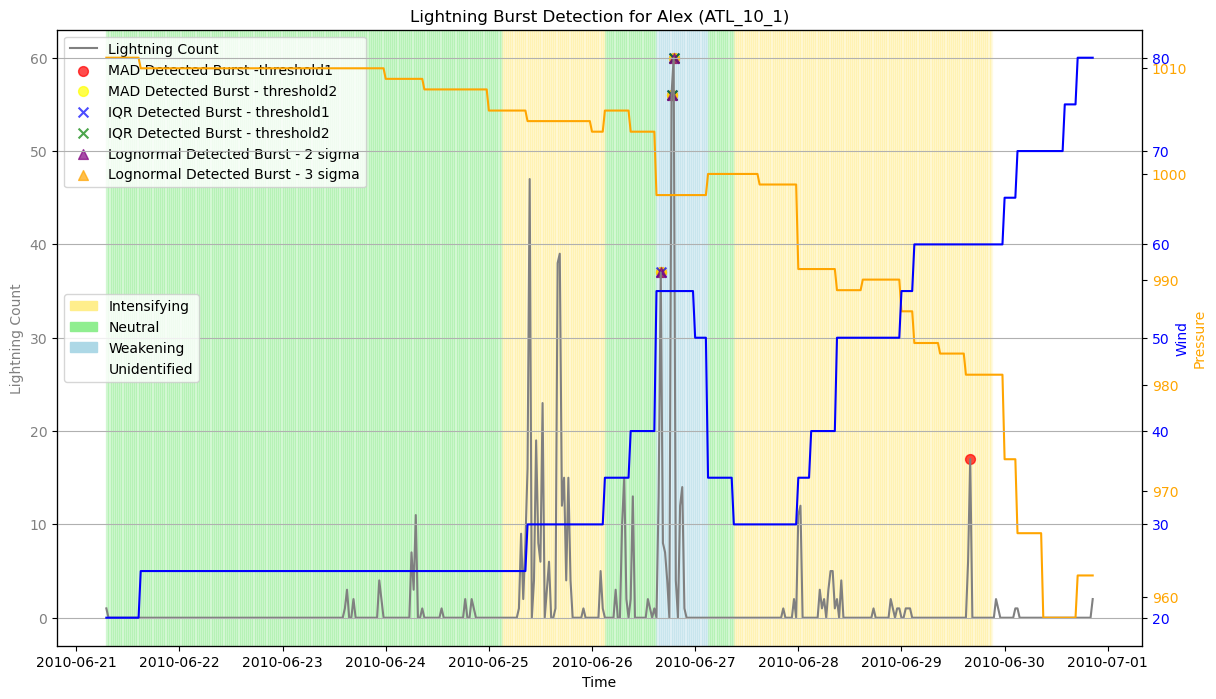

<Figure size 1000x500 with 0 Axes>

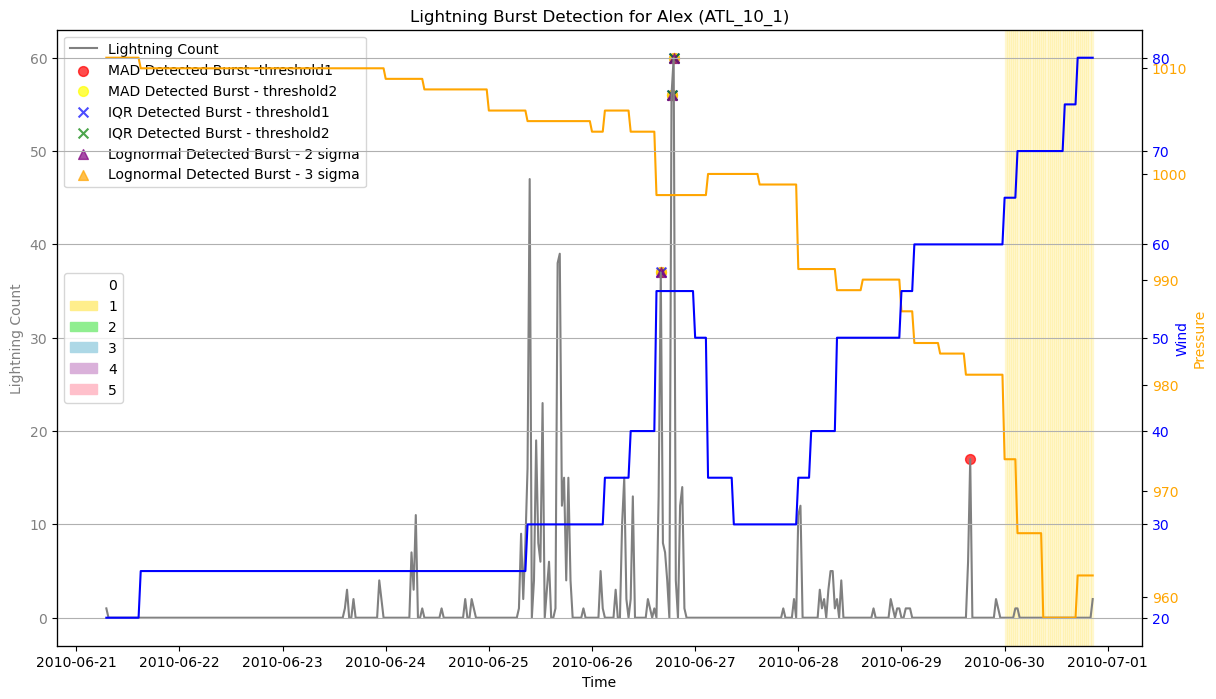

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
0   ATL_10_1            4            3        2.720473        3.125938   

   iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
0            3            2        3.265439        3.908512             3   

   logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0             0         3.469047         4.444476          40       10.0   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0        7.5        7.5        5.0         7.5         0.0

In [235]:
# ATL_10_1 without 0 in threshold calculation
cyclone_id = 'ATL_10_1'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# Print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

We see above that the analysis including timebins with 0 lightning events skews the threshold to 0, such that any lightning event is flagged as a burst. This is not realistic, and so we will not include the timebins with 0 lightning events in our threshold analysis.

Below, we look at a couple more TCs. We plot the lightning, wind, pressure, all detected lightning bursts using the 6 thresholds created above, and their intensification category/current category bins as color-coded backgrounds. Note that all data is plotted, regardless of if the point was included in the analysis (we do not consider data points associated with winds less than 40 knots in our threshold analysis).

<Figure size 1000x500 with 0 Axes>

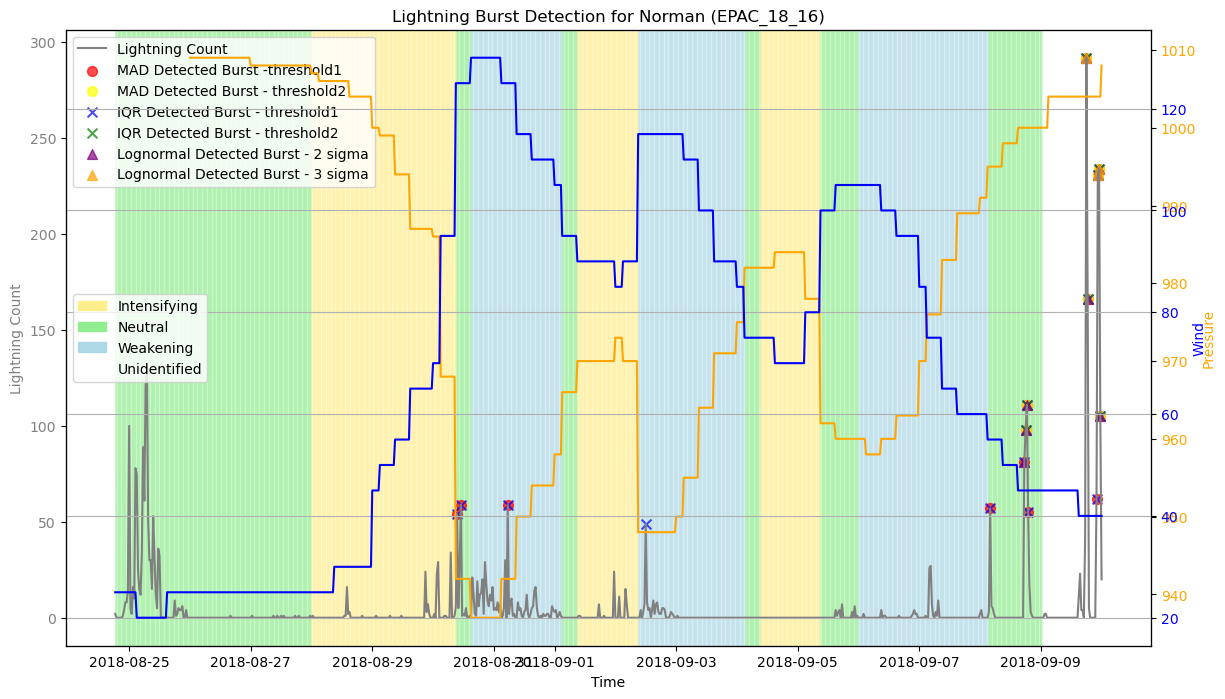

<Figure size 1000x500 with 0 Axes>

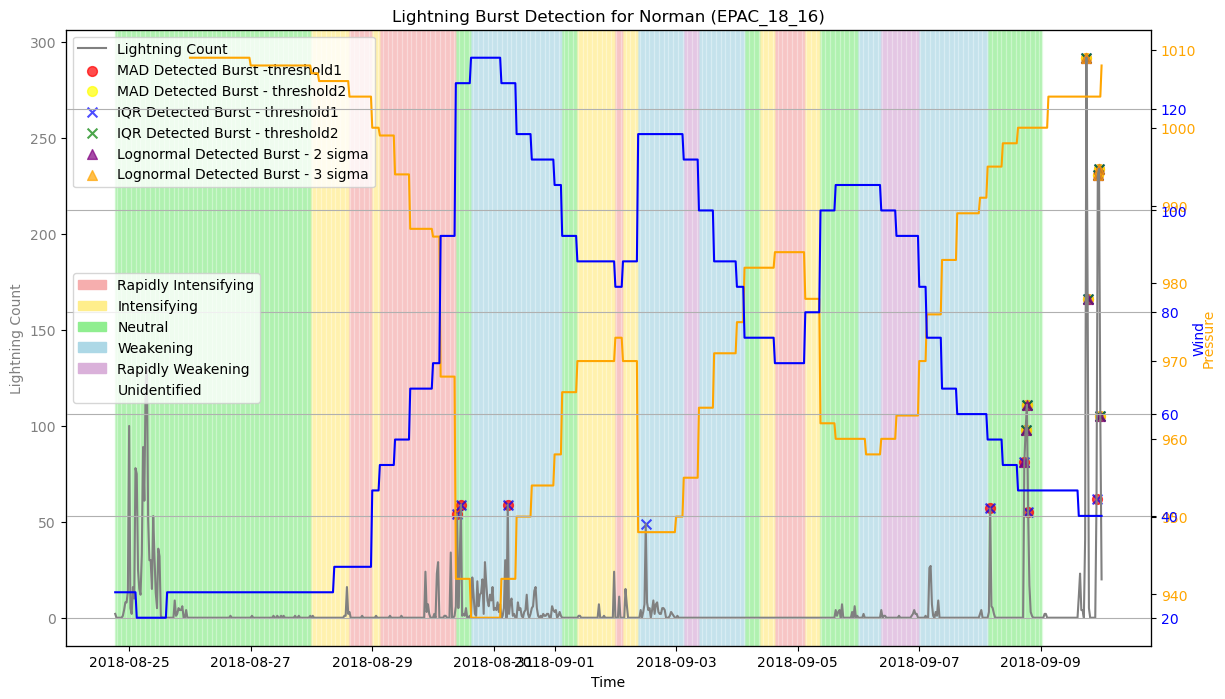

<Figure size 1000x500 with 0 Axes>

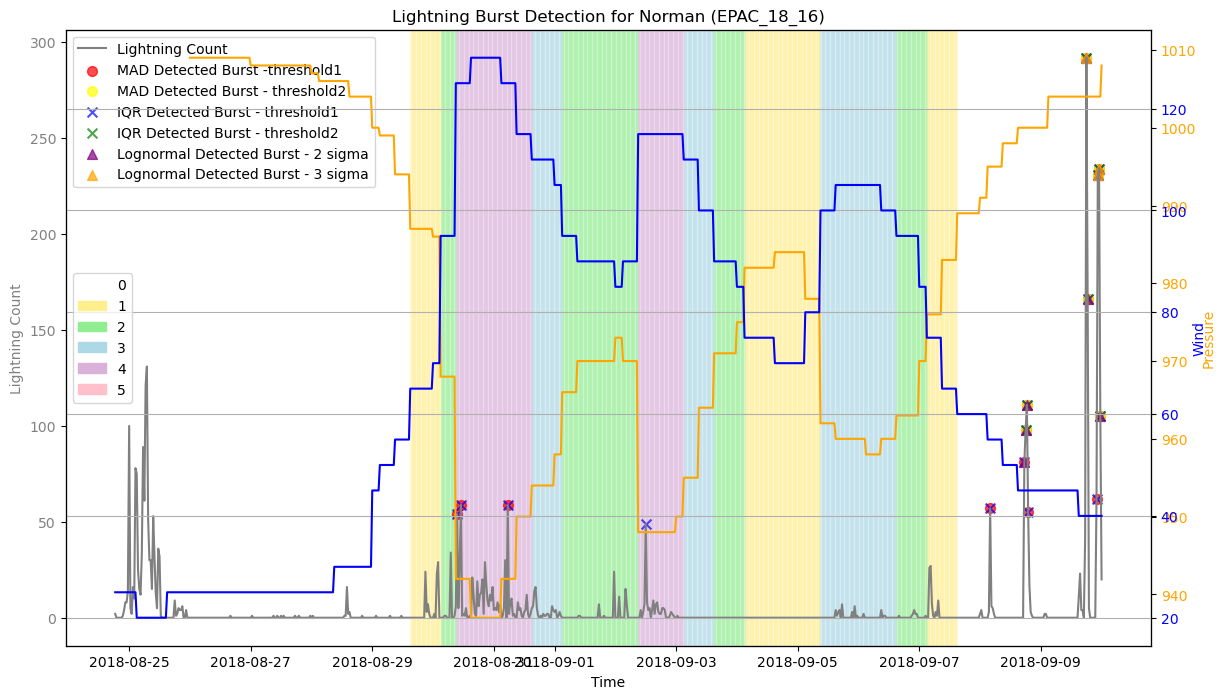

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
154  EPAC_18_16           14            7        3.960585        4.548371   

     iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
154           15            7        3.871201        4.564348             8   

     logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
154             3         4.218458         5.368579         170       8.24   

     mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
154       4.12       8.82       4.12        4.71        1.76

In [236]:
# EPAC_18_16 - Norman
cyclone_id = 'EPAC_18_16'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# Print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

<Figure size 1000x500 with 0 Axes>

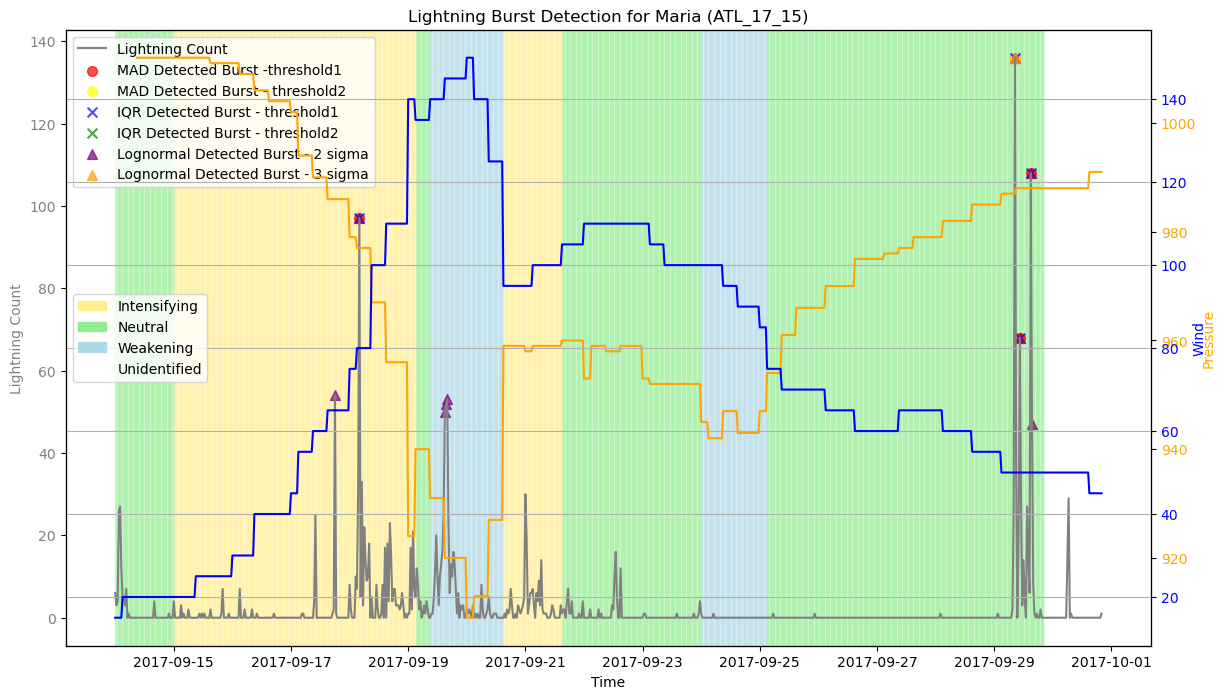

<Figure size 1000x500 with 0 Axes>

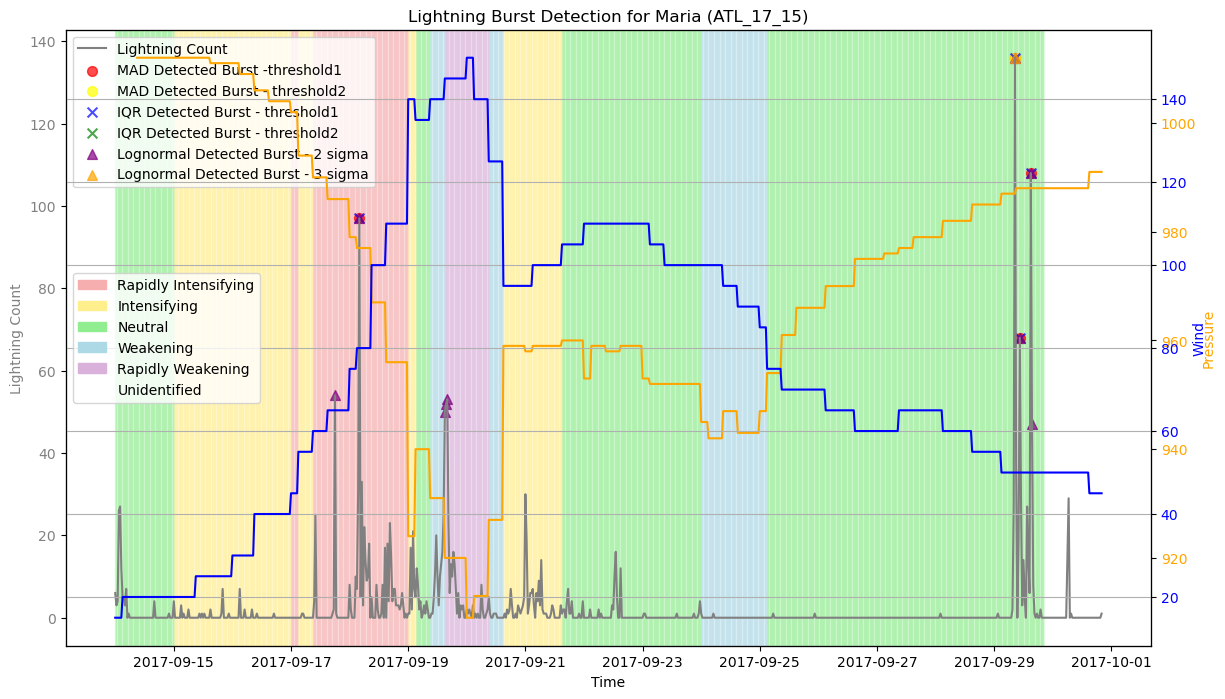

<Figure size 1000x500 with 0 Axes>

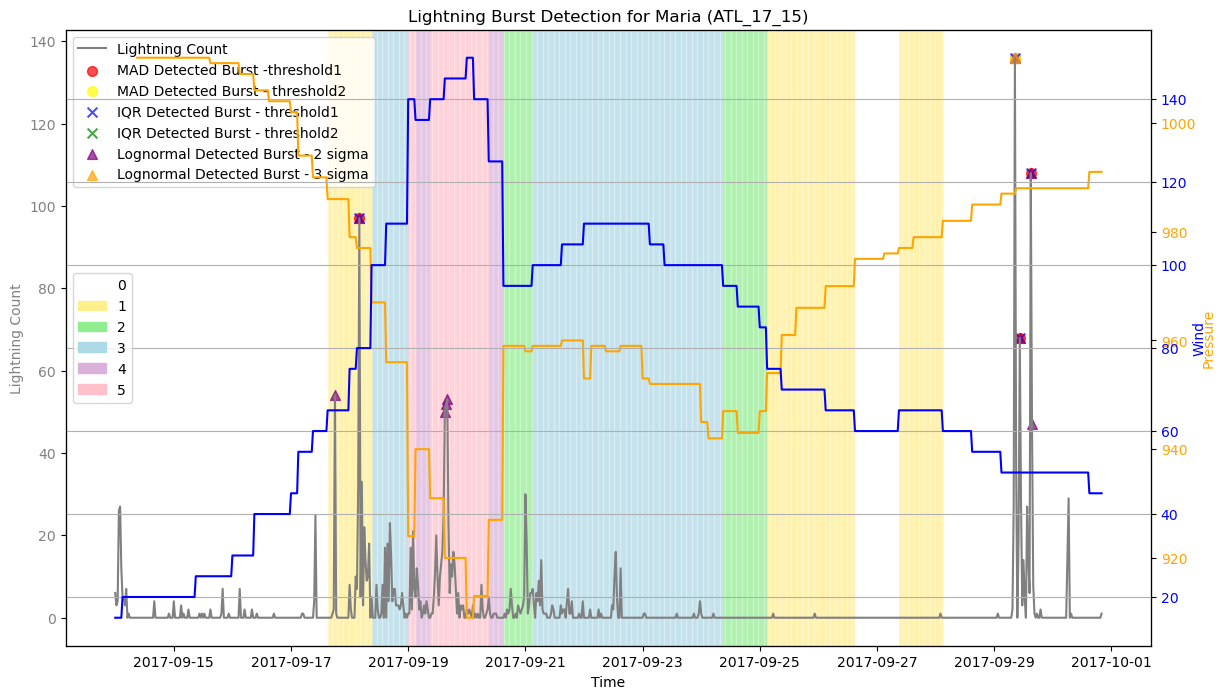

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
50  ATL_17_15            4            1        4.158883         4.85203   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
50            4            0        4.102643        4.955017             9   

    logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
50             1         3.761648         4.773138         191       2.09   

    mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
50       0.52       2.09        0.0        4.71        0.52

In [237]:
# ATL_17_15 - Maria
cyclone_id = 'ATL_17_15'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# Print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

In [308]:
# Export for external tool vis
innercore_data.write_csv("vis_data/tc_lightning_vis_data.csv")
agg_result.to_csv("vis_data/threshold_summary.csv")
processed.to_csv("vis_data/tc_threshold.csv")

In [56]:
# Define threshold names for use later
threshold_names = {
    'mad1':['mad1_threshold','MAD1'],
    'mad2':['mad2_threshold','MAD2'],
    'iqr1':['iqr1_threshold','IQR1'],
    'iqr2':['iqr2_threshold','IQR2'],
    'logn1':['logn1_threshold','Lognormal 2 Sigma'],
    'logn2':['logn2_threshold','Lognormal 3 Sigma'],
}
threshold_keys = list(threshold_names.keys())
threshold_cols = [threshold_names[key][0] for key in threshold_keys]
threshold_labels = [threshold_names[key][1] for key in threshold_keys]

In [304]:
# No bursts detected
# marker - need to look into why the agg result dataframes are not the same length??
selected_columns = ["mad1_bursts", "mad2_bursts", "iqr1_bursts", "iqr2_bursts", "logn1_bursts", "logn2_bursts"]
print(f"{(agg_result_w_0[selected_columns].sum(axis=1) == 0).sum()} TCs of {len(agg_result_w_0)} TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.")
no_bursts = agg_result[agg_result[selected_columns].sum(axis=1) == 0]
print(f"{len(no_bursts)} TCs of {len(agg_result)} TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.")

11 TCs of 472 TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.
106 TCs of 478 TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.


-------------------

### EPAC Basin
We now look at lightning burst thresholds at the basin level, starting with EPAC. We take the individual TC thresholds for TCs in the EPAC basin and create a basin-level standard separated by current category, where categories 0-2 are grouped together and categories 3-5 are grouped together.

In [30]:
# Get list of EPAC storm codes
epac_data = innercore_data.filter(pl.col("basin") == "EPAC")
epac_storm_codes = epac_data["storm_code"].unique()
epac_storm_codes.head()

shape: (10,)
Series: 'storm_code' [str]
[
	"EPAC_20_18"
	"EPAC_12_7"
	"EPAC_12_9"
	"EPAC_15_9"
	"EPAC_15_20"
	"EPAC_19_13"
	"EPAC_13_4"
	"EPAC_16_4"
	"EPAC_18_15"
	"EPAC_18_21"
]

In [288]:
# Filter aggregated table to EPAC only
epac_agg_result = agg_result[agg_result["storm_code"].isin(epac_storm_codes)]
epac_agg_result.head()

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
91   EPAC_10_4            0            0        6.704246        7.893830   
92   EPAC_10_9            0            0        6.063117        7.111688   
93   EPAC_11_1            1            0        2.720473        3.125938   
94  EPAC_11_10            0            0       10.223271       11.946037   
95  EPAC_11_11            0            0       10.962409       12.785568   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
91            0            0        5.172376        6.190817             2   
92            3            0        4.810531        5.763852             3   
93            7            6        2.079442        2.426015             4   
94            0            0        8.230524        9.885795             0   
95            0            0        9.045240       10.829707             0   

    logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
91             0         4.679426         5.944917          93       0.00   
92             0         4.643800         5.918609          84       0.00   
93             0         2.502932         3.150601          49       2.04   
94             0         6.999298         8.822181         145       0.00   
95             0         7.906256         9.996606          48       0.00   

    mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
91        0.0       0.00       0.00        2.15         0.0  
92        0.0       3.57       0.00        3.57         0.0  
93        0.0      14.29      12.24        8.16         0.0  
94        0.0       0.00       0.00        0.00         0.0  
95        0.0       0.00       0.00        0.00         0.0

In [32]:
# Filter lightning point data to EPAC only
epac_processed = processed[processed["storm_code"].isin(epac_storm_codes)]
epac_processed.head()

time_bin storm_code  lightning_count  year  month  day  hour  \
10047 2010-06-19 18:30:00  EPAC_10_4                5  2010      6   19    18   
10048 2010-06-19 20:30:00  EPAC_10_4                1  2010      6   19    20   
10049 2010-06-20 11:30:00  EPAC_10_4                1  2010      6   20    11   
10050 2010-06-20 12:00:00  EPAC_10_4                7  2010      6   20    12   
10051 2010-06-20 12:30:00  EPAC_10_4               26  2010      6   20    12   

       minute   lat   lon  ...  iqr1_threshold  iqr2_threshold burst_mad1  \
10047      30  12.4 -97.6  ...        5.172376        6.190817      False   
10048      30  12.4 -97.6  ...        5.172376        6.190817      False   
10049      30  11.8 -99.5  ...        5.172376        6.190817      False   
10050       0  11.8 -99.5  ...        5.172376        6.190817      False   
10051      30  11.8 -99.5  ...        5.172376        6.190817      False   

       burst_mad2 mad1_threshold  mad2_threshold  burst_logn1  burst_logn2  \
10047       False       6.704246         7.89383        False        False   
10048       False       6.704246         7.89383        False        False   
10049       False       6.704246         7.89383        False        False   
10050       False       6.704246         7.89383        False        False   
10051       False       6.704246         7.89383        False        False   

      logn1_threshold logn2_threshold  
10047        4.679426        5.944917  
10048        4.679426        5.944917  
10049        4.679426        5.944917  
10050        4.679426        5.944917  
10051        4.679426        5.944917  

[5 rows x 34 columns]

Let's look at the unweighted threshold distribution (1 occurence per TC) before splitting the timebins by current category.

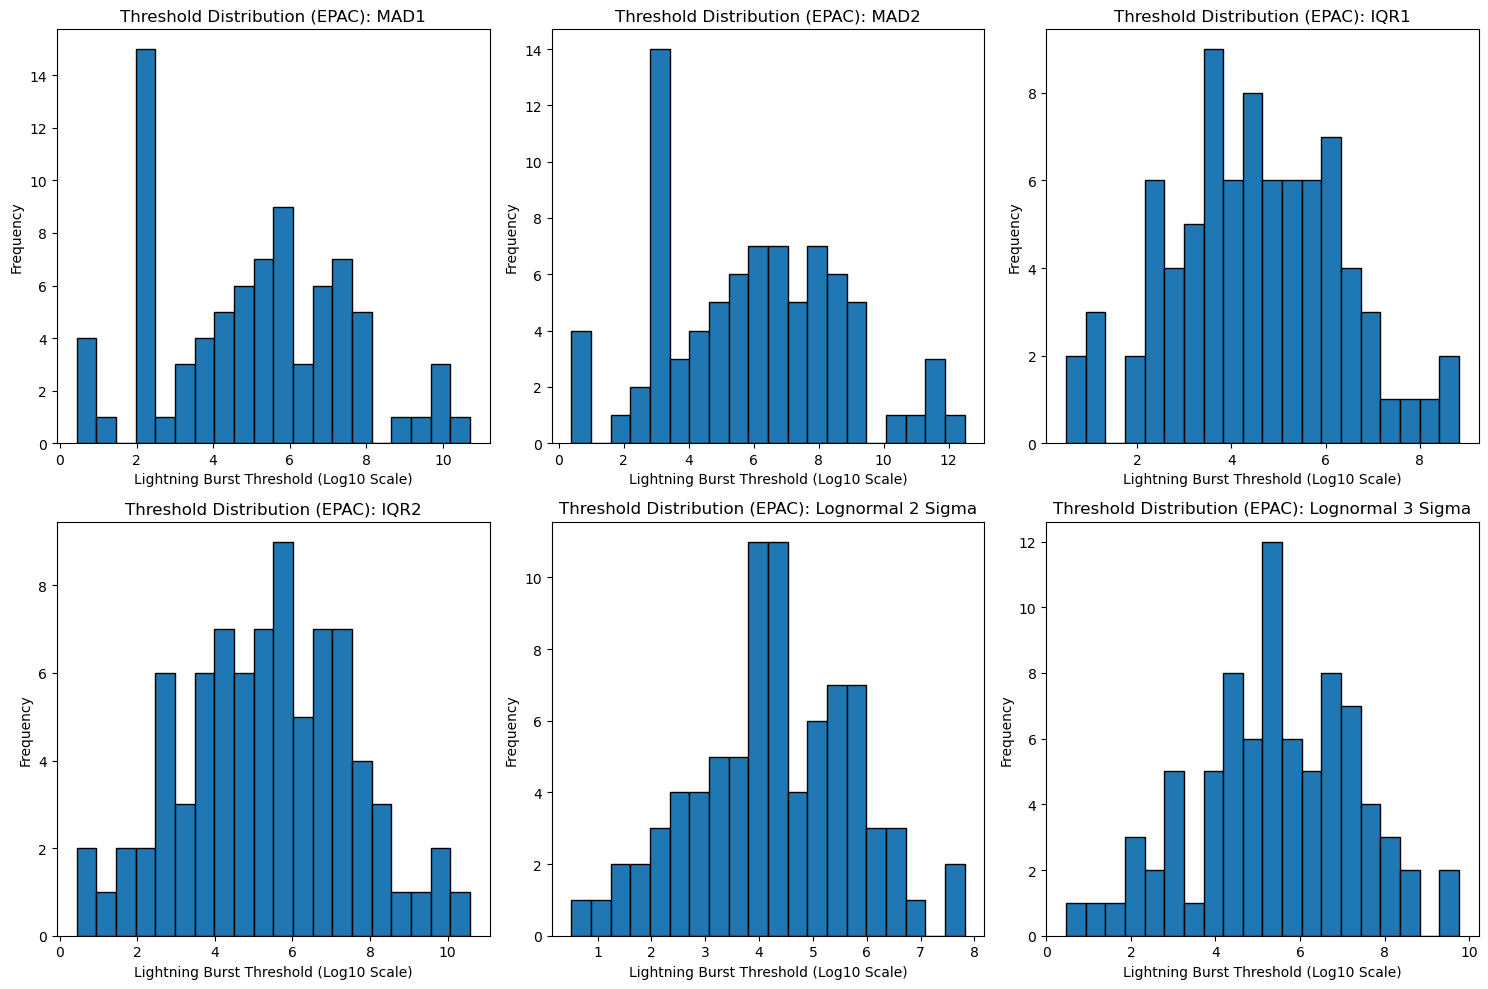

In [230]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_agg_result, threshold, ax=axes[i])
    axes[i].set_title(f"Threshold Distribution (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

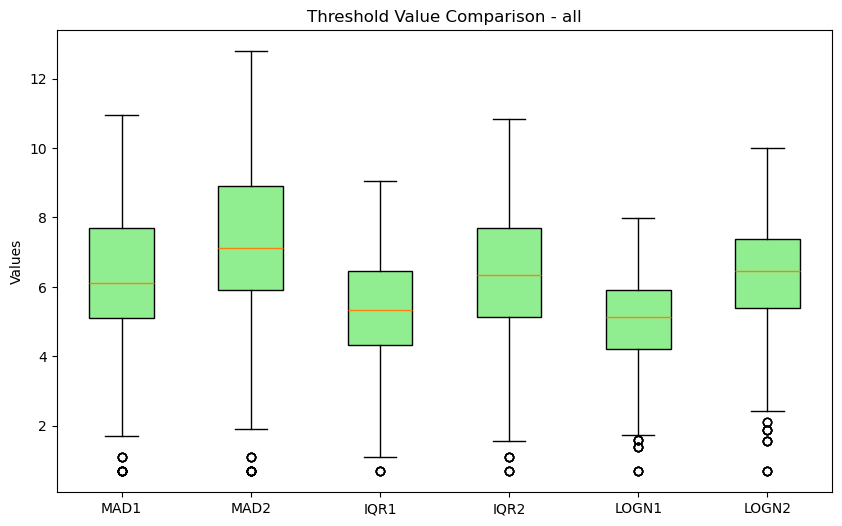

In [233]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(epac_processed, "all", ax=None)

Let's look at some specific TCs. 

ideas:
- most vs least vs mean/median total bursts detected? keep 6 separate?
- different categories (max speed)
- most overlap detections and least overlap detections between the 6 standards

Plotting some of the top 5 most and least bursts by threshold type:

In [296]:
selected_columns = ["mad1_bursts", "mad2_bursts", "iqr1_bursts", "iqr2_bursts", "logn1_bursts", "logn2_bursts"]
epac_no_bursts = epac_agg_result[epac_agg_result[selected_columns].sum(axis=1) == 0]
print(f"{len(epac_no_bursts)} TCs of {len(epac_agg_result)} TCs with no bursts detected across all 6 threshold methods.")

23 TCs of 82 TCs with no bursts detected across all 6 threshold methods.


In [290]:
# Top 5 most MAD1 bursts
epac_agg_result.sort_values(by="mad1_bursts", ascending=False).head(5)

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
30   EPAC_15_3     Carlos           18           16        2.720473   
81  EPAC_18_16     Norman           14            7        3.960585   
69  EPAC_18_10     Hector            7            2        3.652740   
3    EPAC_13_5      Erick            7            5        2.720473   
12   EPAC_20_8    Douglas            6            6        1.706810   

    mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
30        3.125938           12            8        3.701302        4.453341   
81        4.548371           15            7        3.871201        4.564348   
69        4.163566            8            2        3.506558        4.108544   
3         3.125938            4            2        3.465736        4.158883   
12        1.909543            1            0        2.414157        2.844409   

    ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
30  ...             1         4.560759         5.986970          94   
81  ...             3         4.218458         5.368579         170   
69  ...             1         3.599905         4.510039         184   
3   ...             0         4.205395         5.465820          29   
12  ...             0         2.379402         2.990767          34   

    mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
30      19.15      17.02      12.77       8.51        7.45        1.06  
81       8.24       4.12       8.82       4.12        4.71        1.76  
69       3.80       1.09       4.35       1.09        3.80        0.54  
3       24.14      17.24      13.79       6.90        6.90        0.00  
12      17.65      17.65       2.94       0.00        5.88        0.00  

[5 rows x 21 columns]

<Figure size 1000x500 with 0 Axes>

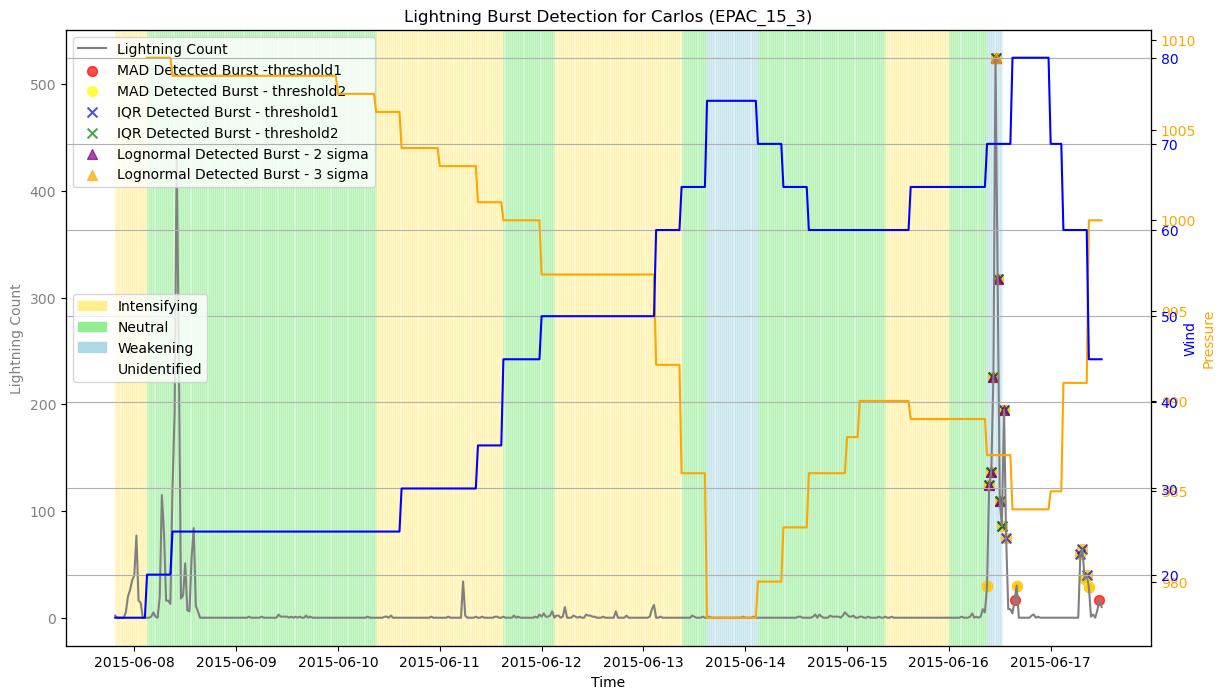

<Figure size 1000x500 with 0 Axes>

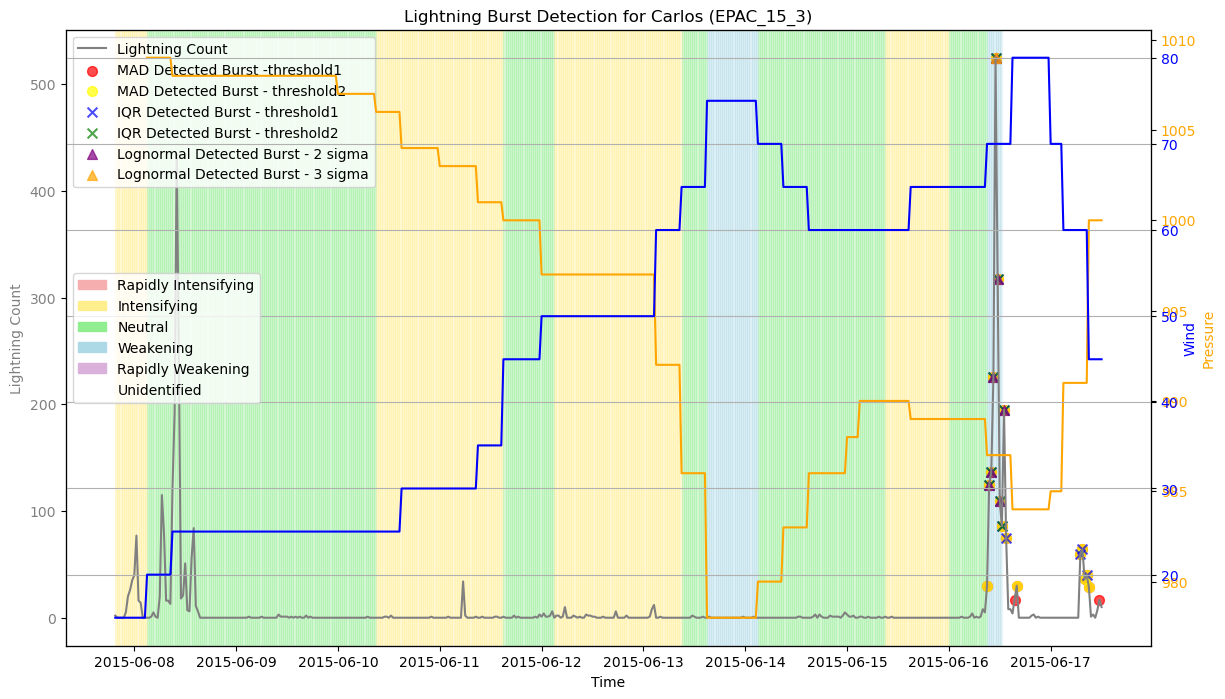

<Figure size 1000x500 with 0 Axes>

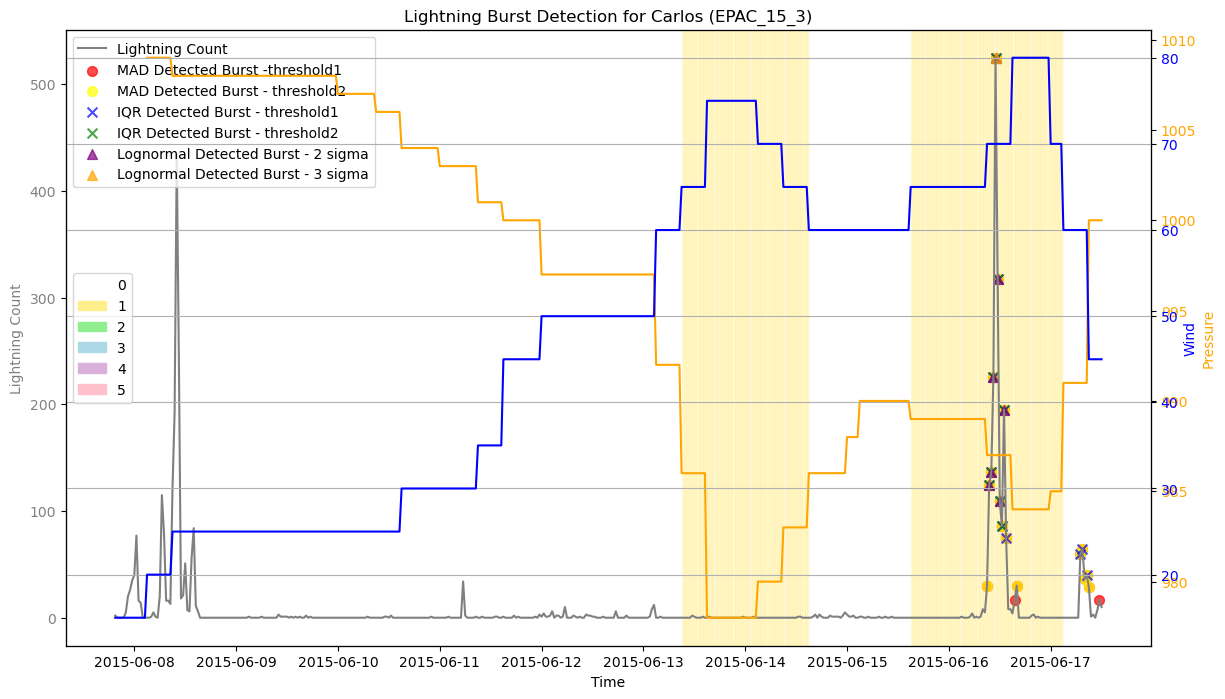

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
132  EPAC_15_3           18           16        2.720473        3.125938   

     iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
132           12            8        3.701302        4.453341             7   

     logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
132             1         4.560759          5.98697          94      19.15   

     mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
132      17.02      12.77       8.51        7.45        1.06

In [242]:
# EPAC_15_3 - Carlos
cyclone_id = 'EPAC_15_3'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# Print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

In [264]:
# Bottom 5 least MAD1 bursts
epac_agg_result.sort_values(by="mad1_bursts").head(5)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
91   EPAC_10_4            0            0        6.704246        7.893830   
92   EPAC_10_9            0            0        6.063117        7.111688   
94  EPAC_11_10            0            0       10.223271       11.946037   
95  EPAC_11_11            0            0       10.962409       12.785568   
96  EPAC_11_13            0            0        8.014107        9.295041   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
91            0            0        5.172376        6.190817             2   
92            3            0        4.810531        5.763852             3   
94            0            0        8.230524        9.885795             0   
95            0            0        9.045240       10.829707             0   
96            0            0        7.162914        8.505703             1   

    logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
91             0         4.679426         5.944917          93        0.0   
92             0         4.643800         5.918609          84        0.0   
94             0         6.999298         8.822181         145        0.0   
95             0         7.906256         9.996606          48        0.0   
96             0         6.578627         8.297217          81        0.0   

    mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
91        0.0       0.00        0.0        2.15         0.0  
92        0.0       3.57        0.0        3.57         0.0  
94        0.0       0.00        0.0        0.00         0.0  
95        0.0       0.00        0.0        0.00         0.0  
96        0.0       0.00        0.0        1.23         0.0

<Figure size 1000x500 with 0 Axes>

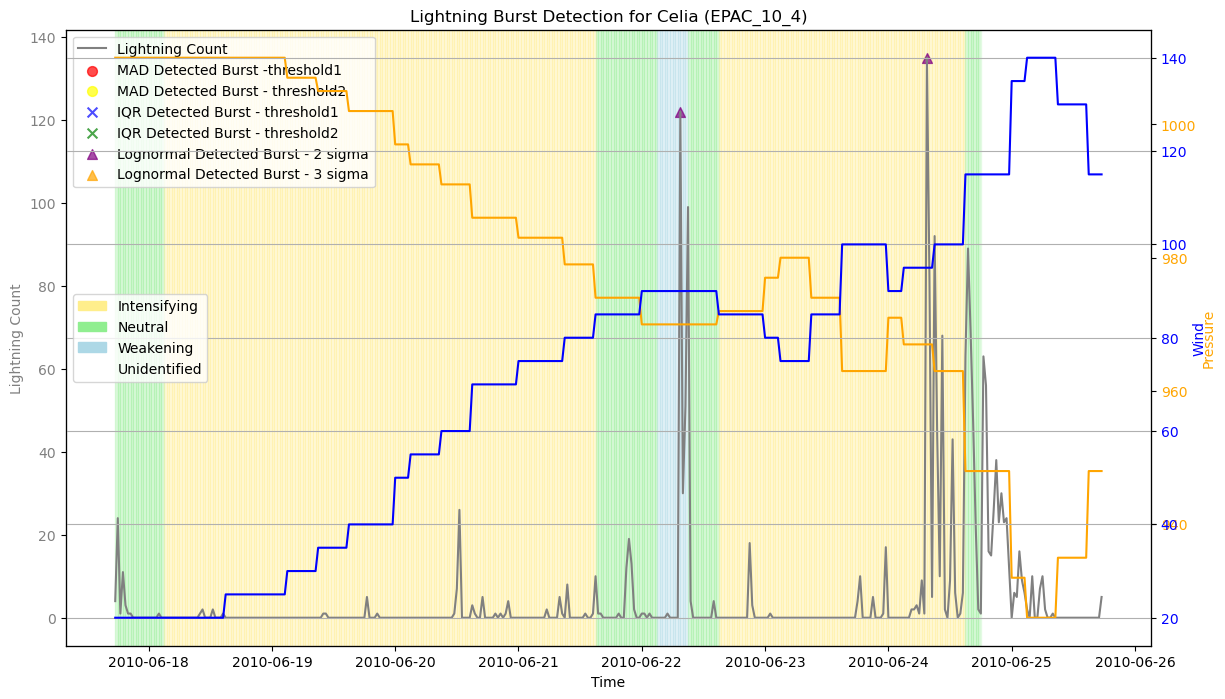

<Figure size 1000x500 with 0 Axes>

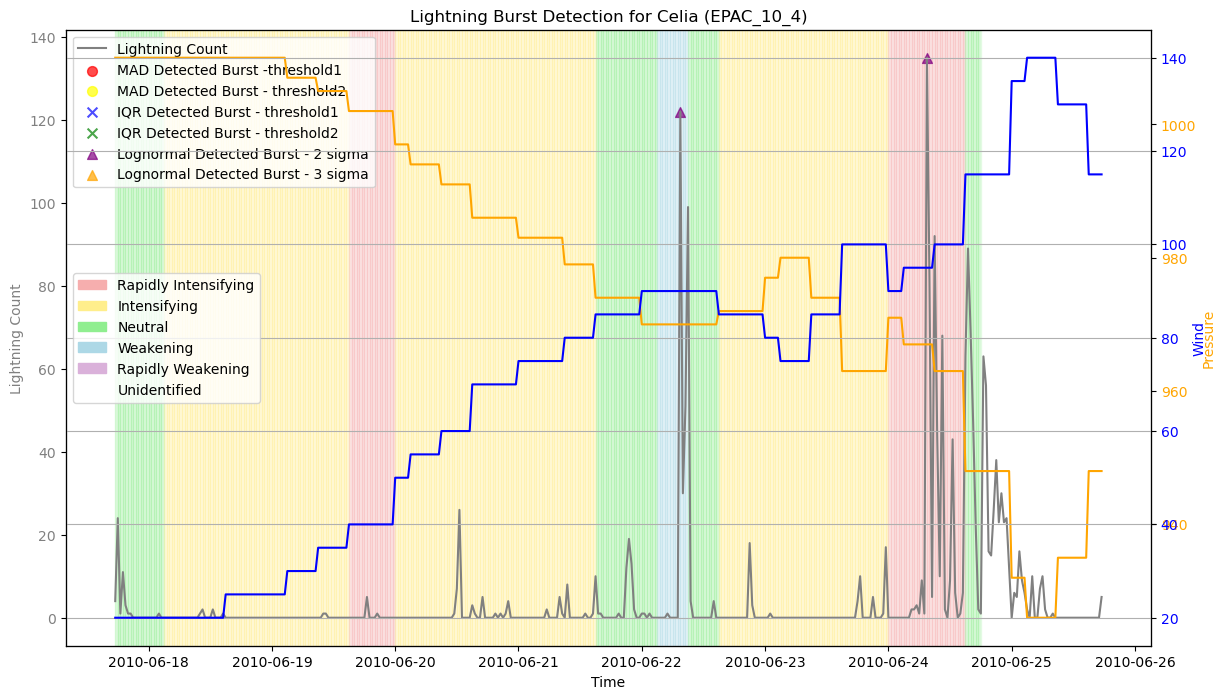

<Figure size 1000x500 with 0 Axes>

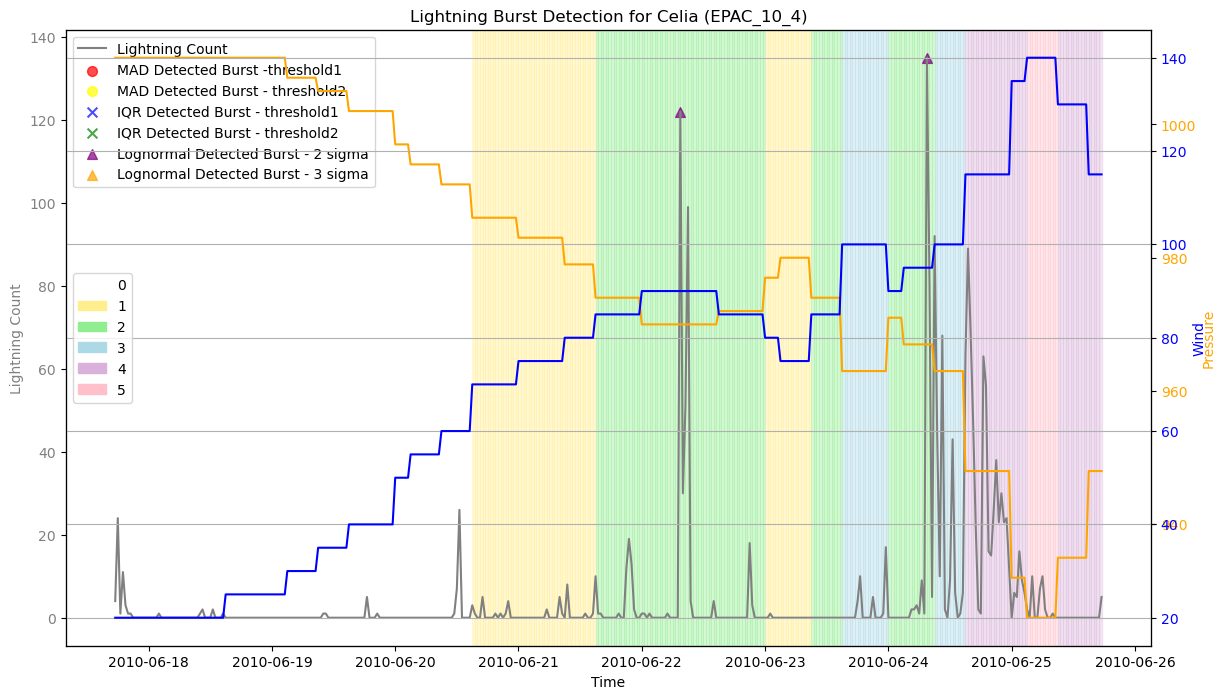

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
91  EPAC_10_4            0            0        6.704246         7.89383   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
91            0            0        5.172376        6.190817             2   

    logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
91             0         4.679426         5.944917          93        0.0   

    mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
91        0.0        0.0        0.0        2.15         0.0

In [265]:
# EPAC_10_4 - Celia
cyclone_id = 'EPAC_10_4'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# Print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

<Figure size 1000x500 with 0 Axes>

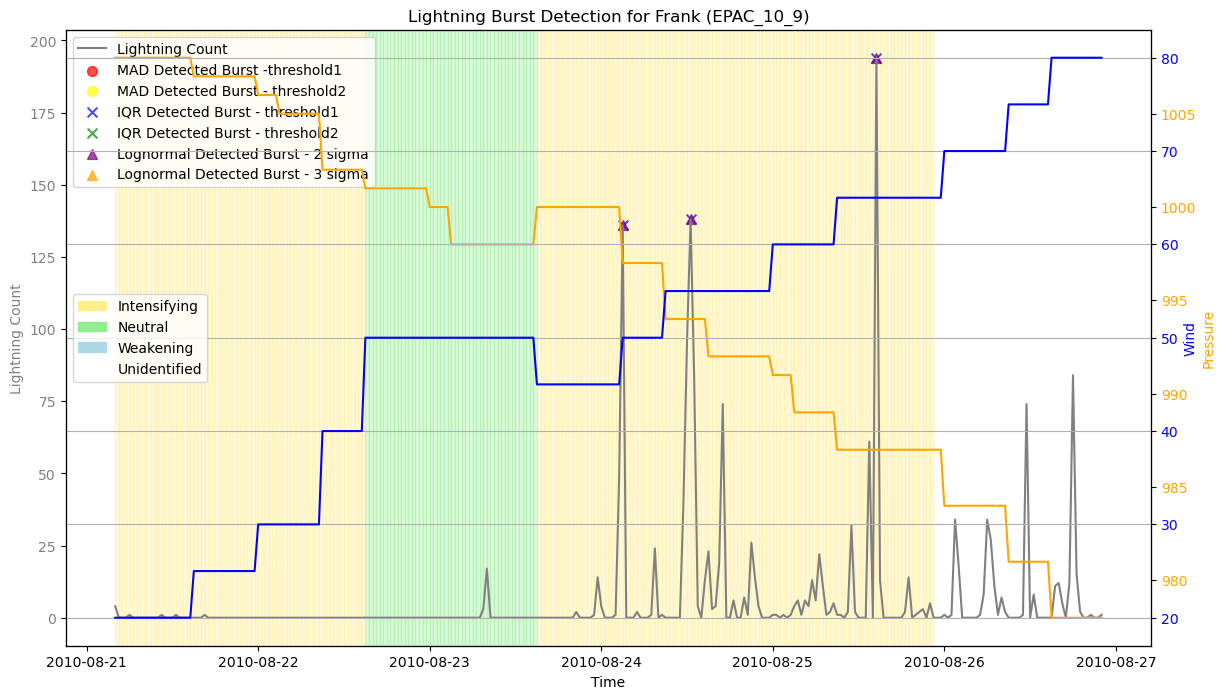

<Figure size 1000x500 with 0 Axes>

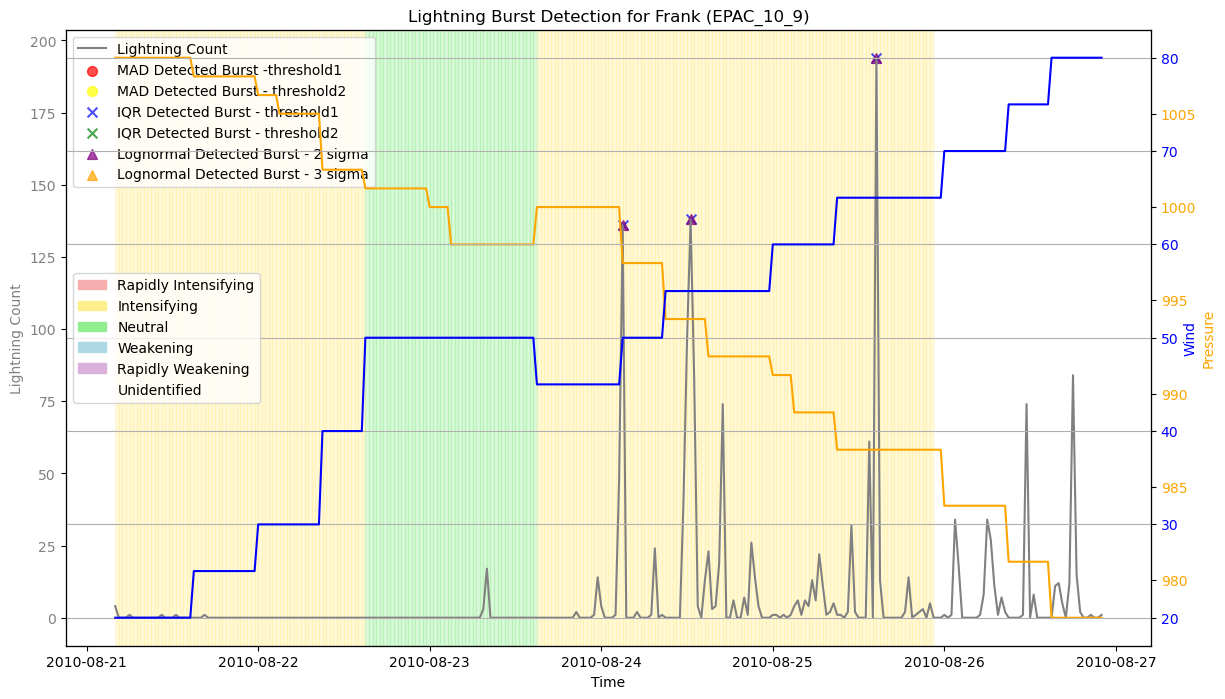

<Figure size 1000x500 with 0 Axes>

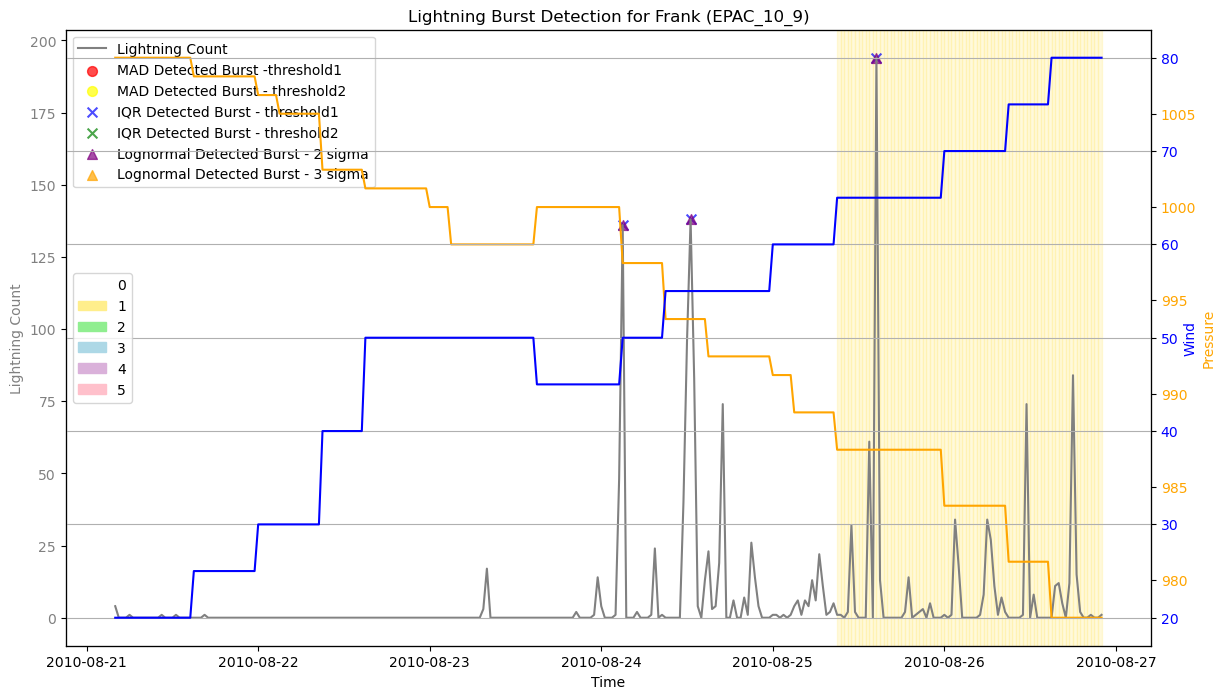

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
92  EPAC_10_9            0            0        6.063117        7.111688   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
92            3            0        4.810531        5.763852             3   

    logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
92             0           4.6438         5.918609          84        0.0   

    mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
92        0.0       3.57        0.0        3.57         0.0

In [266]:
# EPAC_10_9 - Frank
cyclone_id = 'EPAC_10_9'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# Print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

<Figure size 1000x500 with 0 Axes>

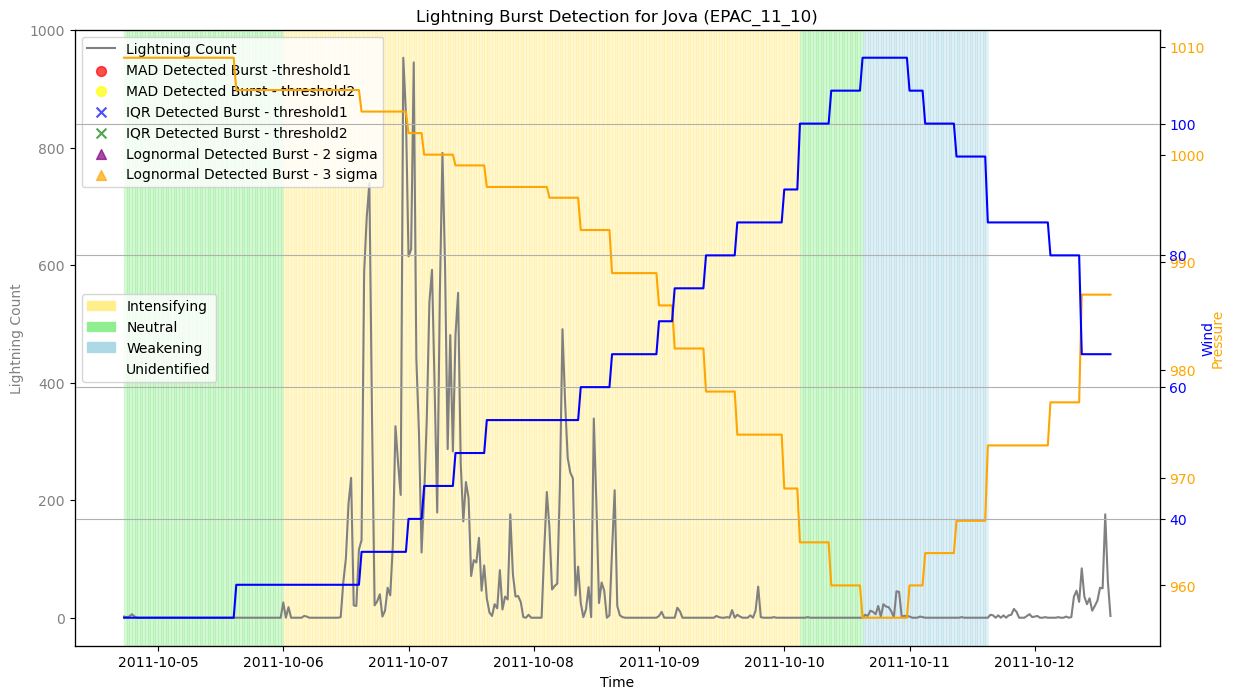

<Figure size 1000x500 with 0 Axes>

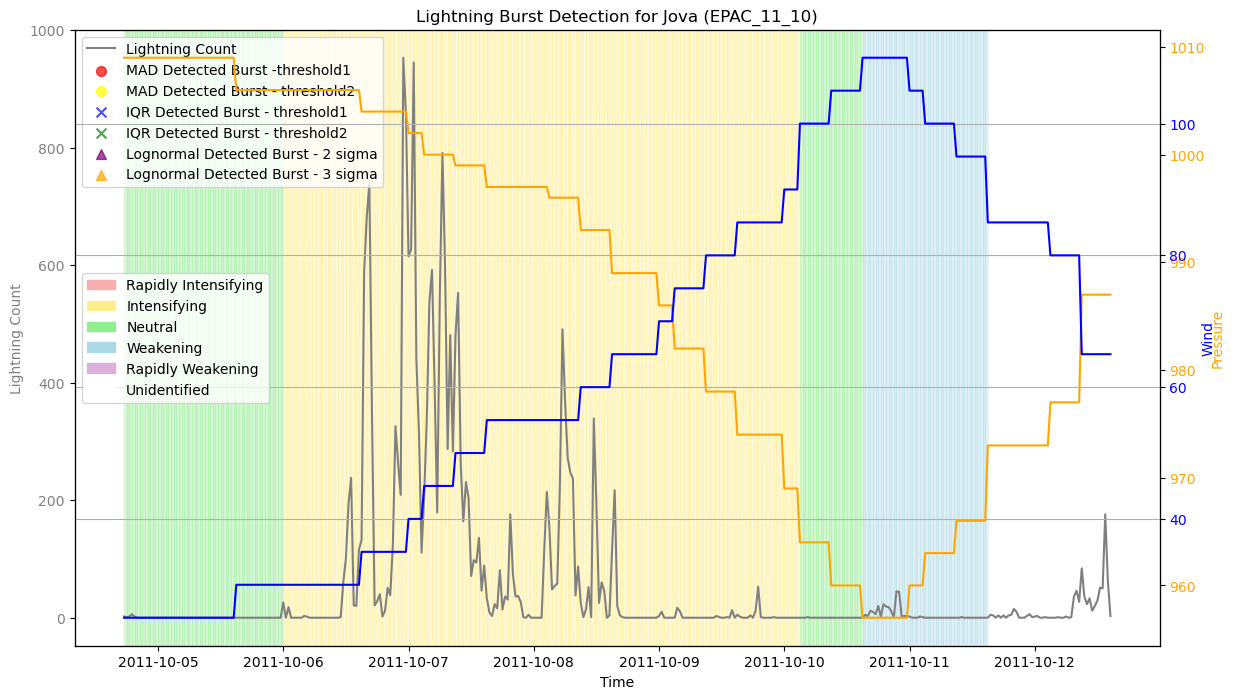

<Figure size 1000x500 with 0 Axes>

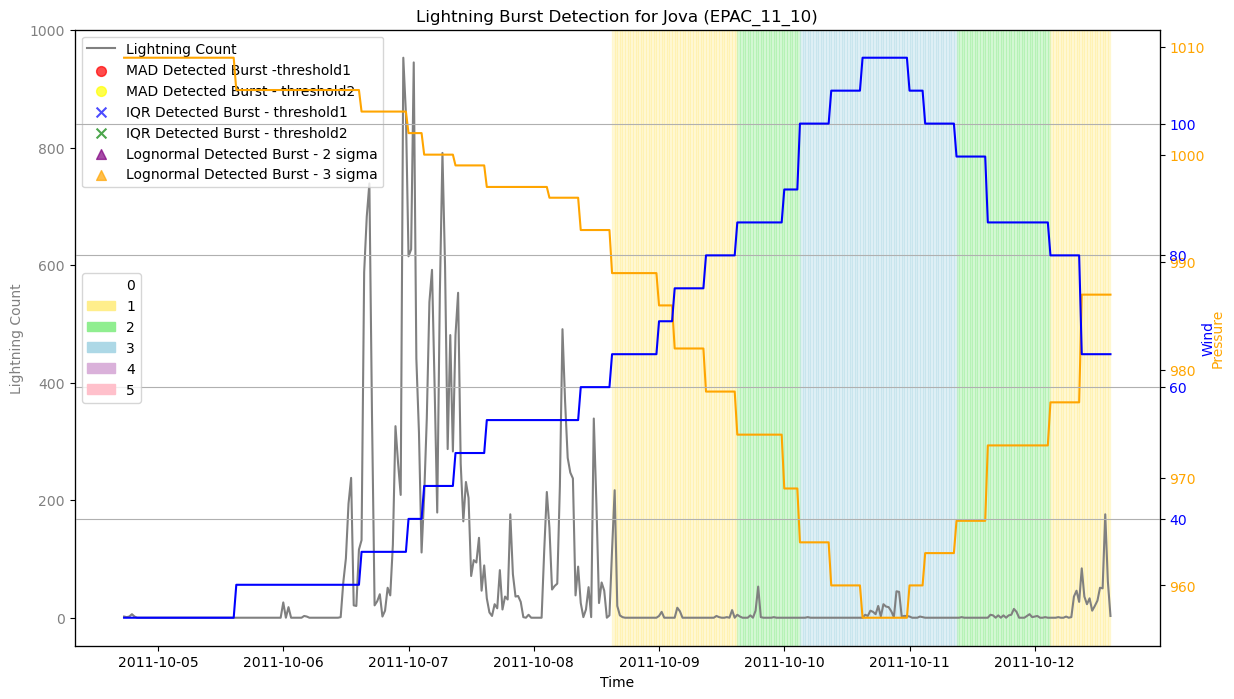

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
94  EPAC_11_10            0            0       10.223271       11.946037   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
94            0            0        8.230524        9.885795             0   

    logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
94             0         6.999298         8.822181         145        0.0   

    mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
94        0.0        0.0        0.0         0.0         0.0

In [267]:
# EPAC_11_10 - Jova - no burst case
cyclone_id = 'EPAC_11_10'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# Print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

<Figure size 1000x500 with 0 Axes>

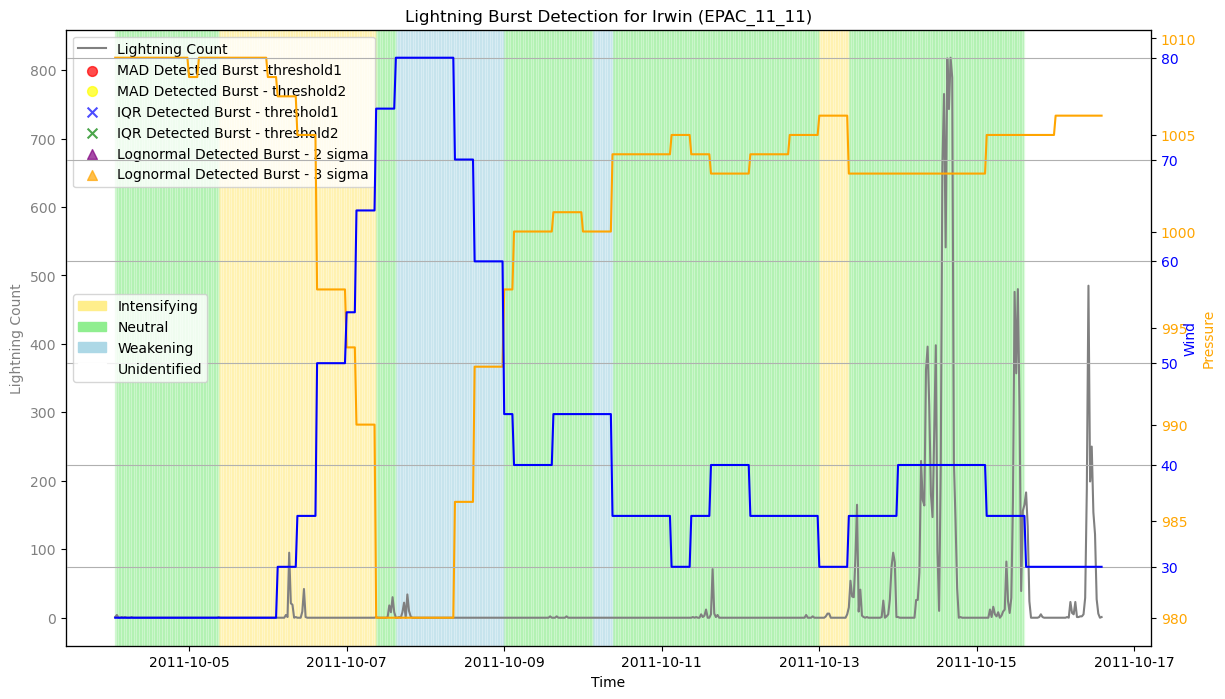

<Figure size 1000x500 with 0 Axes>

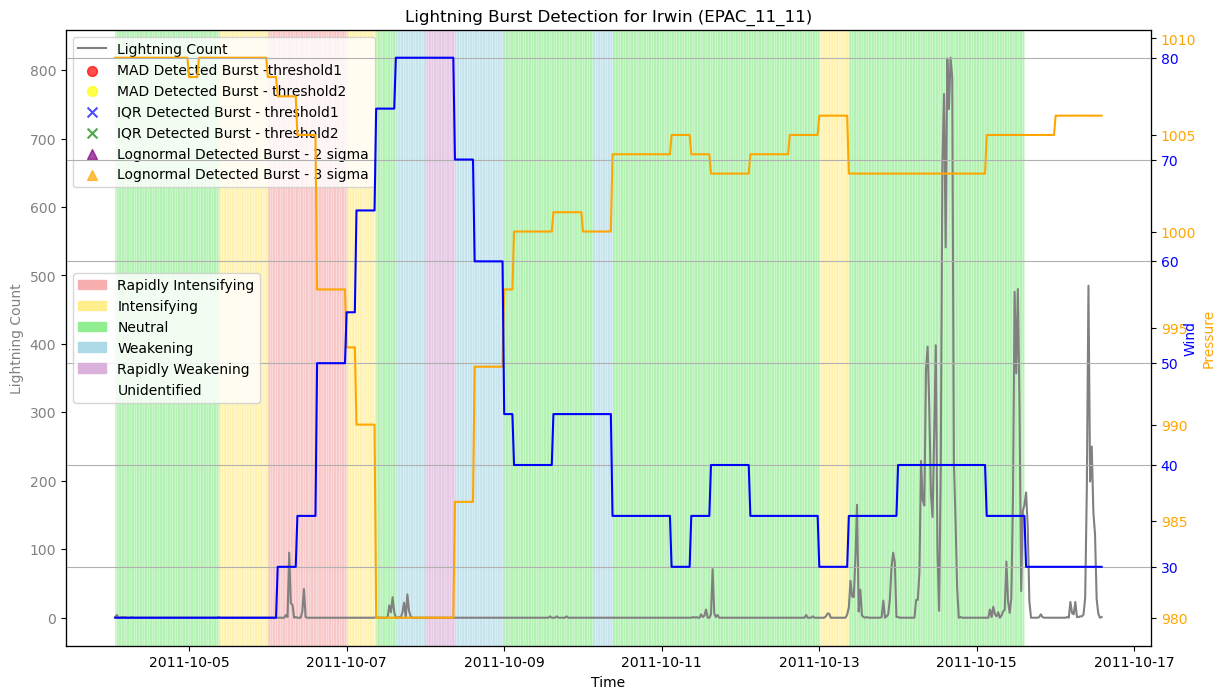

<Figure size 1000x500 with 0 Axes>

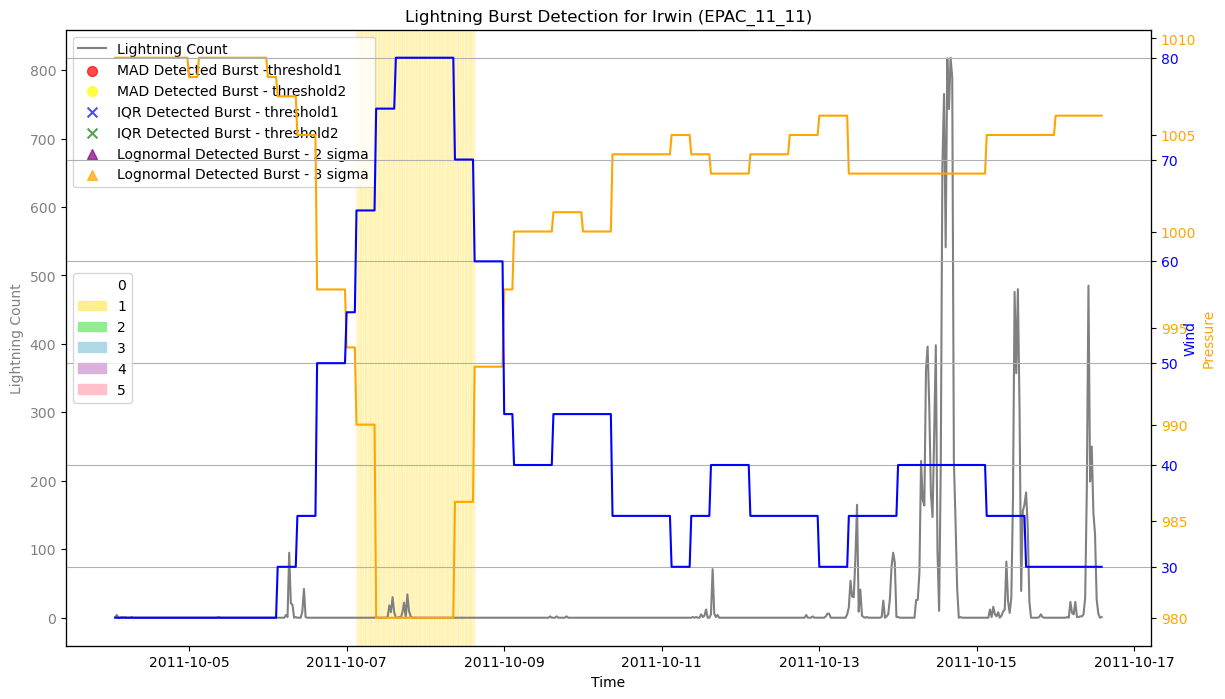

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
95  EPAC_11_11            0            0       10.962409       12.785568   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
95            0            0         9.04524       10.829707             0   

    logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
95             0         7.906256         9.996606          48        0.0   

    mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
95        0.0        0.0        0.0         0.0         0.0

In [268]:
# EPAC_11_11 - Irwin - no burst case
cyclone_id = 'EPAC_11_11'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# Print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

In [259]:
# Top 5 most IQR1 bursts
epac_agg_result.sort_values(by="iqr1_bursts", ascending=False).head(5)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
154  EPAC_18_16           14            7        3.960585        4.548371   
132   EPAC_15_3           18           16        2.720473        3.125938   
152  EPAC_18_14            2            0        5.792262        6.677852   
123  EPAC_15_10            1            0        5.252624        6.079303   
150  EPAC_18_10            7            2        3.652740        4.163566   

     iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
154           15            7        3.871201        4.564348             8   
132           12            8        3.701302        4.453341             7   
152           11            0        5.348297        6.338798            14   
123            9            2        4.317488        5.122207             8   
150            8            2        3.506558        4.108544             7   

     logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
154             3         4.218458         5.368579         170       8.24   
132             1         4.560759         5.986970          94      19.15   
152             0         5.137852         6.456639         294       0.68   
123             0         4.387132         5.545262         144       0.69   
150             1         3.599905         4.510039         184       3.80   

     mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
154       4.12       8.82       4.12        4.71        1.76  
132      17.02      12.77       8.51        7.45        1.06  
152       0.00       3.74       0.00        4.76        0.00  
123       0.00       6.25       1.39        5.56        0.00  
150       1.09       4.35       1.09        3.80        0.54

<Figure size 1000x500 with 0 Axes>

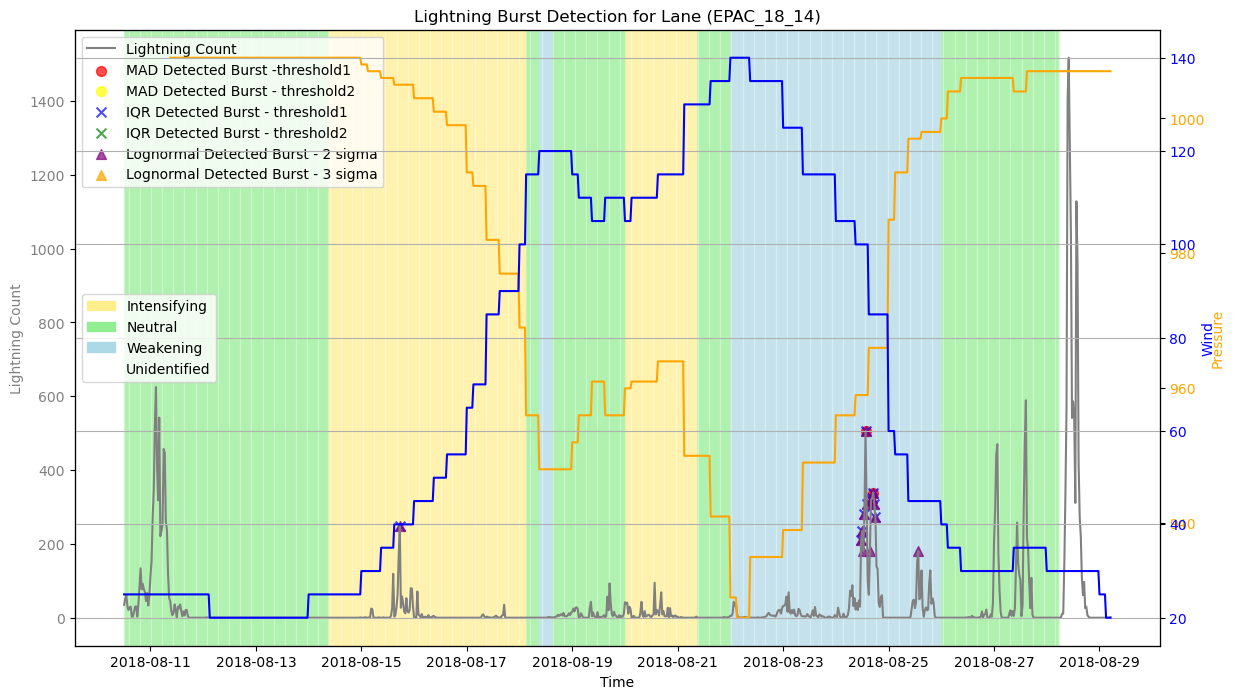

<Figure size 1000x500 with 0 Axes>

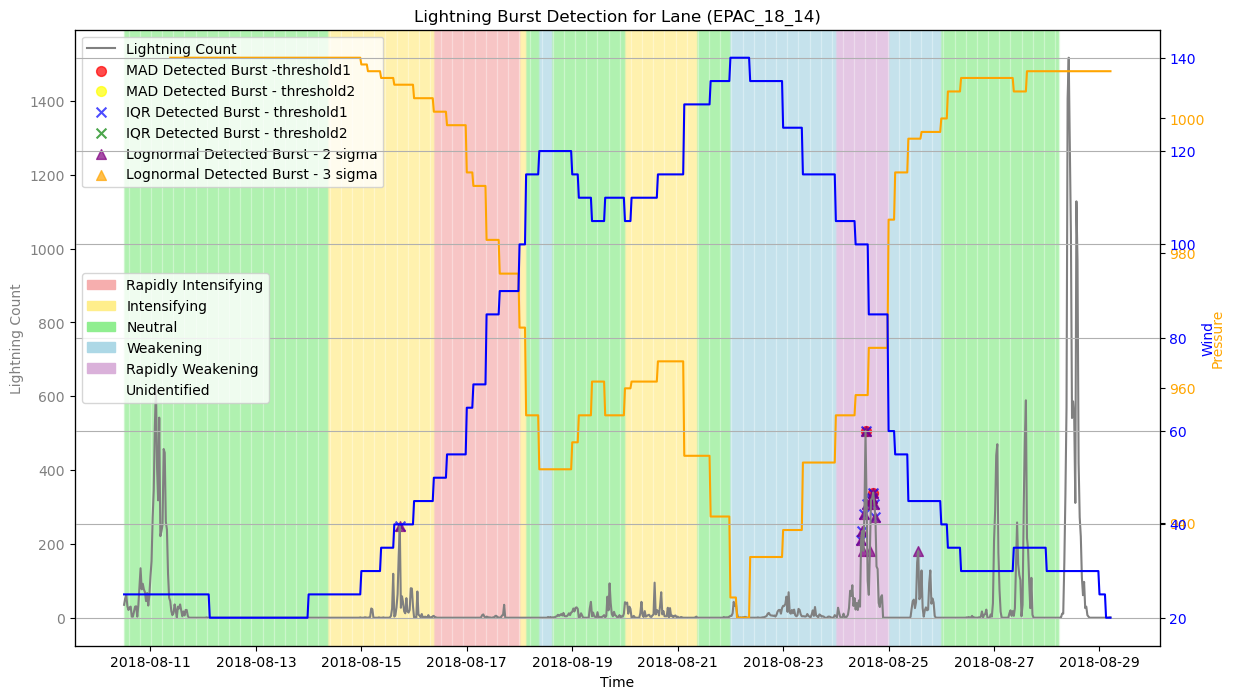

<Figure size 1000x500 with 0 Axes>

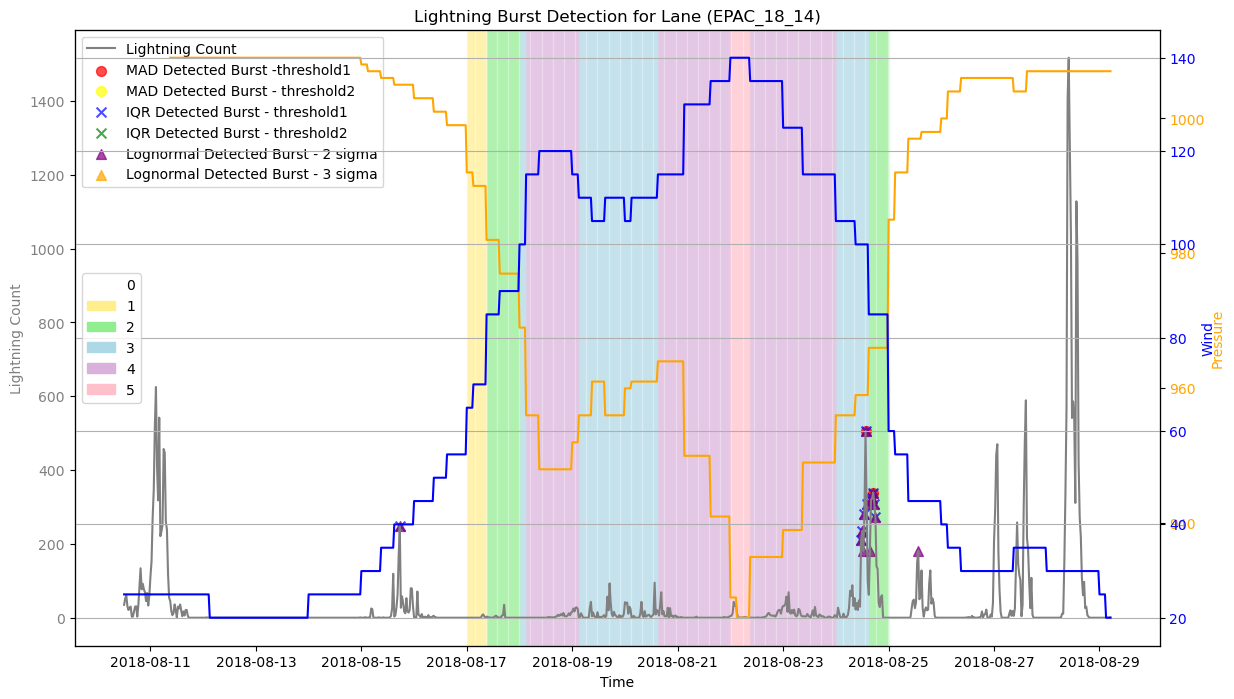

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
152  EPAC_18_14            2            0        5.792262        6.677852   

     iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
152           11            0        5.348297        6.338798            14   

     logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
152             0         5.137852         6.456639         294       0.68   

     mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
152        0.0       3.74        0.0        4.76         0.0

In [260]:
# EPAC_18_14 - Lane
cyclone_id = 'EPAC_18_14'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# Print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

<Figure size 1000x500 with 0 Axes>

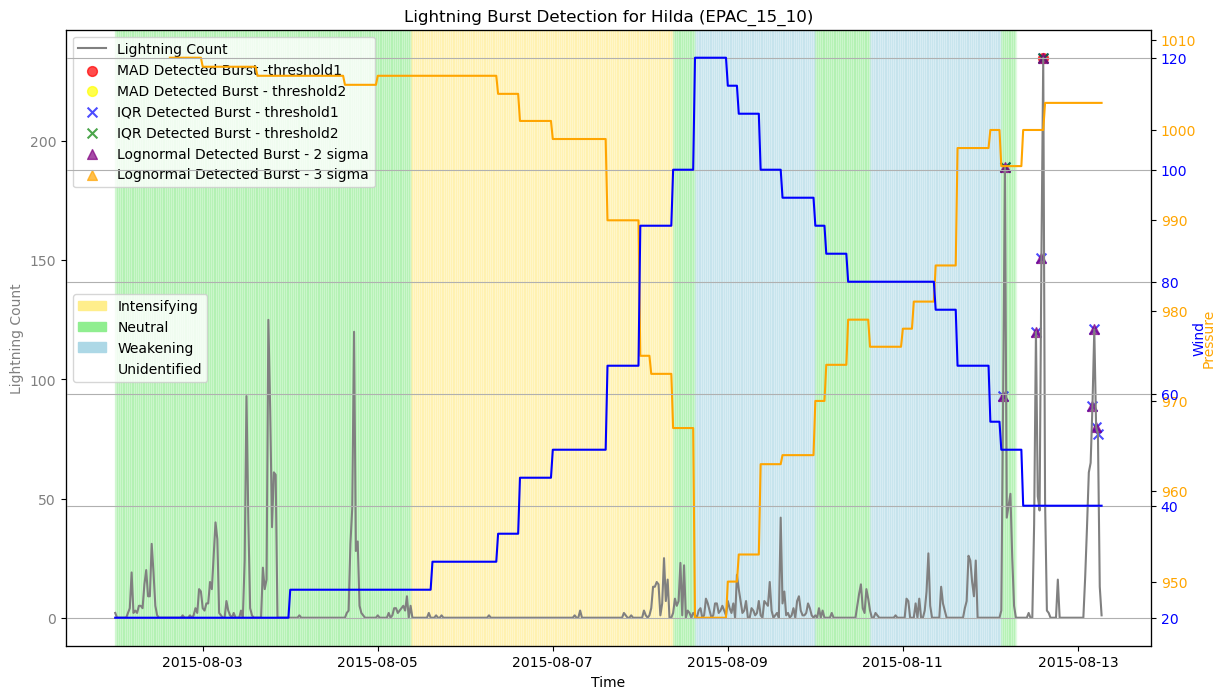

<Figure size 1000x500 with 0 Axes>

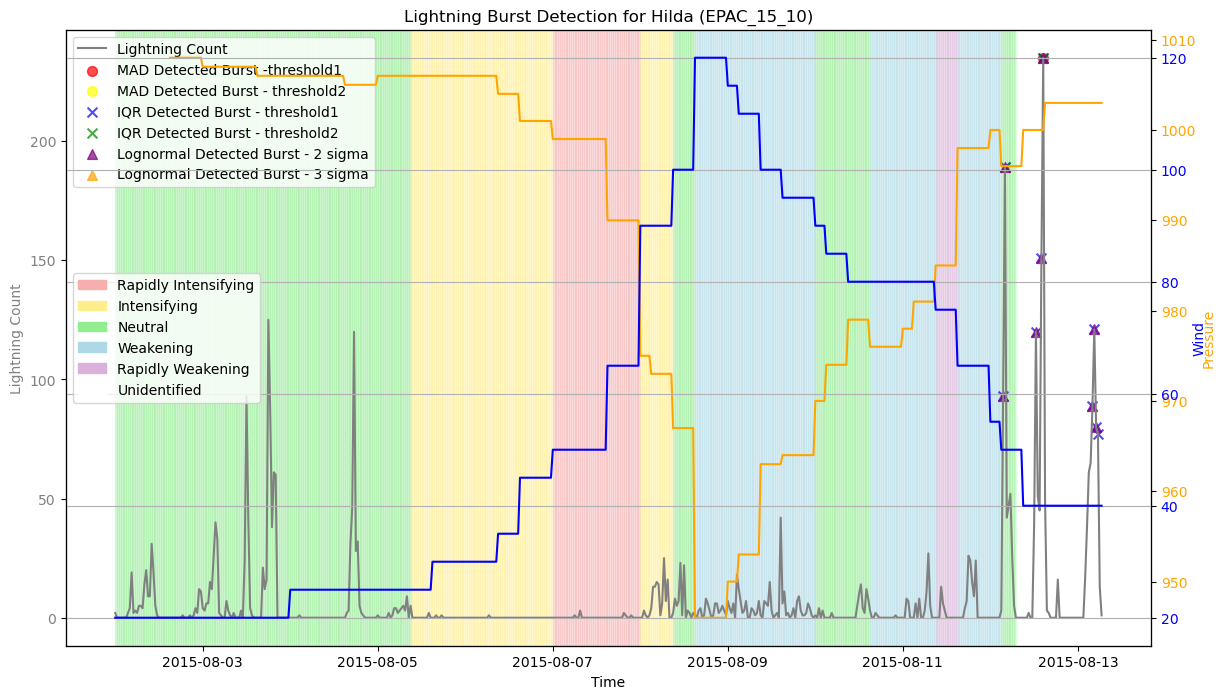

<Figure size 1000x500 with 0 Axes>

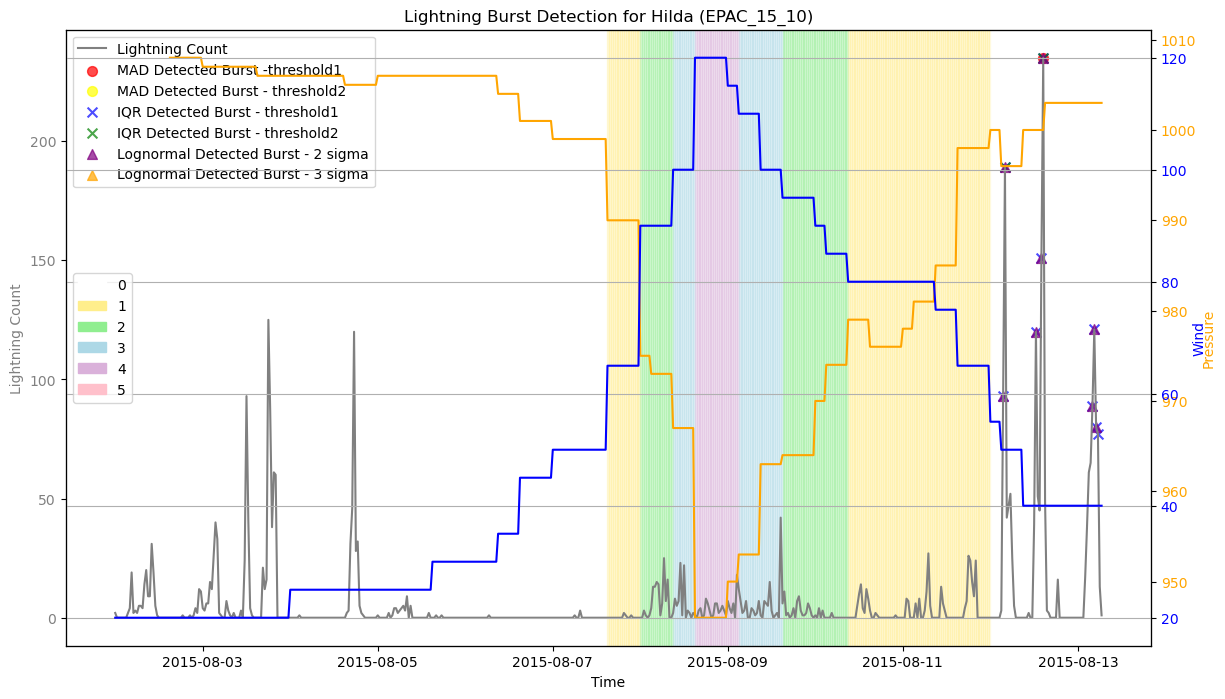

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
123  EPAC_15_10            1            0        5.252624        6.079303   

     iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
123            9            2        4.317488        5.122207             8   

     logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
123             0         4.387132         5.545262         144       0.69   

     mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
123        0.0       6.25       1.39        5.56         0.0

In [ ]:
# EPAC_15_10 - Hilda
cyclone_id = 'EPAC_15_10'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# Print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

In [269]:
# Bottom 5 least IQR1 bursts
epac_agg_result.sort_values(by="iqr1_bursts").head(5)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
91   EPAC_10_4            0            0        6.704246        7.893830   
94  EPAC_11_10            0            0       10.223271       11.946037   
95  EPAC_11_11            0            0       10.962409       12.785568   
96  EPAC_11_13            0            0        8.014107        9.295041   
98   EPAC_11_3            0            0        7.639035        8.826200   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
91            0            0        5.172376        6.190817             2   
94            0            0        8.230524        9.885795             0   
95            0            0        9.045240       10.829707             0   
96            0            0        7.162914        8.505703             1   
98            0            0        6.308359        7.398971             0   

    logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
91             0         4.679426         5.944917          93        0.0   
94             0         6.999298         8.822181         145        0.0   
95             0         7.906256         9.996606          48        0.0   
96             0         6.578627         8.297217          81        0.0   
98             0         5.590864         6.955645          29        0.0   

    mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
91        0.0        0.0        0.0        2.15         0.0  
94        0.0        0.0        0.0        0.00         0.0  
95        0.0        0.0        0.0        0.00         0.0  
96        0.0        0.0        0.0        1.23         0.0  
98        0.0        0.0        0.0        0.00         0.0

<Figure size 1000x500 with 0 Axes>

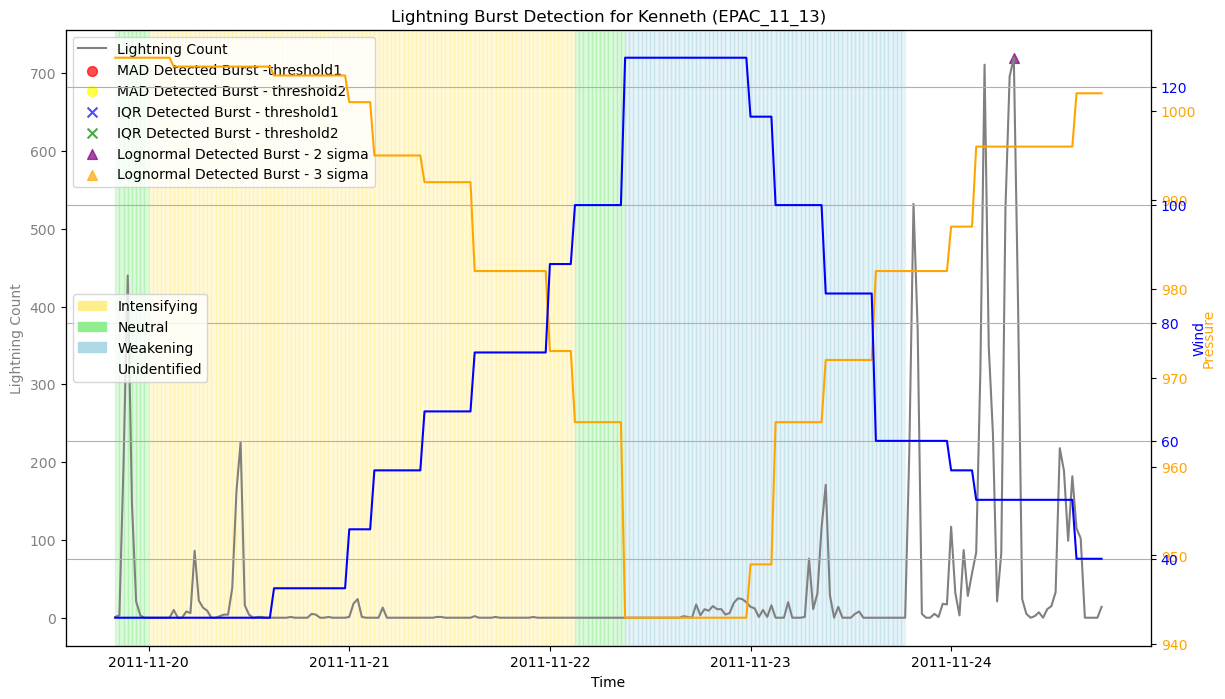

<Figure size 1000x500 with 0 Axes>

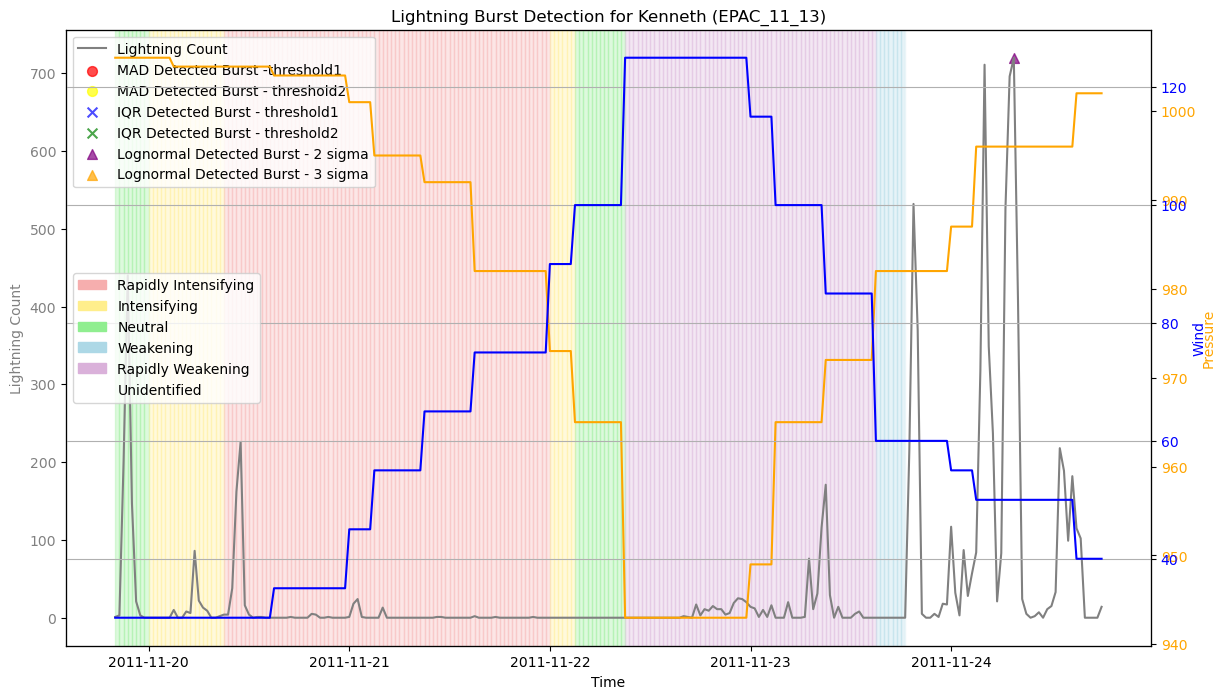

<Figure size 1000x500 with 0 Axes>

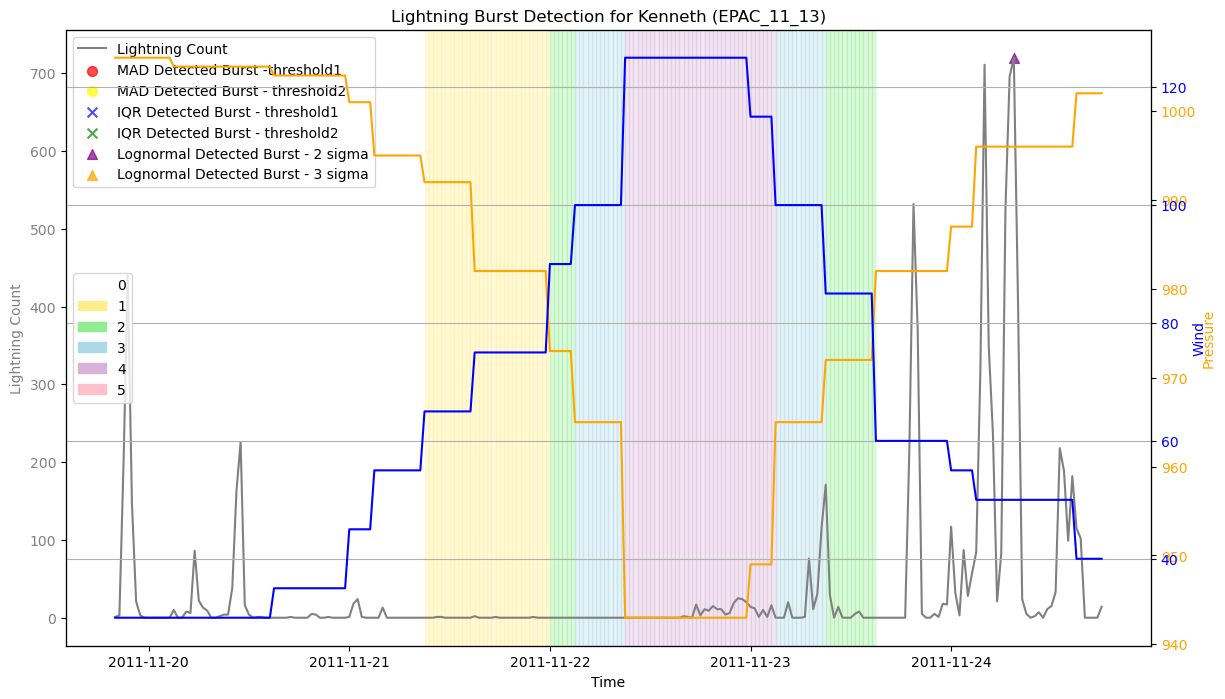

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
96  EPAC_11_13            0            0        8.014107        9.295041   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
96            0            0        7.162914        8.505703             1   

    logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
96             0         6.578627         8.297217          81        0.0   

    mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
96        0.0        0.0        0.0        1.23         0.0

In [274]:
# EPAC_11_13 - Kenneth
cyclone_id = 'EPAC_11_13'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# Print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

<Figure size 1000x500 with 0 Axes>

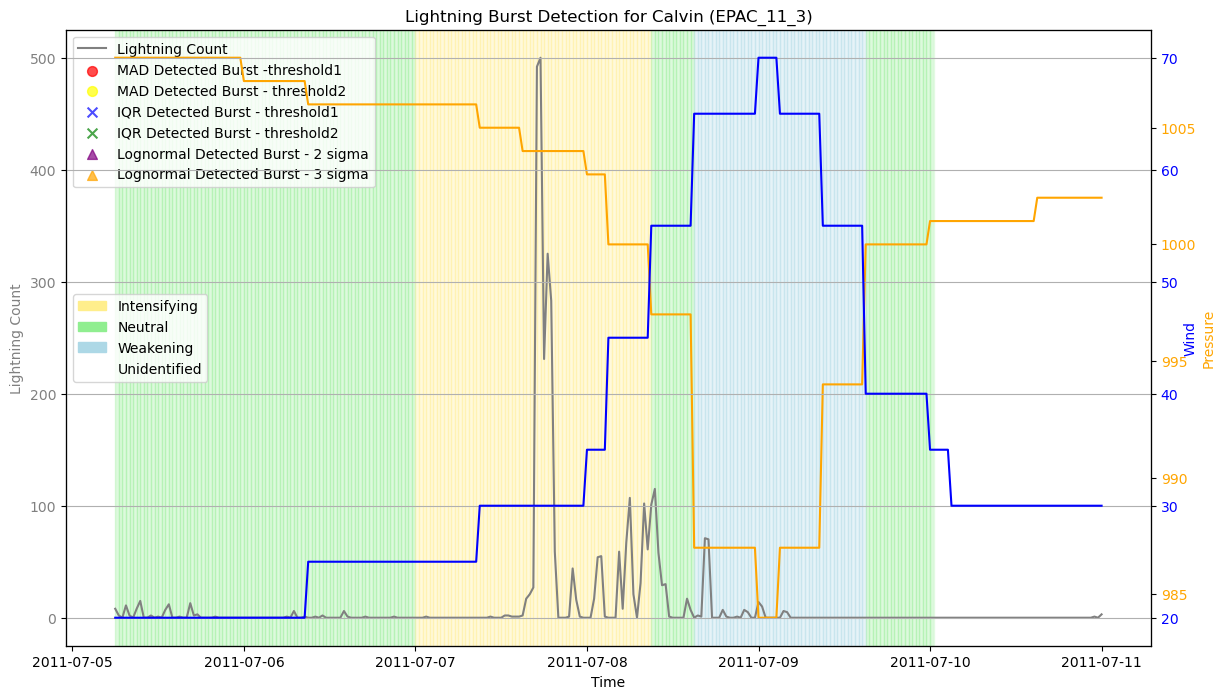

<Figure size 1000x500 with 0 Axes>

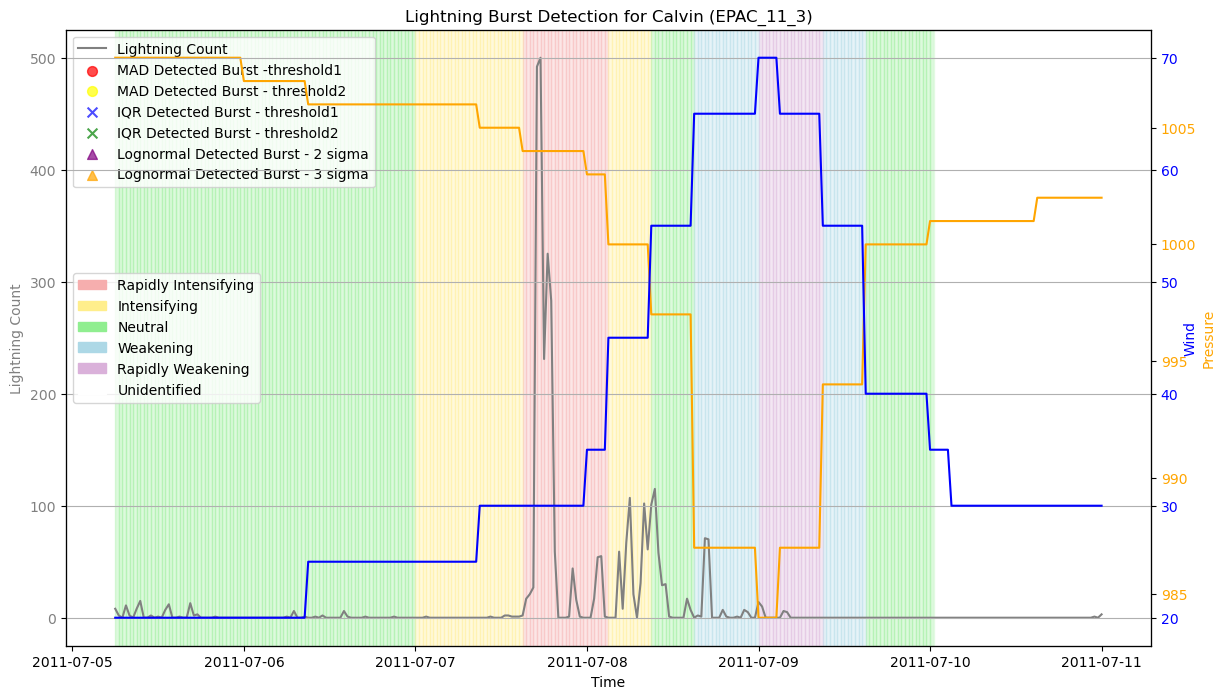

<Figure size 1000x500 with 0 Axes>

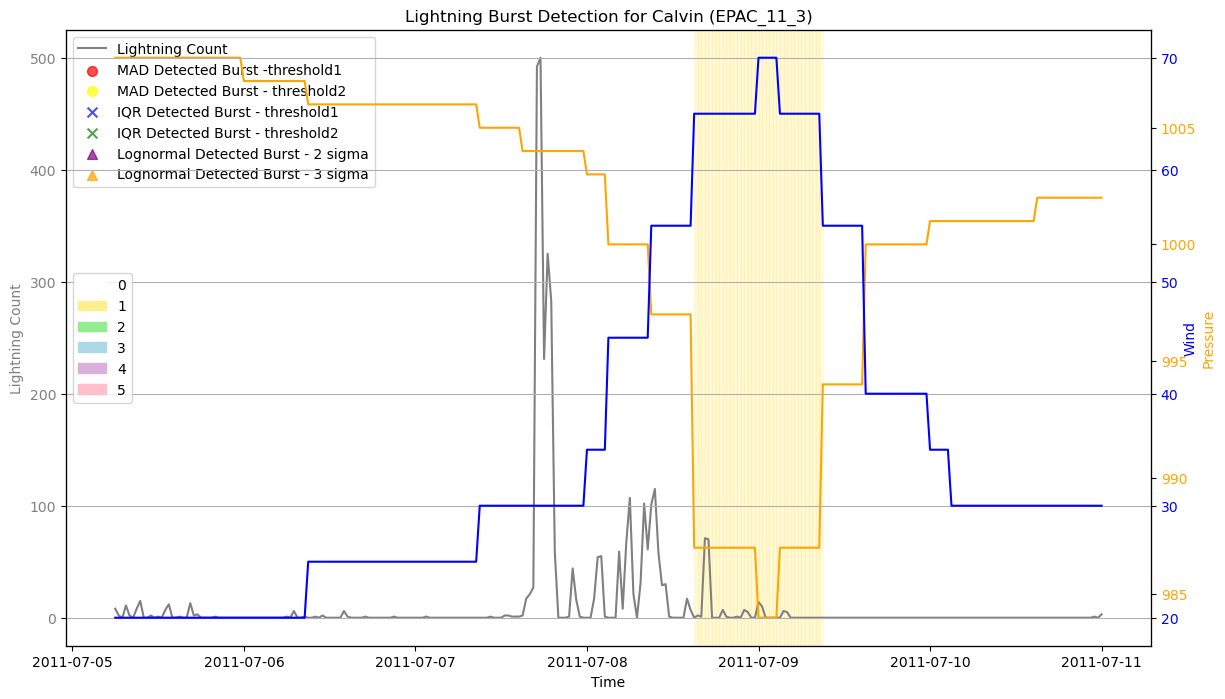

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
98  EPAC_11_3            0            0        7.639035          8.8262   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
98            0            0        6.308359        7.398971             0   

    logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
98             0         5.590864         6.955645          29        0.0   

    mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
98        0.0        0.0        0.0         0.0         0.0

In [275]:
# EPAC_11_3 - Calvin
cyclone_id = 'EPAC_11_3'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# Print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

In [263]:
# Top 5 most LOGN 2 sigma bursts
epac_agg_result.sort_values(by="logn1_bursts", ascending=False).head(5)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
152  EPAC_18_14            2            0        5.792262        6.677852   
154  EPAC_18_16           14            7        3.960585        4.548371   
123  EPAC_15_10            1            0        5.252624        6.079303   
150  EPAC_18_10            7            2        3.652740        4.163566   
132   EPAC_15_3           18           16        2.720473        3.125938   

     iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
152           11            0        5.348297        6.338798            14   
154           15            7        3.871201        4.564348             8   
123            9            2        4.317488        5.122207             8   
150            8            2        3.506558        4.108544             7   
132           12            8        3.701302        4.453341             7   

     logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
152             0         5.137852         6.456639         294       0.68   
154             3         4.218458         5.368579         170       8.24   
123             0         4.387132         5.545262         144       0.69   
150             1         3.599905         4.510039         184       3.80   
132             1         4.560759         5.986970          94      19.15   

     mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
152       0.00       3.74       0.00        4.76        0.00  
154       4.12       8.82       4.12        4.71        1.76  
123       0.00       6.25       1.39        5.56        0.00  
150       1.09       4.35       1.09        3.80        0.54  
132      17.02      12.77       8.51        7.45        1.06

In [307]:
# Bottom 5 least LOGN 2 sigma bursts - these all don't have any bursts across all 6
epac_agg_result.sort_values(by="logn1_bursts").head(5)

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
0    EPAC_14_7  Genevieve            0            0        6.340359   
10  EPAC_16_17      Paine            0            0        2.426015   
11  EPAC_18_17     Olivia            0            0        8.255033   
13  EPAC_11_11      Irwin            0            0       10.962409   
15   EPAC_16_7      Frank            0            0        7.355006   

    mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
0         7.438972            0            0        4.937563        5.861341   
10        2.772589            0            0        2.191013        2.565480   
11        9.659027            0            0        6.993015        8.394695   
13       12.785568            0            0        9.045240       10.829707   
15        8.485888            0            0        6.034524        7.129400   

    ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
0   ...             0         4.265152         5.350361          23   
10  ...             0         2.042410         2.515861           4   
11  ...             0         5.686656         7.128875          53   
13  ...             0         7.906256         9.996606          48   
15  ...             0         5.904155         7.421015          66   

    mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0         0.0        0.0        0.0        0.0         0.0         0.0  
10        0.0        0.0        0.0        0.0         0.0         0.0  
11        0.0        0.0        0.0        0.0         0.0         0.0  
13        0.0        0.0        0.0        0.0         0.0         0.0  
15        0.0        0.0        0.0        0.0         0.0         0.0  

[5 rows x 21 columns]

look at categories

look at threshold overlap - how to quantify?

We then create a summary for the weaker categories and create an initial basin-category threshold defined as 2 standard deviations + the mean or median.

In [85]:
# Get mean and 2 standard dev - 0-2 categories
epac_weak_cat_summary = create_basin_summary(epac_weak_cat_lightning, "0-2", "EPAC")
epac_weak_cat_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  6.527584  2.173121  6.668218  0.693147   
1  EPAC            0-2      mad2  7.576961  2.544147  7.612680  0.693147   
2  EPAC            0-2      iqr1  5.592081  1.602030  5.703782  0.693147   
3  EPAC            0-2      iqr2  6.660095  1.929695  6.775983  0.693147   
4  EPAC            0-2     logn1  5.233589  1.270183  5.285497  0.693147   
5  EPAC            0-2     logn2  6.606666  1.598939  6.761672  0.693147   

         Max  Basin-Category Threshold (Mean-Based)  \
0  10.962409                              10.873827   
1  12.785568                              12.665256   
2   9.045240                               8.796140   
3  10.829707                              10.519485   
4   7.998327                               7.773955   
5   9.996606                               9.804544   

   Basin-Category Threshold (Median-Based)  Burst Count  Timebin Count  \
0                                11.014461          119           3850   
1                                12.700975           40           3850   
2                                 8.907842           82           3850   
3                                10.635373           52           3850   
4                                 7.825864          141           3850   
5                                 9.959551            6           3850   

   Burst Percentage  
0              3.09  
1              1.04  
2              2.13  
3              1.35  
4              3.66  
5              0.16

In [ ]:
# Most MAD1 bursts for 0-2 category
epac_weak_agg_result = create_agg_result(epac_weak_cat_lightning)
epac_weak_agg_result.sort_values(by="mad1_bursts", ascending=False).head(5)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
41   EPAC_15_3           18           16        2.720473        3.125938   
63  EPAC_18_16           11            7        3.960585        4.548371   
24   EPAC_13_5            7            5        2.720473        3.125938   
80   EPAC_20_8            5            5        1.706810        1.909543   
45  EPAC_16_14            5            0        6.120542        7.101371   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
41           12            8        3.701302        4.453341             7   
63           11            7        3.871201        4.564348             8   
24            4            2        3.465736        4.158883             2   
80            1            0        2.414157        2.844409             1   
45            5            0        6.191953        7.337582             5   

    logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
41             1         4.560759         5.986970          94      19.15   
63             3         4.218458         5.368579          65      16.92   
24             0         4.205395         5.465820          29      24.14   
80             0         2.379402         2.990767          28      17.86   
45             0         6.198040         7.920992          62       8.06   

    mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
41      17.02      12.77       8.51        7.45        1.06  
63      10.77      16.92      10.77       12.31        4.62  
24      17.24      13.79       6.90        6.90        0.00  
80      17.86       3.57       0.00        3.57        0.00  
45       0.00       8.06       0.00        8.06        0.00

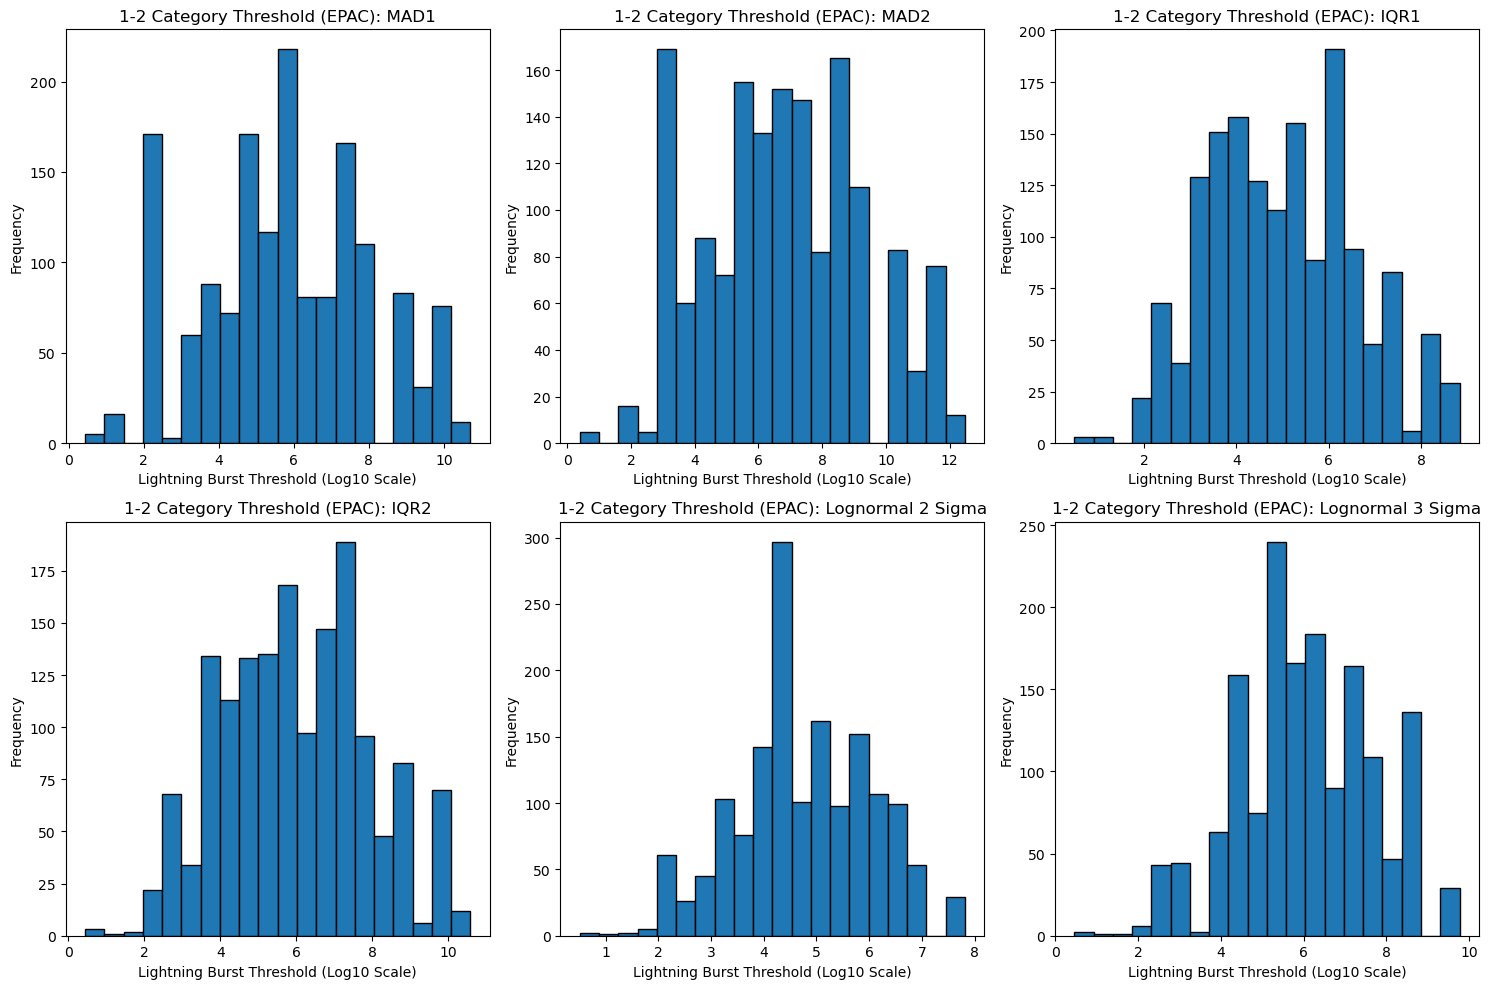

In [159]:
# Plot threshold value distributions for 1-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_weak_cat_alt_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"1-2 Category Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

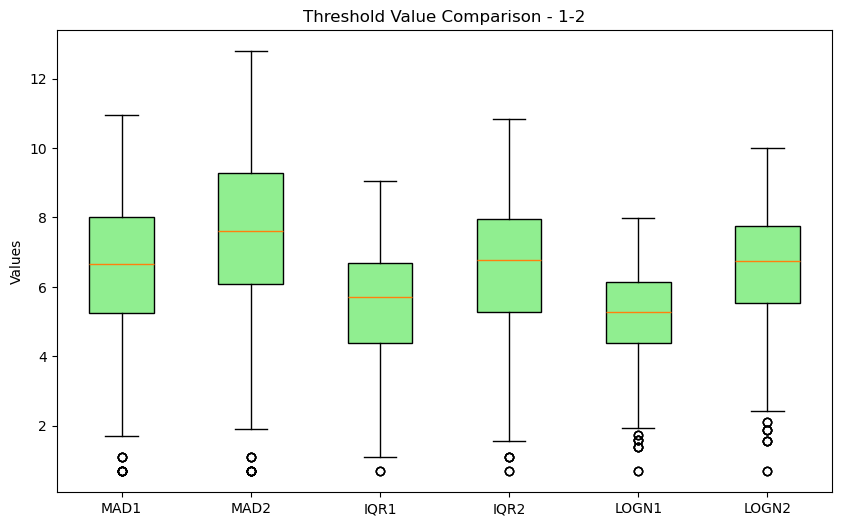

In [160]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(epac_weak_cat_lightning, "1-2", ax=None)

In [161]:
# Get mean and 2 standard dev - 1-2 categories
epac_weak_cat_alt_summary = create_basin_summary(epac_weak_cat_alt_lightning, "1-2", "EPAC")
epac_weak_cat_alt_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            1-2      mad1  6.119381  2.165851  6.063117  0.693147   
1  EPAC            1-2      mad2  7.104991  2.543813  7.004327  0.693147   
2  EPAC            1-2      iqr1  5.246400  1.588451  5.172376  0.693147   
3  EPAC            1-2      iqr2  6.251145  1.922062  6.190817  0.693147   
4  EPAC            1-2     logn1  4.931581  1.255843  4.967780  0.693147   
5  EPAC            1-2     logn2  6.227157  1.591641  6.221871  0.693147   

         Max  Basin-Category Threshold (Mean-Based)  \
0  10.962409                              10.451083   
1  12.785568                              12.192618   
2   9.045240                               8.423303   
3  10.829707                              10.095269   
4   7.998327                               7.443267   
5   9.996606                               9.410440   

   Basin-Category Threshold (Median-Based)  Burst Count  Timebin Count  \
0                                10.394819           42           1561   
1                                12.091953           15           1561   
2                                 8.349279           34           1561   
3                                10.034941           25           1561   
4                                 7.479467           51           1561   
5                                 9.405154            2           1561   

   Burst Percentage  
0              2.69  
1              0.96  
2              2.18  
3              1.60  
4              3.27  
5              0.13

In [248]:
# Most MAD1 bursts for 1-2 category
epac_weak_alt_agg_result = create_agg_result(epac_weak_cat_alt_lightning)
epac_weak_alt_agg_result.sort_values(by="mad1_bursts", ascending=False).head(5)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
39   EPAC_15_3           12           11        2.720473        3.125938   
57  EPAC_18_10            4            2        3.652740        4.163566   
13  EPAC_12_16            3            2        2.720473        3.125938   
78   EPAC_20_8            3            3        1.706810        1.909543   
22   EPAC_13_5            2            1        2.720473        3.125938   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
39            9            8        3.701302        4.453341             7   
57            5            2        3.506558        4.108544             4   
13            2            1        2.967447        3.536022             2   
78            0            0        2.414157        2.844409             0   
22            1            0        3.465736        4.158883             0   

    logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
39             1         4.560759         5.986970          33      36.36   
57             1         3.599905         4.510039          55       7.27   
13             0         3.138200         3.991650          20      15.00   
78             0         2.379402         2.990767          16      18.75   
22             0         4.205395         5.465820          16      12.50   

    mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
39      33.33      27.27      24.24       21.21        3.03  
57       3.64       9.09       3.64        7.27        1.82  
13      10.00      10.00       5.00       10.00        0.00  
78      18.75       0.00       0.00        0.00        0.00  
22       6.25       6.25       0.00        0.00        0.00

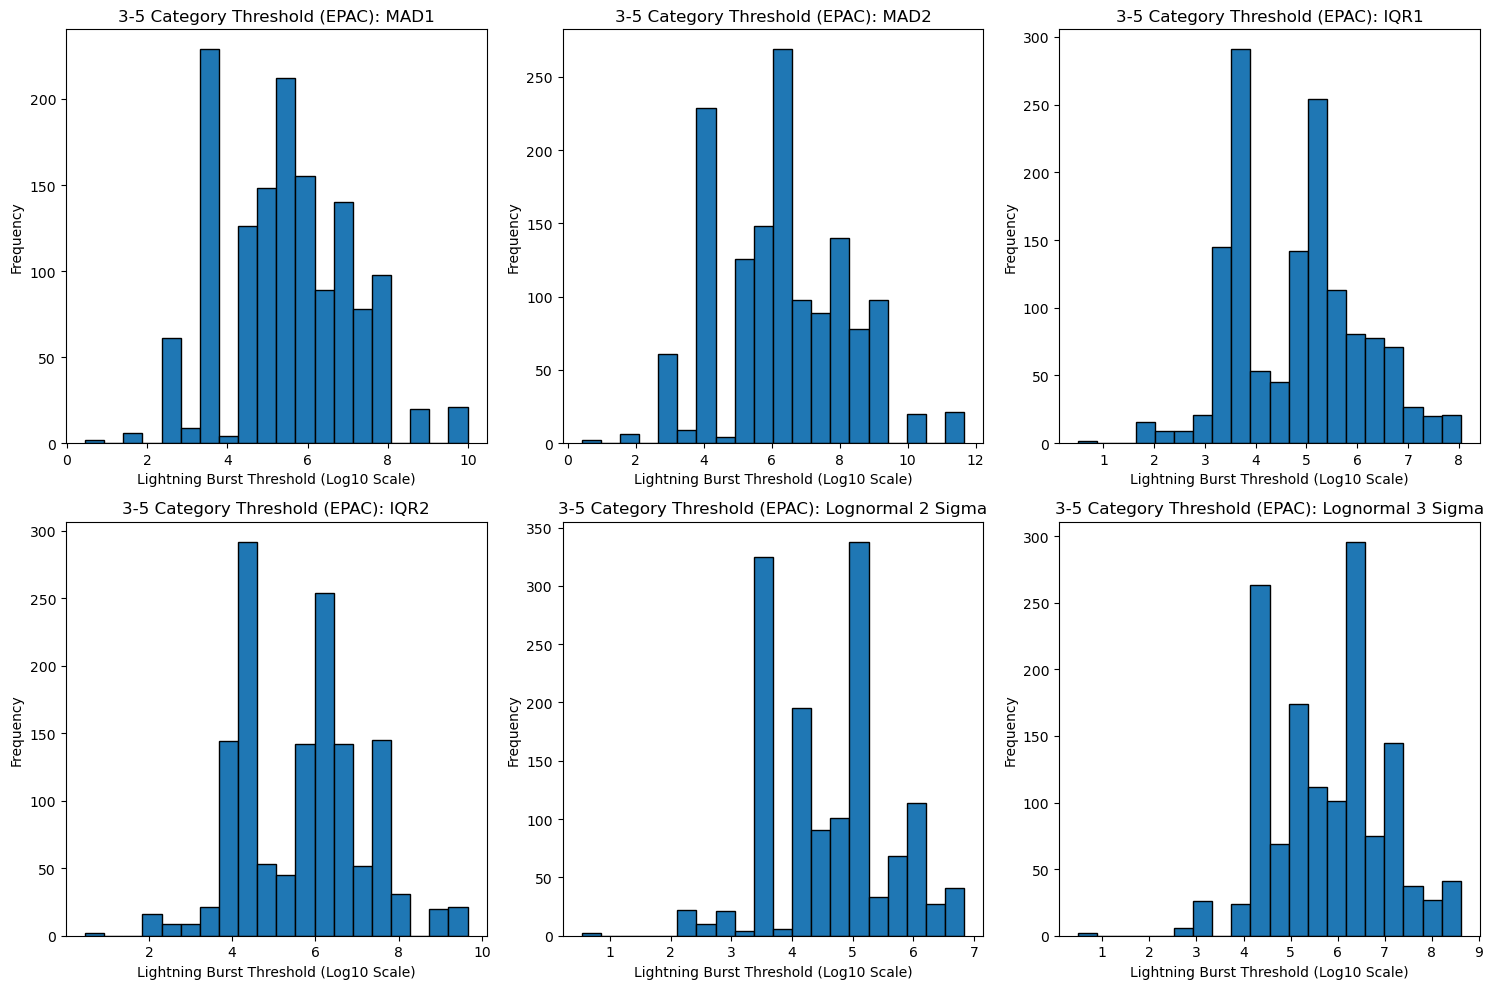

In [91]:
# Plot threshold value distributions for 3-5 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_strong_cat_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"3-5 Category Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

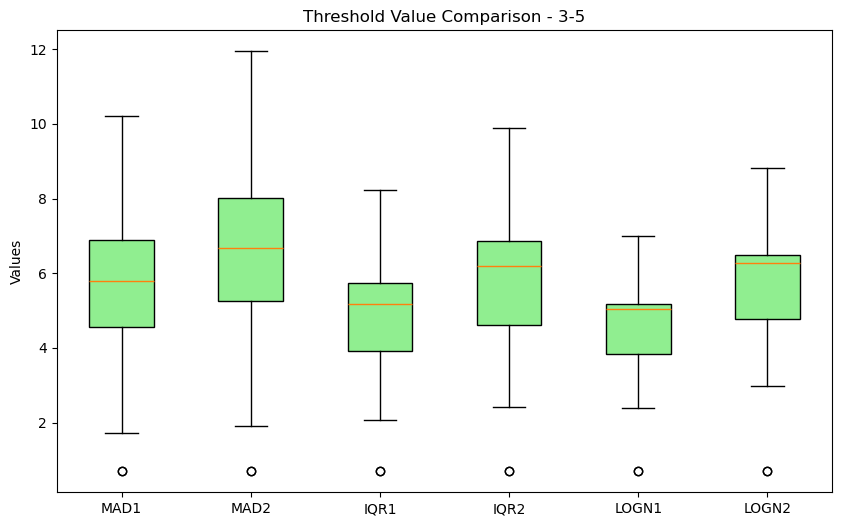

In [88]:
# Threshold value distribution - boxplot
plot_threshold_boxplot(epac_strong_cat_lightning, "3-5", ax=None)

In [87]:
# Get mean and 2 standard dev - 3-5 categories
epac_strong_cat_summary = create_basin_summary(epac_strong_cat_lightning, "3-5", "EPAC")
epac_strong_cat_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            3-5      mad1  5.719598  1.635318  5.792262  0.693147   
1  EPAC            3-5      mad2  6.603652  1.907559  6.677852  0.693147   
2  EPAC            3-5      iqr1  4.990127  1.245536  5.172376  0.693147   
3  EPAC            3-5      iqr2  5.898325  1.480719  6.190817  0.693147   
4  EPAC            3-5     logn1  4.755955  0.985998  5.033171  0.693147   
5  EPAC            3-5     logn2  5.963515  1.226997  6.285003  0.693147   

         Max  Basin-Category Threshold (Mean-Based)  \
0  10.223271                               8.990233   
1  11.946037                              10.418769   
2   8.230524                               7.481199   
3   9.885795                               8.859763   
4   6.999298                               6.727951   
5   8.822181                               8.417509   

   Basin-Category Threshold (Median-Based)  Burst Count  Timebin Count  \
0                                 9.062898           13           1398   
1                                10.492969            0           1398   
2                                 7.663448           11           1398   
3                                 9.152255            1           1398   
4                                 7.005167           16           1398   
5                                 8.738997            0           1398   

   Burst Percentage  
0              0.93  
1              0.00  
2              0.79  
3              0.07  
4              1.14  
5              0.00

In [249]:
# Most MAD1 bursts for 3-5 category
epac_strong_agg_result = create_agg_result(epac_strong_cat_lightning)
epac_strong_agg_result.sort_values(by="mad1_bursts", ascending=False).head(5)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
27  EPAC_18_16            3            0        3.960585        4.548371   
25  EPAC_18_10            3            0        3.652740        4.163566   
14  EPAC_15_13            2            0        2.720473        3.125938   
23   EPAC_16_3            1            0        2.720473        3.125938   
40   EPAC_20_8            1            1        1.706810        1.909543   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
27            4            0        3.871201        4.564348             0   
25            3            0        3.506558        4.108544             3   
14            0            0        3.524627        4.232497             0   
23            0            0        3.198673        3.825055             0   
40            0            0        2.414157        2.844409             1   

    logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
27             0         4.218458         5.368579         105       2.86   
25             0         3.599905         4.510039         124       2.42   
14             0         3.161867         4.026614          20      10.00   
23             0         3.699117         4.749321          10      10.00   
40             0         2.379402         2.990767           6      16.67   

    mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
27       0.00       3.81        0.0        0.00         0.0  
25       0.00       2.42        0.0        2.42         0.0  
14       0.00       0.00        0.0        0.00         0.0  
23       0.00       0.00        0.0        0.00         0.0  
40      16.67       0.00        0.0       16.67         0.0

<Figure size 1000x500 with 0 Axes>

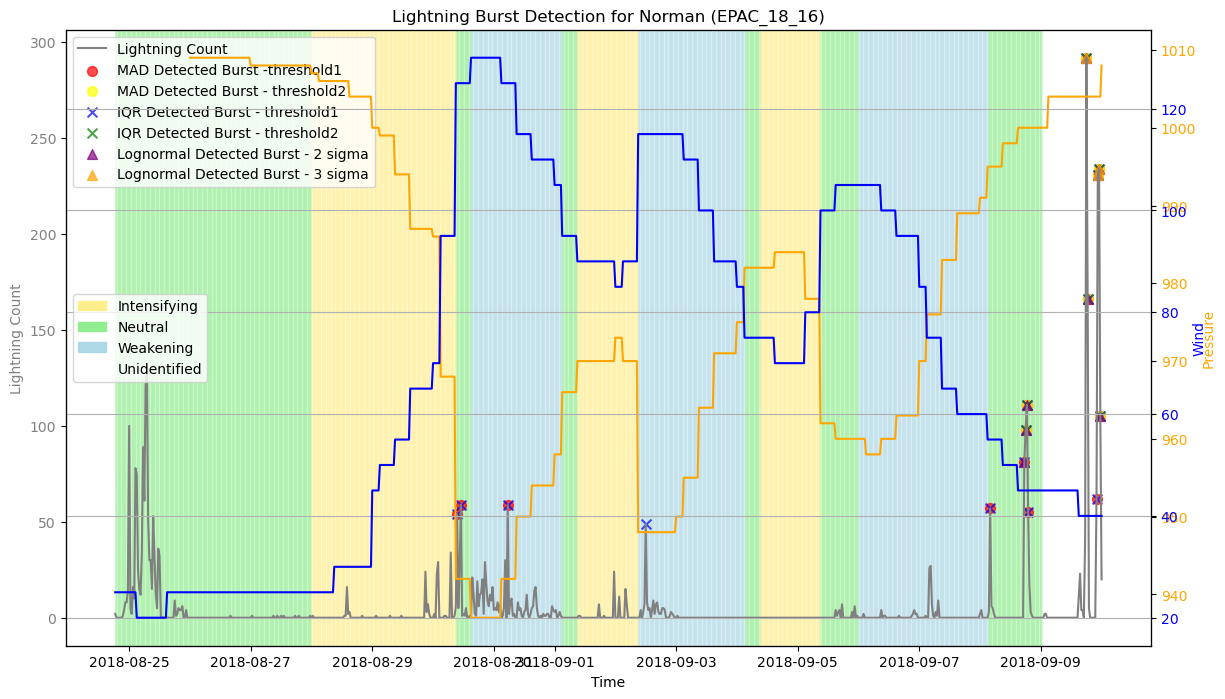

<Figure size 1000x500 with 0 Axes>

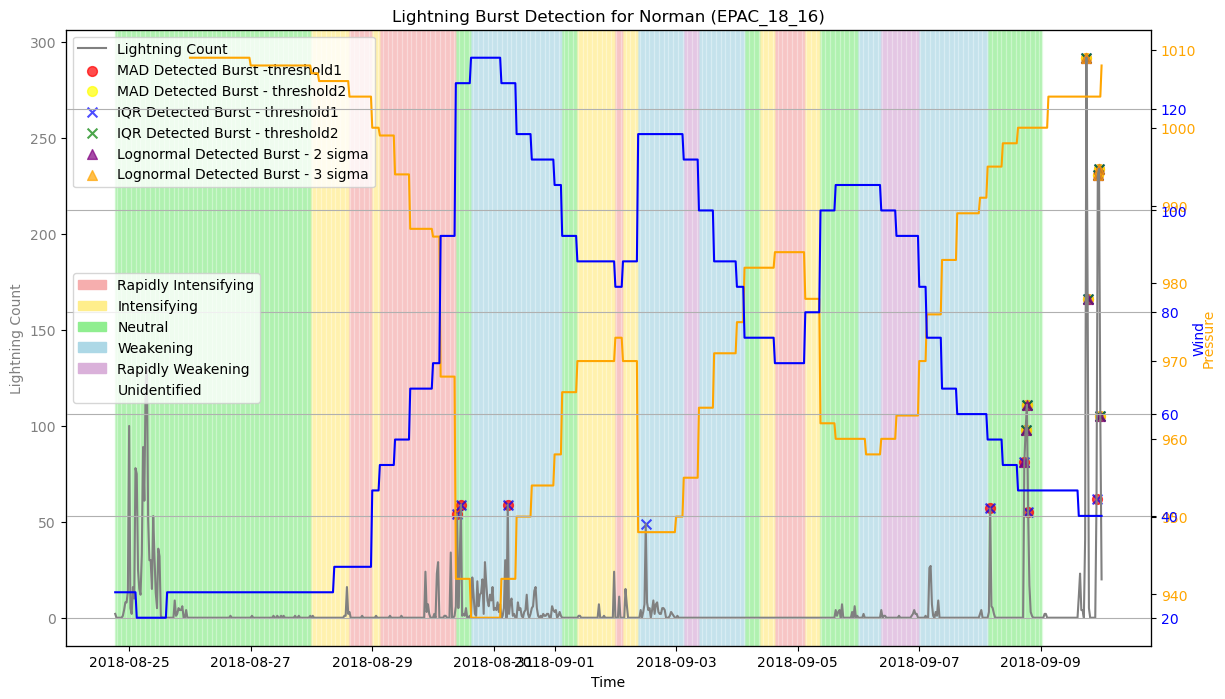

<Figure size 1000x500 with 0 Axes>

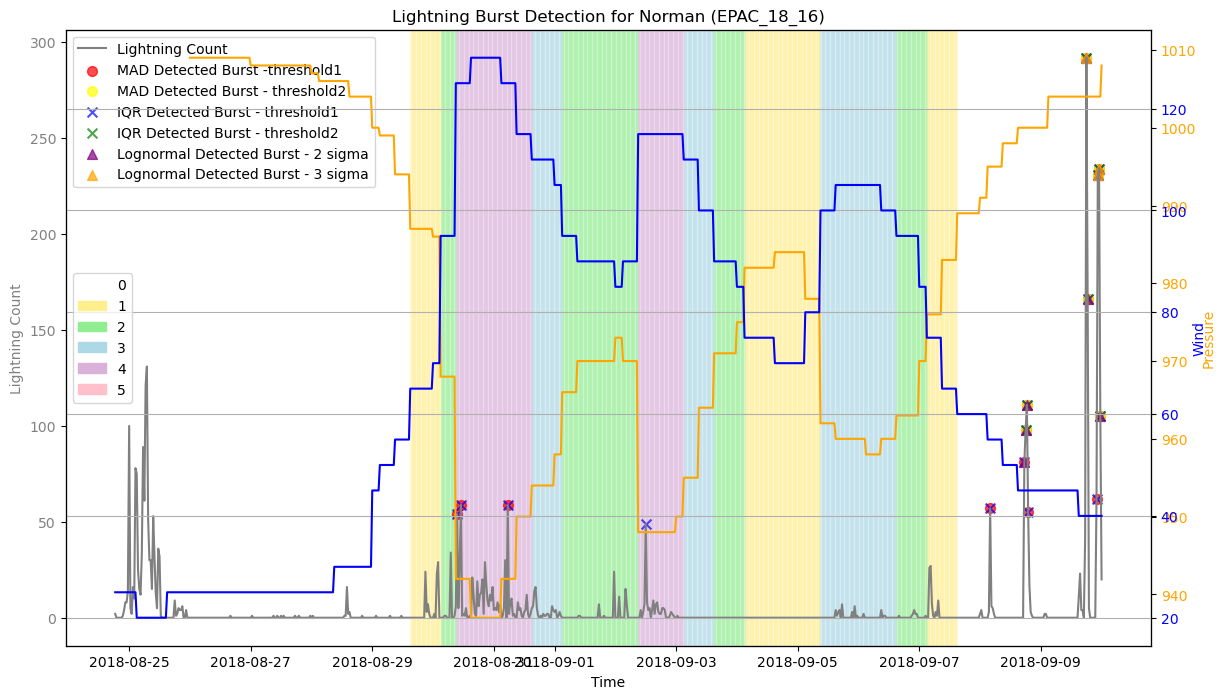

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
154  EPAC_18_16           14            7        3.960585        4.548371   

     iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
154           15            7        3.871201        4.564348             8   

     logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
154             3         4.218458         5.368579         170       8.24   

     mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
154       4.12       8.82       4.12        4.71        1.76

In [250]:
# EPAC_18_16 - Norman
cyclone_id = 'EPAC_18_16'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# Print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

<Figure size 1000x500 with 0 Axes>

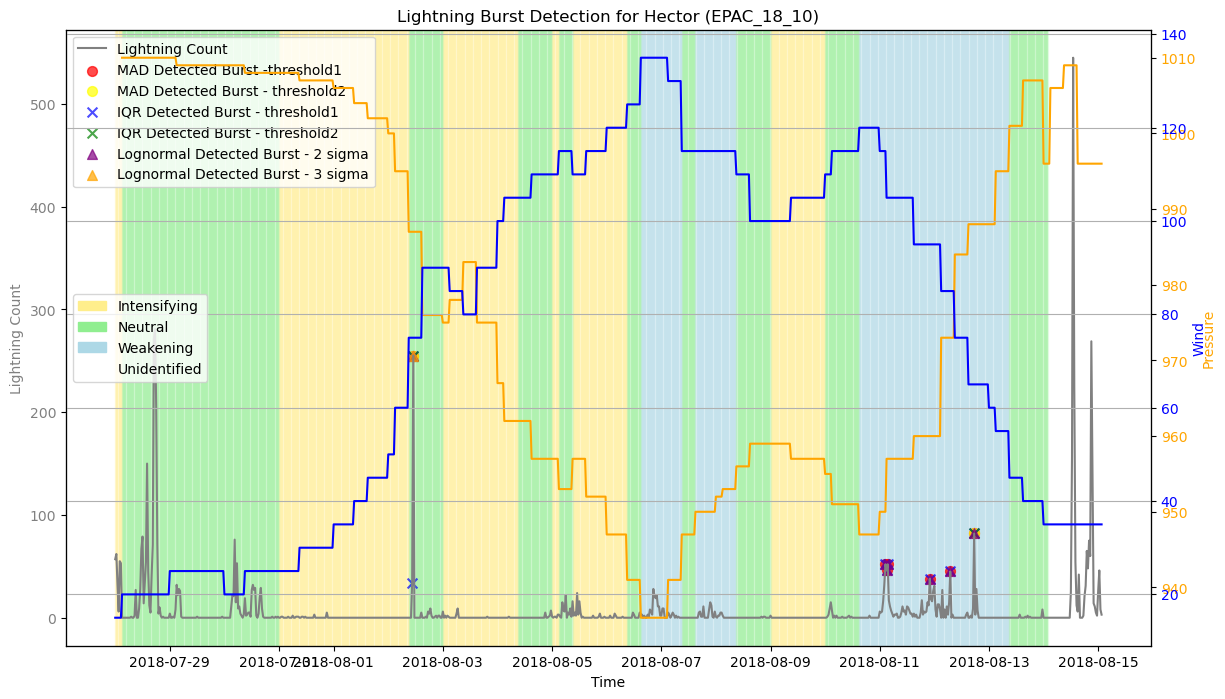

<Figure size 1000x500 with 0 Axes>

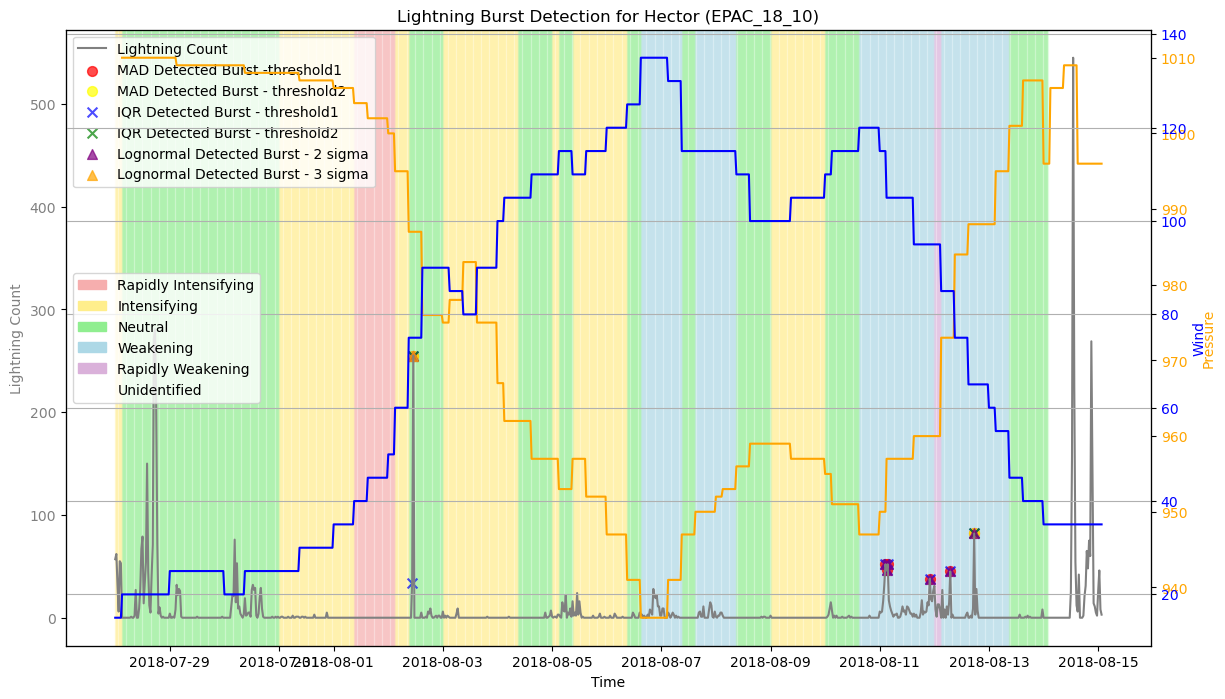

<Figure size 1000x500 with 0 Axes>

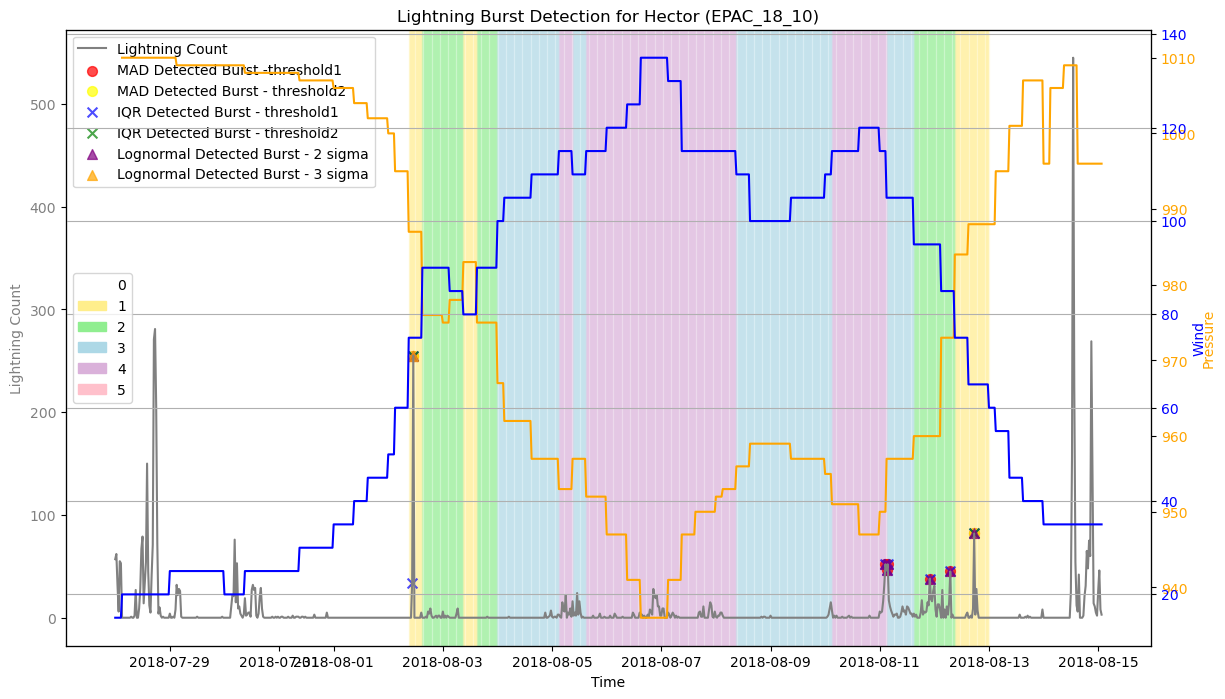

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
150  EPAC_18_10            7            2         3.65274        4.163566   

     iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
150            8            2        3.506558        4.108544             7   

     logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
150             1         3.599905         4.510039         184        3.8   

     mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
150       1.09       4.35       1.09         3.8        0.54

In [ ]:
# EPAC_18_10 - Hector
cyclone_id = 'EPAC_18_10'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# Print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

In [254]:
# Most IQR1 bursts for 3-5 category
epac_strong_agg_result = create_agg_result(epac_strong_cat_lightning)
epac_strong_agg_result.sort_values(by="iqr1_bursts", ascending=False).head(5)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
26  EPAC_18_14            1            0        5.792262        6.677852   
27  EPAC_18_16            3            0        3.960585        4.548371   
25  EPAC_18_10            3            0        3.652740        4.163566   
22  EPAC_16_20            0            0        5.123547        5.917957   
4    EPAC_11_4            0            0        2.720473        3.125938   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
26            5            0        5.348297        6.338798             6   
27            4            0        3.871201        4.564348             0   
25            3            0        3.506558        4.108544             3   
22            1            0        4.031286        4.764455             1   
4             0            0        2.967447        3.536022             0   

    logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
26             0         5.137852         6.456639         212       0.47   
27             0         4.218458         5.368579         105       2.86   
25             0         3.599905         4.510039         124       2.42   
22             0         3.842232         4.783404          57       0.00   
4              0         2.750993         3.437452          10       0.00   

    mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
26        0.0       2.36        0.0        2.83         0.0  
27        0.0       3.81        0.0        0.00         0.0  
25        0.0       2.42        0.0        2.42         0.0  
22        0.0       1.75        0.0        1.75         0.0  
4         0.0       0.00        0.0        0.00         0.0

<Figure size 1000x500 with 0 Axes>

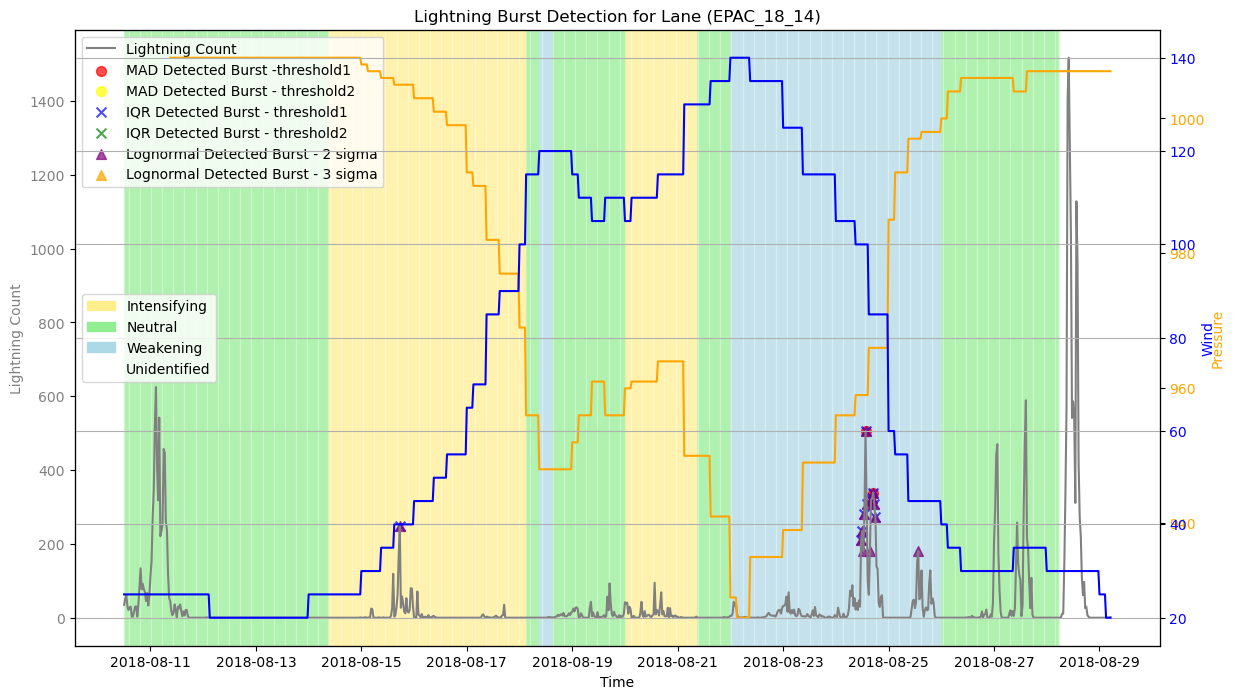

<Figure size 1000x500 with 0 Axes>

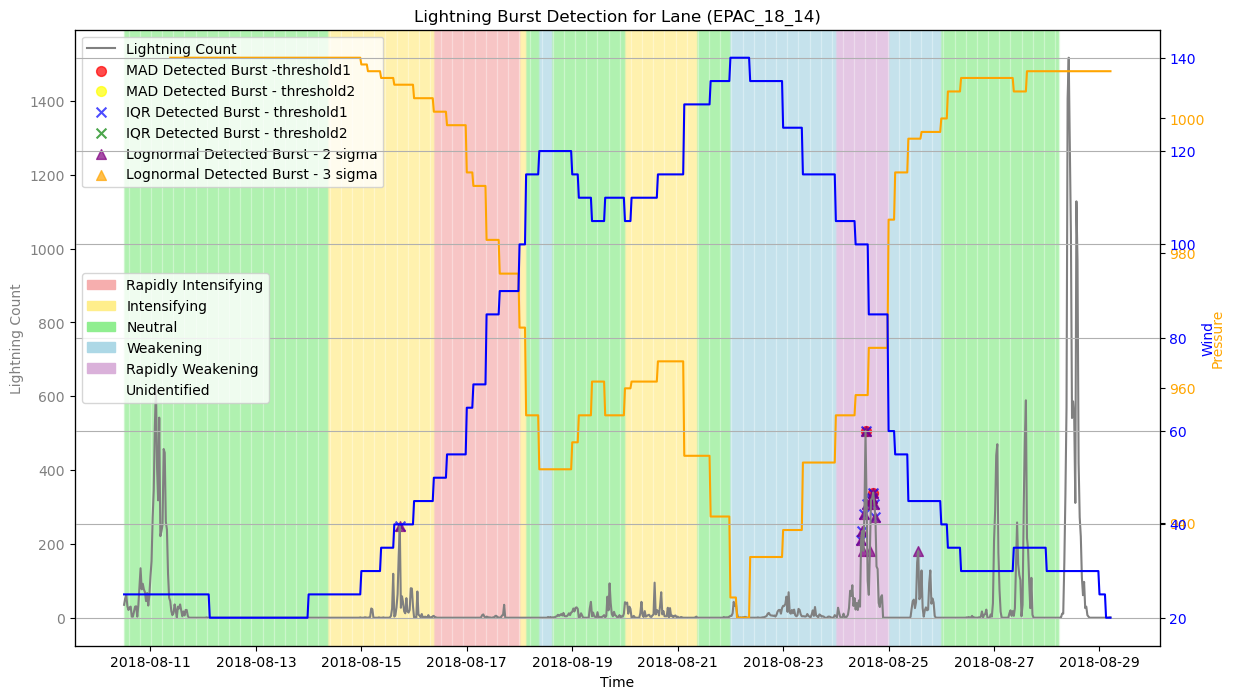

<Figure size 1000x500 with 0 Axes>

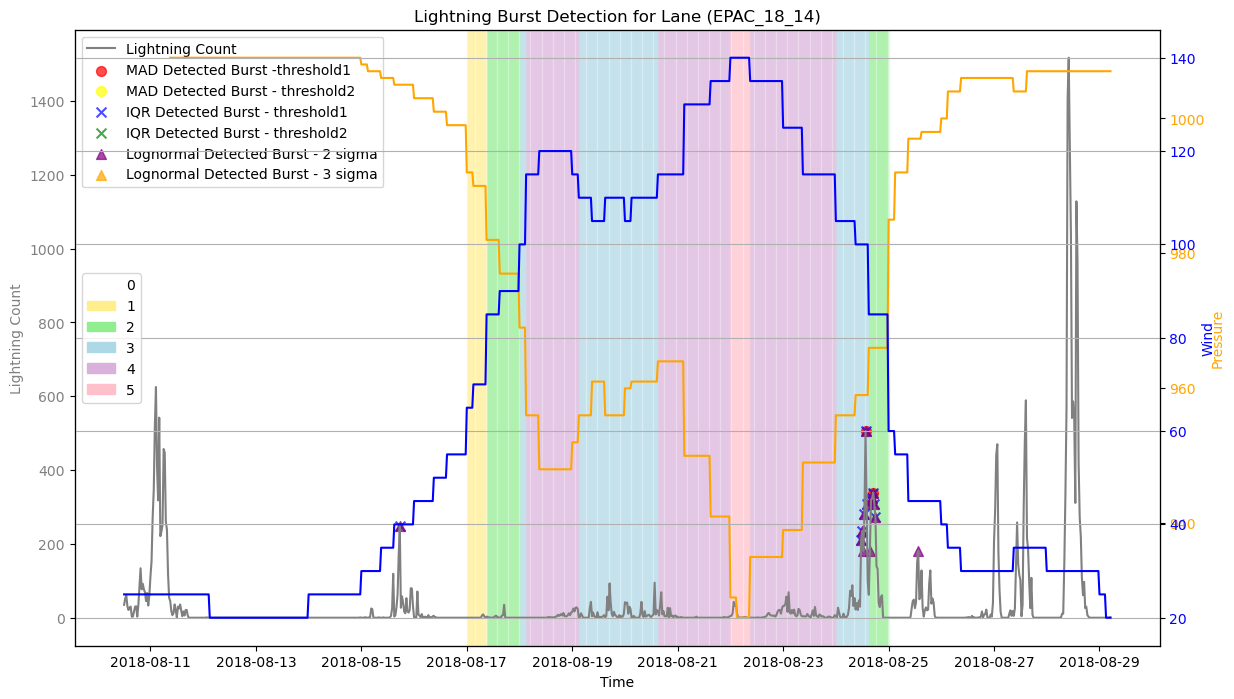

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
152  EPAC_18_14            2            0        5.792262        6.677852   

     iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
152           11            0        5.348297        6.338798            14   

     logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
152             0         5.137852         6.456639         294       0.68   

     mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
152        0.0       3.74        0.0        4.76         0.0

In [255]:
# EPAC_18_14 - Lane
cyclone_id = 'EPAC_18_14'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# Print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

In [256]:
# Most LOGN 2 sigma bursts for 3-5 category
epac_strong_agg_result = create_agg_result(epac_strong_cat_lightning)
epac_strong_agg_result.sort_values(by="logn1_bursts", ascending=False).head(5)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
26  EPAC_18_14            1            0        5.792262        6.677852   
25  EPAC_18_10            3            0        3.652740        4.163566   
6    EPAC_11_9            0            0        4.564348        5.257495   
18  EPAC_15_22            0            0        7.254008        8.374363   
22  EPAC_16_20            0            0        5.123547        5.917957   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
26            5            0        5.348297        6.338798             6   
25            3            0        3.506558        4.108544             3   
6             0            0        3.911222        4.614375             2   
18            0            0        5.742674        6.775983             1   
22            1            0        4.031286        4.764455             1   

    logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
26             0         5.137852         6.456639         212       0.47   
25             0         3.599905         4.510039         124       2.42   
6              0         3.668929         4.558539         119       0.00   
18             0         5.185809         6.443135          54       0.00   
22             0         3.842232         4.783404          57       0.00   

    mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
26        0.0       2.36        0.0        2.83         0.0  
25        0.0       2.42        0.0        2.42         0.0  
6         0.0       0.00        0.0        1.68         0.0  
18        0.0       0.00        0.0        1.85         0.0  
22        0.0       1.75        0.0        1.75         0.0

<Figure size 1000x500 with 0 Axes>

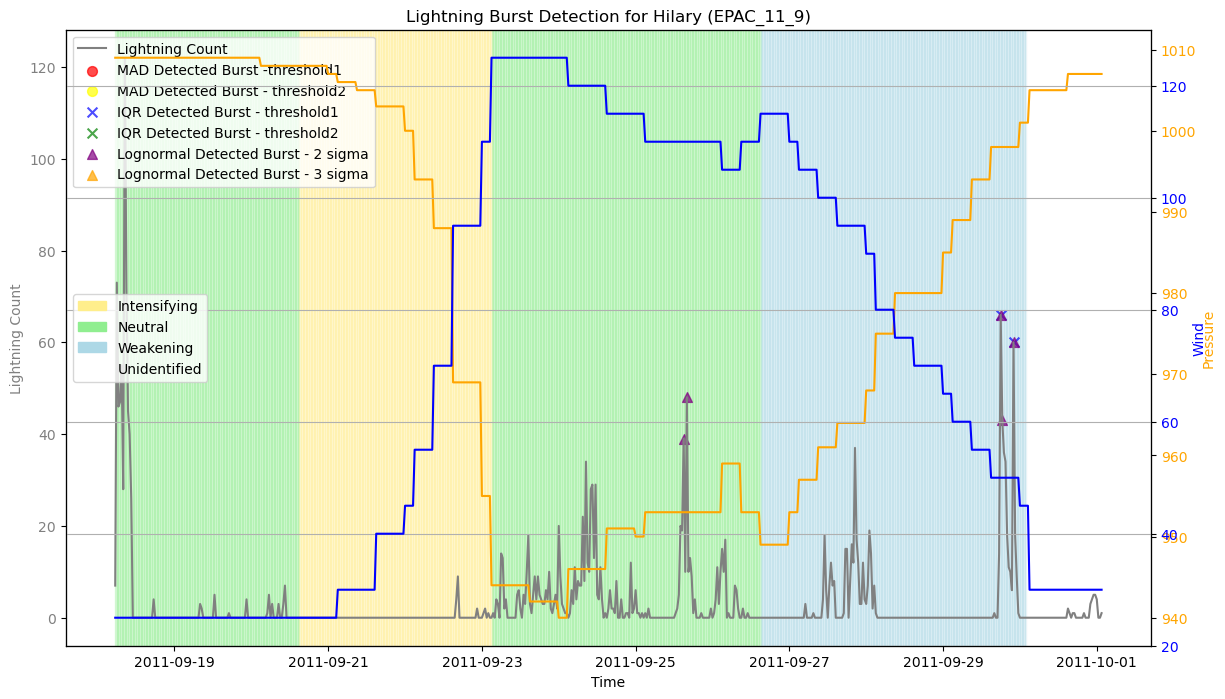

<Figure size 1000x500 with 0 Axes>

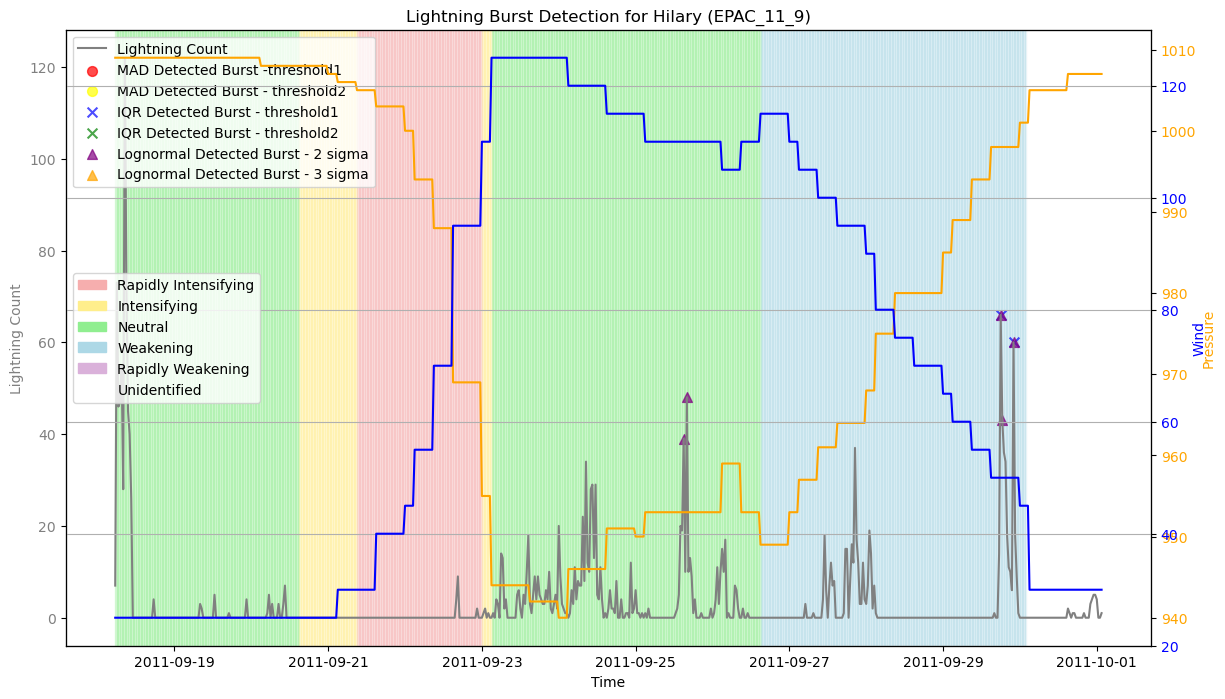

<Figure size 1000x500 with 0 Axes>

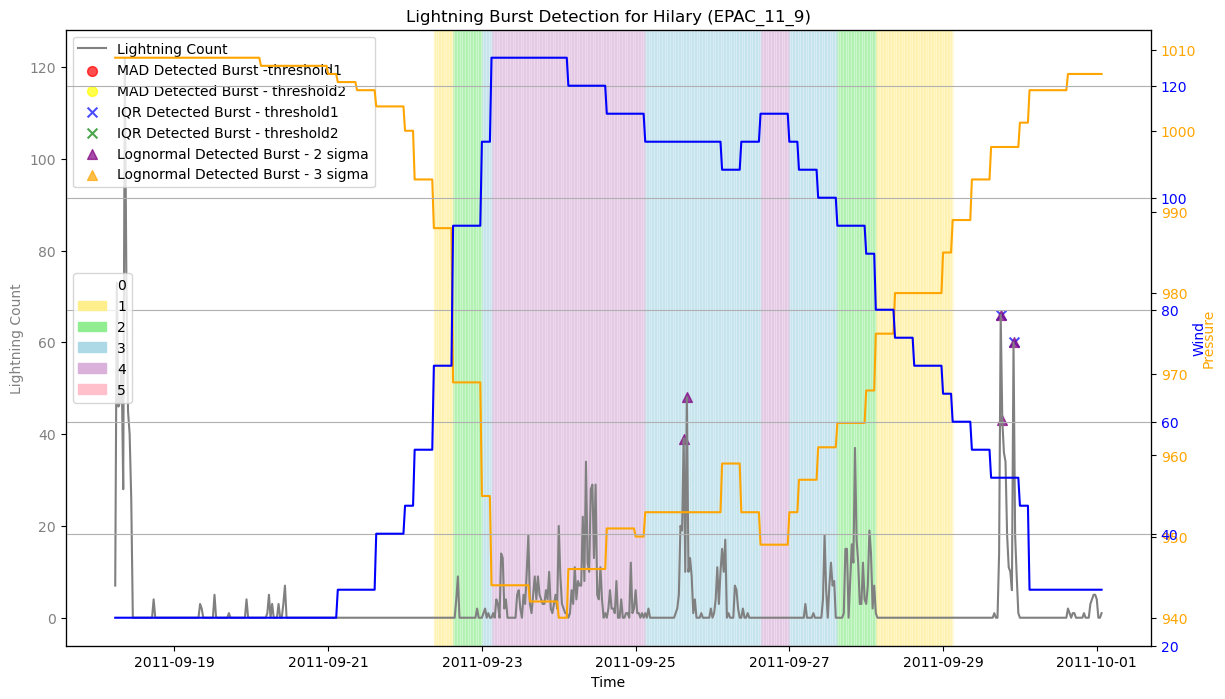

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
102  EPAC_11_9            0            0        4.564348        5.257495   

     iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
102            2            0        3.911222        4.614375             5   

     logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
102             0         3.668929         4.558539         156        0.0   

     mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
102        0.0       1.28        0.0        3.21         0.0

In [ ]:
# EPAC_11_9 - Hilary
cyclone_id = 'EPAC_11_9'
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i3")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "i5")
plot_tc_intensification(cyclone_id, processed, storm_names, innercore_data, "c5")
# Print the summary for this storm
agg_result[agg_result["storm_code"] == cyclone_id]

Apply the basin-category thresholds (mean and median based) to the basin by weak/strong category groupings. 

In [ ]:
# create threshold dictionaries to apply at basin level
epac_weak_mean_thresholds = {}
for i in range(len(epac_weak_cat_summary)):
    epac_weak_mean_thresholds[epac_weak_cat_summary["Threshold"][i]] = epac_weak_cat_summary["Basin-Category Threshold (Mean-Based)"][i]

epac_weak_median_thresholds = {}
for i in range(len(epac_weak_cat_summary)):
    epac_weak_median_thresholds[epac_weak_cat_summary["Threshold"][i]] = epac_weak_cat_summary["Basin-Category Threshold (Median-Based)"][i]

In [120]:
epac_weak_processed_mean = apply_basin_thresholds(epac_weak_cat_lightning, epac_weak_mean_thresholds)
epac_weak_agg_result_mean = create_agg_result(epac_weak_processed_mean)
epac_weak_agg_result_mean.head(10)

epac_weak_processed_median = apply_basin_thresholds(epac_weak_cat_lightning, epac_weak_median_thresholds)
epac_weak_agg_result_median = create_agg_result(epac_weak_processed_median)
epac_weak_agg_result_median.head(10)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
0   EPAC_10_4            0            0       11.014461       12.700975   
1   EPAC_10_9            0            0       11.014461       12.700975   
2   EPAC_11_1            0            0       11.014461       12.700975   
3  EPAC_11_10            0            0       11.014461       12.700975   
4  EPAC_11_11            0            0       11.014461       12.700975   
5  EPAC_11_13            0            0       11.014461       12.700975   
6   EPAC_11_2            0            0       11.014461       12.700975   
7   EPAC_11_3            0            0       11.014461       12.700975   
8   EPAC_11_4            0            0       11.014461       12.700975   
9   EPAC_11_5            0            0       11.014461       12.700975   

   iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
0            0            0        8.907842       10.635373             0   
1            0            0        8.907842       10.635373             0   
2            0            0        8.907842       10.635373             0   
3            0            0        8.907842       10.635373             0   
4            0            0        8.907842       10.635373             0   
5            0            0        8.907842       10.635373             0   
6            0            0        8.907842       10.635373             0   
7            0            0        8.907842       10.635373             0   
8            0            0        8.907842       10.635373             0   
9            0            0        8.907842       10.635373             0   

   logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0             0         7.825864         9.959551          48        0.0   
1             0         7.825864         9.959551          84        0.0   
2             0         7.825864         9.959551          33        0.0   
3             0         7.825864         9.959551         124        0.0   
4             0         7.825864         9.959551          48        0.0   
5             0         7.825864         9.959551          54        0.0   
6             0         7.825864         9.959551          47        0.0   
7             0         7.825864         9.959551          29        0.0   
8             0         7.825864         9.959551          22        0.0   
9             0         7.825864         9.959551          46        0.0   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0        0.0        0.0        0.0         0.0         0.0  
1        0.0        0.0        0.0         0.0         0.0  
2        0.0        0.0        0.0         0.0         0.0  
3        0.0        0.0        0.0         0.0         0.0  
4        0.0        0.0        0.0         0.0         0.0  
5        0.0        0.0        0.0         0.0         0.0  
6        0.0        0.0        0.0         0.0         0.0  
7        0.0        0.0        0.0         0.0         0.0  
8        0.0        0.0        0.0         0.0         0.0  
9        0.0        0.0        0.0         0.0         0.0

In [124]:
epac_basin_burst_summary_mean = create_burst_summary(epac_weak_processed_mean)
epac_basin_burst_summary_mean = epac_basin_burst_summary_mean.rename(columns={"Burst Count": "Mean-Based Threshold Bursts",
                                      "Burst Percentage":"Mean-Based Threshold Burst Percentage"})
epac_basin_burst_summary_mean

epac_basin_burst_summary_median = create_burst_summary(epac_weak_processed_median)
epac_basin_burst_summary_median = epac_basin_burst_summary_median.rename(columns={"Burst Count": "Median-Based Threshold Bursts",
                                      "Burst Percentage":"Median-Based Threshold Burst Percentage"})
epac_basin_burst_summary_median

Threshold  Median-Based Threshold Bursts  Timebin Count  \
0      mad1                              0           3850   
1      mad2                              0           3850   
2      iqr1                              0           3850   
3      iqr2                              0           3850   
4     logn1                              0           3850   
5     logn2                              0           3850   

   Median-Based Threshold Burst Percentage  
0                                      0.0  
1                                      0.0  
2                                      0.0  
3                                      0.0  
4                                      0.0  
5                                      0.0

In [128]:
epac_weak_cat_summary = pd.merge(epac_weak_cat_summary, epac_basin_burst_summary_mean[["Threshold", "Mean-Based Threshold Bursts", "Mean-Based Threshold Burst Percentage"]], on="Threshold")
epac_weak_cat_summary = pd.merge(epac_weak_cat_summary, epac_basin_burst_summary_median[["Threshold", "Median-Based Threshold Bursts", "Median-Based Threshold Burst Percentage"]], on="Threshold")
epac_weak_cat_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  6.527584  2.173121  6.668218  0.693147   
1  EPAC            0-2      mad2  7.576961  2.544147  7.612680  0.693147   
2  EPAC            0-2      iqr1  5.592081  1.602030  5.703782  0.693147   
3  EPAC            0-2      iqr2  6.660095  1.929695  6.775983  0.693147   
4  EPAC            0-2     logn1  5.233589  1.270183  5.285497  0.693147   
5  EPAC            0-2     logn2  6.606666  1.598939  6.761672  0.693147   

         Max  Basin-Category Threshold (Mean-Based)  \
0  10.962409                              10.873827   
1  12.785568                              12.665256   
2   9.045240                               8.796140   
3  10.829707                              10.519485   
4   7.998327                               7.773955   
5   9.996606                               9.804544   

   Basin-Category Threshold (Median-Based)  Burst Count  Timebin Count  \
0                                11.014461          119           3850   
1                                12.700975           40           3850   
2                                 8.907842           82           3850   
3                                10.635373           52           3850   
4                                 7.825864          141           3850   
5                                 9.959551            6           3850   

   Burst Percentage  Mean-Based Threshold Bursts  \
0              3.09                            0   
1              1.04                            0   
2              2.13                            0   
3              1.35                            0   
4              3.66                            0   
5              0.16                            0   

   Mean-Based Threshold Burst Percentage  Median-Based Threshold Bursts  \
0                                    0.0                              0   
1                                    0.0                              0   
2                                    0.0                              0   
3                                    0.0                              0   
4                                    0.0                              0   
5                                    0.0                              0   

   Median-Based Threshold Burst Percentage  
0                                      0.0  
1                                      0.0  
2                                      0.0  
3                                      0.0  
4                                      0.0  
5                                      0.0

We see that these basin-category thresholds are very high and end up flagging 0 timebins as bursts. Let's do the same for the stronger categories.

In [162]:
# create threshold dictionaries to apply at basin level
epac_weak_alt_mean_thresholds = {}
for i in range(len(epac_weak_cat_alt_summary)):
    epac_weak_alt_mean_thresholds[epac_weak_cat_alt_summary["Threshold"][i]] = epac_weak_cat_alt_summary["Basin-Category Threshold (Mean-Based)"][i]

epac_weak_alt_median_thresholds = {}
for i in range(len(epac_weak_cat_alt_summary)):
    epac_weak_alt_median_thresholds[epac_weak_cat_alt_summary["Threshold"][i]] = epac_weak_cat_alt_summary["Basin-Category Threshold (Median-Based)"][i]

In [163]:
epac_weak_alt_processed_mean = apply_basin_thresholds(epac_weak_cat_alt_lightning, epac_weak_alt_mean_thresholds)
epac_weak_alt_agg_result_mean = create_agg_result(epac_weak_alt_processed_mean)
epac_weak_alt_agg_result_mean.head(10)

epac_weak_alt_processed_median = apply_basin_thresholds(epac_weak_cat_alt_lightning, epac_weak_alt_median_thresholds)
epac_weak_alt_agg_result_median = create_agg_result(epac_weak_alt_processed_median)
epac_weak_alt_agg_result_median.head(10)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
0   EPAC_10_4            0            0       10.394819       12.091953   
1   EPAC_10_9            0            0       10.394819       12.091953   
2   EPAC_11_1            0            0       10.394819       12.091953   
3  EPAC_11_10            0            0       10.394819       12.091953   
4  EPAC_11_11            0            0       10.394819       12.091953   
5  EPAC_11_13            0            0       10.394819       12.091953   
6   EPAC_11_2            0            0       10.394819       12.091953   
7   EPAC_11_3            0            0       10.394819       12.091953   
8   EPAC_11_4            0            0       10.394819       12.091953   
9   EPAC_11_5            0            0       10.394819       12.091953   

   iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
0            0            0        8.349279       10.034941             0   
1            0            0        8.349279       10.034941             0   
2            0            0        8.349279       10.034941             0   
3            0            0        8.349279       10.034941             0   
4            0            0        8.349279       10.034941             0   
5            0            0        8.349279       10.034941             0   
6            0            0        8.349279       10.034941             0   
7            0            0        8.349279       10.034941             0   
8            0            0        8.349279       10.034941             0   
9            0            0        8.349279       10.034941             0   

   logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0             0         7.479467         9.405154          43        0.0   
1             0         7.479467         9.405154          38        0.0   
2             0         7.479467         9.405154          18        0.0   
3             0         7.479467         9.405154          53        0.0   
4             0         7.479467         9.405154          12        0.0   
5             0         7.479467         9.405154          10        0.0   
6             0         7.479467         9.405154          17        0.0   
7             0         7.479467         9.405154          13        0.0   
8             0         7.479467         9.405154          11        0.0   
9             0         7.479467         9.405154          19        0.0   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0        0.0        0.0        0.0         0.0         0.0  
1        0.0        0.0        0.0         0.0         0.0  
2        0.0        0.0        0.0         0.0         0.0  
3        0.0        0.0        0.0         0.0         0.0  
4        0.0        0.0        0.0         0.0         0.0  
5        0.0        0.0        0.0         0.0         0.0  
6        0.0        0.0        0.0         0.0         0.0  
7        0.0        0.0        0.0         0.0         0.0  
8        0.0        0.0        0.0         0.0         0.0  
9        0.0        0.0        0.0         0.0         0.0

In [164]:
epac_basin_burst_summary_mean = create_burst_summary(epac_weak_alt_processed_mean)
epac_basin_burst_summary_mean = epac_basin_burst_summary_mean.rename(columns={"Burst Count": "Mean-Based Threshold Bursts",
                                      "Burst Percentage":"Mean-Based Threshold Burst Percentage"})
epac_basin_burst_summary_mean

epac_basin_burst_summary_median = create_burst_summary(epac_weak_alt_processed_median)
epac_basin_burst_summary_median = epac_basin_burst_summary_median.rename(columns={"Burst Count": "Median-Based Threshold Bursts",
                                      "Burst Percentage":"Median-Based Threshold Burst Percentage"})
epac_basin_burst_summary_median

Threshold  Median-Based Threshold Bursts  Timebin Count  \
0      mad1                              0           1561   
1      mad2                              0           1561   
2      iqr1                              0           1561   
3      iqr2                              0           1561   
4     logn1                              0           1561   
5     logn2                              0           1561   

   Median-Based Threshold Burst Percentage  
0                                      0.0  
1                                      0.0  
2                                      0.0  
3                                      0.0  
4                                      0.0  
5                                      0.0

In [165]:
epac_weak_cat_alt_summary = pd.merge(epac_weak_cat_alt_summary, epac_basin_burst_summary_mean[["Threshold", "Mean-Based Threshold Bursts", "Mean-Based Threshold Burst Percentage"]], on="Threshold")
epac_weak_cat_alt_summary = pd.merge(epac_weak_cat_alt_summary, epac_basin_burst_summary_median[["Threshold", "Median-Based Threshold Bursts", "Median-Based Threshold Burst Percentage"]], on="Threshold")
epac_weak_cat_alt_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            1-2      mad1  6.119381  2.165851  6.063117  0.693147   
1  EPAC            1-2      mad2  7.104991  2.543813  7.004327  0.693147   
2  EPAC            1-2      iqr1  5.246400  1.588451  5.172376  0.693147   
3  EPAC            1-2      iqr2  6.251145  1.922062  6.190817  0.693147   
4  EPAC            1-2     logn1  4.931581  1.255843  4.967780  0.693147   
5  EPAC            1-2     logn2  6.227157  1.591641  6.221871  0.693147   

         Max  Basin-Category Threshold (Mean-Based)  \
0  10.962409                              10.451083   
1  12.785568                              12.192618   
2   9.045240                               8.423303   
3  10.829707                              10.095269   
4   7.998327                               7.443267   
5   9.996606                               9.410440   

   Basin-Category Threshold (Median-Based)  Burst Count  Timebin Count  \
0                                10.394819           42           1561   
1                                12.091953           15           1561   
2                                 8.349279           34           1561   
3                                10.034941           25           1561   
4                                 7.479467           51           1561   
5                                 9.405154            2           1561   

   Burst Percentage  Mean-Based Threshold Bursts  \
0              2.69                            0   
1              0.96                            0   
2              2.18                            0   
3              1.60                            0   
4              3.27                            0   
5              0.13                            0   

   Mean-Based Threshold Burst Percentage  Median-Based Threshold Bursts  \
0                                    0.0                              0   
1                                    0.0                              0   
2                                    0.0                              0   
3                                    0.0                              0   
4                                    0.0                              0   
5                                    0.0                              0   

   Median-Based Threshold Burst Percentage  
0                                      0.0  
1                                      0.0  
2                                      0.0  
3                                      0.0  
4                                      0.0  
5                                      0.0

Let's do the same for the 3-5 category group.

In [129]:
# create threshold dictionaries to apply at basin level
epac_strong_mean_thresholds = {}
for i in range(len(epac_strong_cat_summary)):
    epac_strong_mean_thresholds[epac_strong_cat_summary["Threshold"][i]] = epac_strong_cat_summary["Basin-Category Threshold (Mean-Based)"][i]

epac_strong_median_thresholds = {}
for i in range(len(epac_strong_cat_summary)):
    epac_strong_median_thresholds[epac_strong_cat_summary["Threshold"][i]] = epac_strong_cat_summary["Basin-Category Threshold (Median-Based)"][i]

In [130]:
epac_strong_processed_mean = apply_basin_thresholds(epac_strong_cat_lightning, epac_strong_mean_thresholds)
epac_strong_agg_result_mean = create_agg_result(epac_strong_processed_mean)
epac_strong_agg_result_mean.head(10)

epac_strong_processed_median = apply_basin_thresholds(epac_strong_cat_lightning, epac_strong_median_thresholds)
epac_strong_agg_result_median = create_agg_result(epac_strong_processed_median)
epac_strong_agg_result_median.head(10)

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
0   EPAC_10_4            0            0        9.062898       10.492969   
1   EPAC_11_1            0            0        9.062898       10.492969   
2  EPAC_11_10            0            0        9.062898       10.492969   
3  EPAC_11_13            0            0        9.062898       10.492969   
4   EPAC_11_4            0            0        9.062898       10.492969   
5   EPAC_11_5            0            0        9.062898       10.492969   
6   EPAC_11_9            0            0        9.062898       10.492969   
7  EPAC_12_16            0            0        9.062898       10.492969   
8   EPAC_12_4            0            0        9.062898       10.492969   
9  EPAC_13_17            0            0        9.062898       10.492969   

   iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
0            0            0        7.663448        9.152255             0   
1            0            0        7.663448        9.152255             0   
2            0            0        7.663448        9.152255             0   
3            0            0        7.663448        9.152255             0   
4            0            0        7.663448        9.152255             0   
5            0            0        7.663448        9.152255             0   
6            0            0        7.663448        9.152255             0   
7            0            0        7.663448        9.152255             0   
8            0            0        7.663448        9.152255             0   
9            0            0        7.663448        9.152255             0   

   logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0             0         7.005167         8.738997          45        0.0   
1             0         7.005167         8.738997          16        0.0   
2             0         7.005167         8.738997          21        0.0   
3             0         7.005167         8.738997          27        0.0   
4             0         7.005167         8.738997          10        0.0   
5             0         7.005167         8.738997           4        0.0   
6             0         7.005167         8.738997         119        0.0   
7             0         7.005167         8.738997           1        0.0   
8             0         7.005167         8.738997           1        0.0   
9             0         7.005167         8.738997          20        0.0   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0        0.0        0.0        0.0         0.0         0.0  
1        0.0        0.0        0.0         0.0         0.0  
2        0.0        0.0        0.0         0.0         0.0  
3        0.0        0.0        0.0         0.0         0.0  
4        0.0        0.0        0.0         0.0         0.0  
5        0.0        0.0        0.0         0.0         0.0  
6        0.0        0.0        0.0         0.0         0.0  
7        0.0        0.0        0.0         0.0         0.0  
8        0.0        0.0        0.0         0.0         0.0  
9        0.0        0.0        0.0         0.0         0.0

In [131]:
epac_basin_burst_summary_mean = create_burst_summary(epac_weak_processed_mean)
epac_basin_burst_summary_mean = epac_basin_burst_summary_mean.rename(columns={"Burst Count": "Mean-Based Threshold Bursts",
                                      "Burst Percentage":"Mean-Based Threshold Burst Percentage"})
epac_basin_burst_summary_mean

epac_basin_burst_summary_median = create_burst_summary(epac_weak_processed_median)
epac_basin_burst_summary_median = epac_basin_burst_summary_median.rename(columns={"Burst Count": "Median-Based Threshold Bursts",
                                      "Burst Percentage":"Median-Based Threshold Burst Percentage"})
epac_basin_burst_summary_median

Threshold  Median-Based Threshold Bursts  Timebin Count  \
0      mad1                              0           3850   
1      mad2                              0           3850   
2      iqr1                              0           3850   
3      iqr2                              0           3850   
4     logn1                              0           3850   
5     logn2                              0           3850   

   Median-Based Threshold Burst Percentage  
0                                      0.0  
1                                      0.0  
2                                      0.0  
3                                      0.0  
4                                      0.0  
5                                      0.0

In [132]:
epac_strong_cat_summary = pd.merge(epac_strong_cat_summary, epac_basin_burst_summary_mean[["Threshold", "Mean-Based Threshold Bursts", "Mean-Based Threshold Burst Percentage"]], on="Threshold")
epac_strong_cat_summary = pd.merge(epac_strong_cat_summary, epac_basin_burst_summary_median[["Threshold", "Median-Based Threshold Bursts", "Median-Based Threshold Burst Percentage"]], on="Threshold")
epac_strong_cat_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            3-5      mad1  5.719598  1.635318  5.792262  0.693147   
1  EPAC            3-5      mad2  6.603652  1.907559  6.677852  0.693147   
2  EPAC            3-5      iqr1  4.990127  1.245536  5.172376  0.693147   
3  EPAC            3-5      iqr2  5.898325  1.480719  6.190817  0.693147   
4  EPAC            3-5     logn1  4.755955  0.985998  5.033171  0.693147   
5  EPAC            3-5     logn2  5.963515  1.226997  6.285003  0.693147   

         Max  Basin-Category Threshold (Mean-Based)  \
0  10.223271                               8.990233   
1  11.946037                              10.418769   
2   8.230524                               7.481199   
3   9.885795                               8.859763   
4   6.999298                               6.727951   
5   8.822181                               8.417509   

   Basin-Category Threshold (Median-Based)  Burst Count  Timebin Count  \
0                                 9.062898           13           1398   
1                                10.492969            0           1398   
2                                 7.663448           11           1398   
3                                 9.152255            1           1398   
4                                 7.005167           16           1398   
5                                 8.738997            0           1398   

   Burst Percentage  Mean-Based Threshold Bursts  \
0              0.93                            0   
1              0.00                            0   
2              0.79                            0   
3              0.07                            0   
4              1.14                            0   
5              0.00                            0   

   Mean-Based Threshold Burst Percentage  Median-Based Threshold Bursts  \
0                                    0.0                              0   
1                                    0.0                              0   
2                                    0.0                              0   
3                                    0.0                              0   
4                                    0.0                              0   
5                                    0.0                              0   

   Median-Based Threshold Burst Percentage  
0                                      0.0  
1                                      0.0  
2                                      0.0  
3                                      0.0  
4                                      0.0  
5                                      0.0

Once again, we see no bursts using the basin-category thresholds (2 standard deviations from mean/median).

Let's look at the distribution of "effective" thresholds - ones where at least one timebin was flagged as a burst.

In [ ]:
burst_columns = ['burst_iqr1', 'burst_iqr2', 'burst_mad1', 'burst_mad2', 'burst_logn1', 'burst_logn2']
# Filter data to only those with at least one "True" value in the burst columns, grouped by storm code
# Do not include thresholds that don't flag a burst

mask = epac_processed.groupby("storm_code")[burst_columns].transform(lambda group: group.any(axis=0))

# Filter rows to where at least one burst col has True value
epac_processed_effective = epac_processed[epac_processed[burst_columns].any(axis=1)].copy()

# Set threshold values to NaN where burst columns are False
for burst_col, threshold_col in zip(burst_columns, threshold_cols):
    epac_processed_effective[threshold_col] = epac_processed_effective[threshold_col].where(epac_processed_effective[burst_col], np.nan)

epac_storm_codes_effective = epac_processed_effective["storm_code"].unique()
epac_agg_result_effective = epac_agg_result[epac_agg_result["storm_code"].isin(epac_storm_codes_effective)]

epac_processed_effective.head()

time_bin storm_code  lightning_count  year  month  day  hour  \
10077 2010-06-22 07:30:00  EPAC_10_4              122  2010      6   22     7   
10097 2010-06-24 07:30:00  EPAC_10_4              135  2010      6   24     7   
10148 2010-08-24 03:00:00  EPAC_10_9              136  2010      8   24     3   
10155 2010-08-24 12:30:00  EPAC_10_9              138  2010      8   24    12   
10192 2010-08-25 14:30:00  EPAC_10_9              194  2010      8   25    14   

       minute   lat    lon  ...  iqr1_threshold  iqr2_threshold burst_mad1  \
10077      30  11.6 -104.3  ...             NaN             NaN      False   
10097      30  12.3 -112.2  ...             NaN             NaN      False   
10148       0  15.2 -100.5  ...             NaN             NaN      False   
10155      30  15.4 -101.1  ...             NaN             NaN      False   
10192      30  16.5 -104.6  ...             NaN             NaN      False   

       burst_mad2 mad1_threshold  mad2_threshold  burst_logn1  burst_logn2  \
10077       False            NaN             NaN         True        False   
10097       False            NaN             NaN         True        False   
10148       False       6.063117             NaN         True        False   
10155       False       6.063117             NaN         True        False   
10192       False       6.063117             NaN         True        False   

      logn1_threshold logn2_threshold  
10077        4.679426             NaN  
10097        4.679426             NaN  
10148        4.643800             NaN  
10155        4.643800             NaN  
10192        4.643800             NaN  

[5 rows x 34 columns]

In [192]:
epac_agg_result_effective.head()

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
91   EPAC_10_4            0            0        6.704246        7.893830   
92   EPAC_10_9            0            0        6.063117        7.111688   
93   EPAC_11_1            1            0        2.720473        3.125938   
96  EPAC_11_13            0            0        8.014107        9.295041   
97   EPAC_11_2            1            0        5.723757        6.668218   

    iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
91            0            0        5.172376        6.190817             2   
92            3            0        4.810531        5.763852             3   
93            7            6        2.079442        2.426015             4   
96            0            0        7.162914        8.505703             1   
97            1            0        5.493061        6.591674             3   

    logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
91             0         4.679426         5.944917          93       0.00   
92             0         4.643800         5.918609          84       0.00   
93             0         2.502932         3.150601          49       2.04   
96             0         6.578627         8.297217          81       0.00   
97             0         5.285497         6.781191          47       2.13   

    mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
91        0.0       0.00       0.00        2.15         0.0  
92        0.0       3.57       0.00        3.57         0.0  
93        0.0      14.29      12.24        8.16         0.0  
96        0.0       0.00       0.00        1.23         0.0  
97        0.0       2.13       0.00        6.38         0.0

In [189]:
print(f"{len(epac_storm_codes_effective)} TCs of {len(epac_storm_codes)} EPAC TCs after filtering for bursts of any type")

59 TCs of 82 EPAC TCs after filtering for bursts of any type


In [190]:
epac_effective_summary = create_basin_summary(epac_processed_effective, "all", "EPAC")
epac_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            all      mad1  4.570221  1.662344  4.270455  0.693147   
1  EPAC            all      mad2  3.907350  1.387424  3.125938  0.693147   
2  EPAC            all      iqr1  3.643620  0.960844  3.701302  1.386294   
3  EPAC            all      iqr2  3.946447  0.905727  4.453341  1.559581   
4  EPAC            all     logn1  4.624058  1.029793  4.560759  2.343750   
5  EPAC            all     logn2  5.006578  0.901697  5.368579  3.436726   

        Max  Basin-Category Threshold (Mean-Based)  \
0  8.258979                               7.894910   
1  8.132119                               6.682197   
2  6.191953                               5.565309   
3  5.891751                               5.757900   
4  6.767766                               6.683645   
5  5.986970                               6.809973   

   Basin-Category Threshold (Median-Based)  Burst Count  Timebin Count  \
0                                 7.595143          132            204   
1                                 5.900785           40            204   
2                                 5.622991           93            204   
3                                 6.264794           53            204   
4                                 6.620345          157            204   
5                                 7.171973            6            204   

   Burst Percentage  
0             64.71  
1             19.61  
2             45.59  
3             25.98  
4             76.96  
5              2.94

In this context, the burst percentage represents how much of the total number of flagged bursts (across all threshold types) the particular threshold type flagged. For example, 204 timebins means there are 204 total bursts across all TCs in the EPAC basin and across all 6 threshold types. Of these, 64.71% were flagged by the MAD method, specifically the first threshold value (the lower one). It can be noted that the burst percentages do not add up to 100% due to the fact that multiple thresholds will flag the same burst.

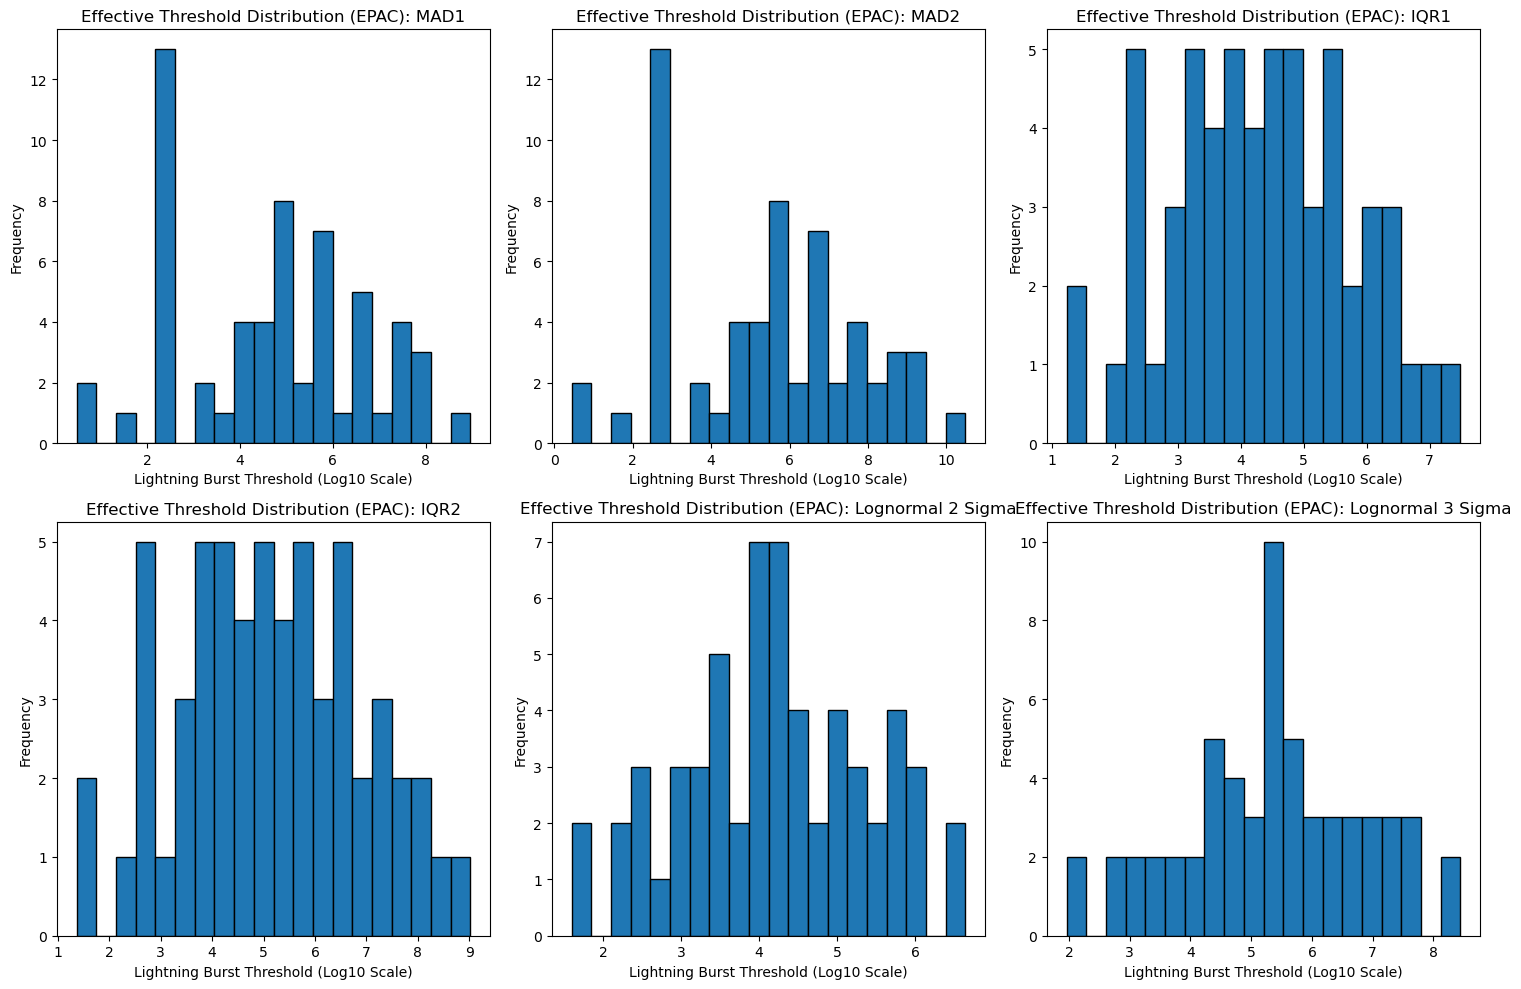

In [231]:
# Unweighted threshold distribution (1 occurence per TC)
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_agg_result_effective, threshold, ax=axes[i])
    axes[i].set_title(f"Effective Threshold Distribution (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [202]:
# Group the data into weak and strong category datasets using function
epac_weak_effective_lightning, epac_weak_alt_effective_lightning, epac_strong_effective_lightning = group_bins_category(epac_processed_effective)

181 non-zero lightning count timebins associated with category 0-2 wind speeds in EPAC basin.
68 non-zero lightning count timebins associated with category 1-2 wind speeds in EPAC basin.
23 non-zero lightning count timebins associated with category 3-5 wind speeds in EPAC basin.


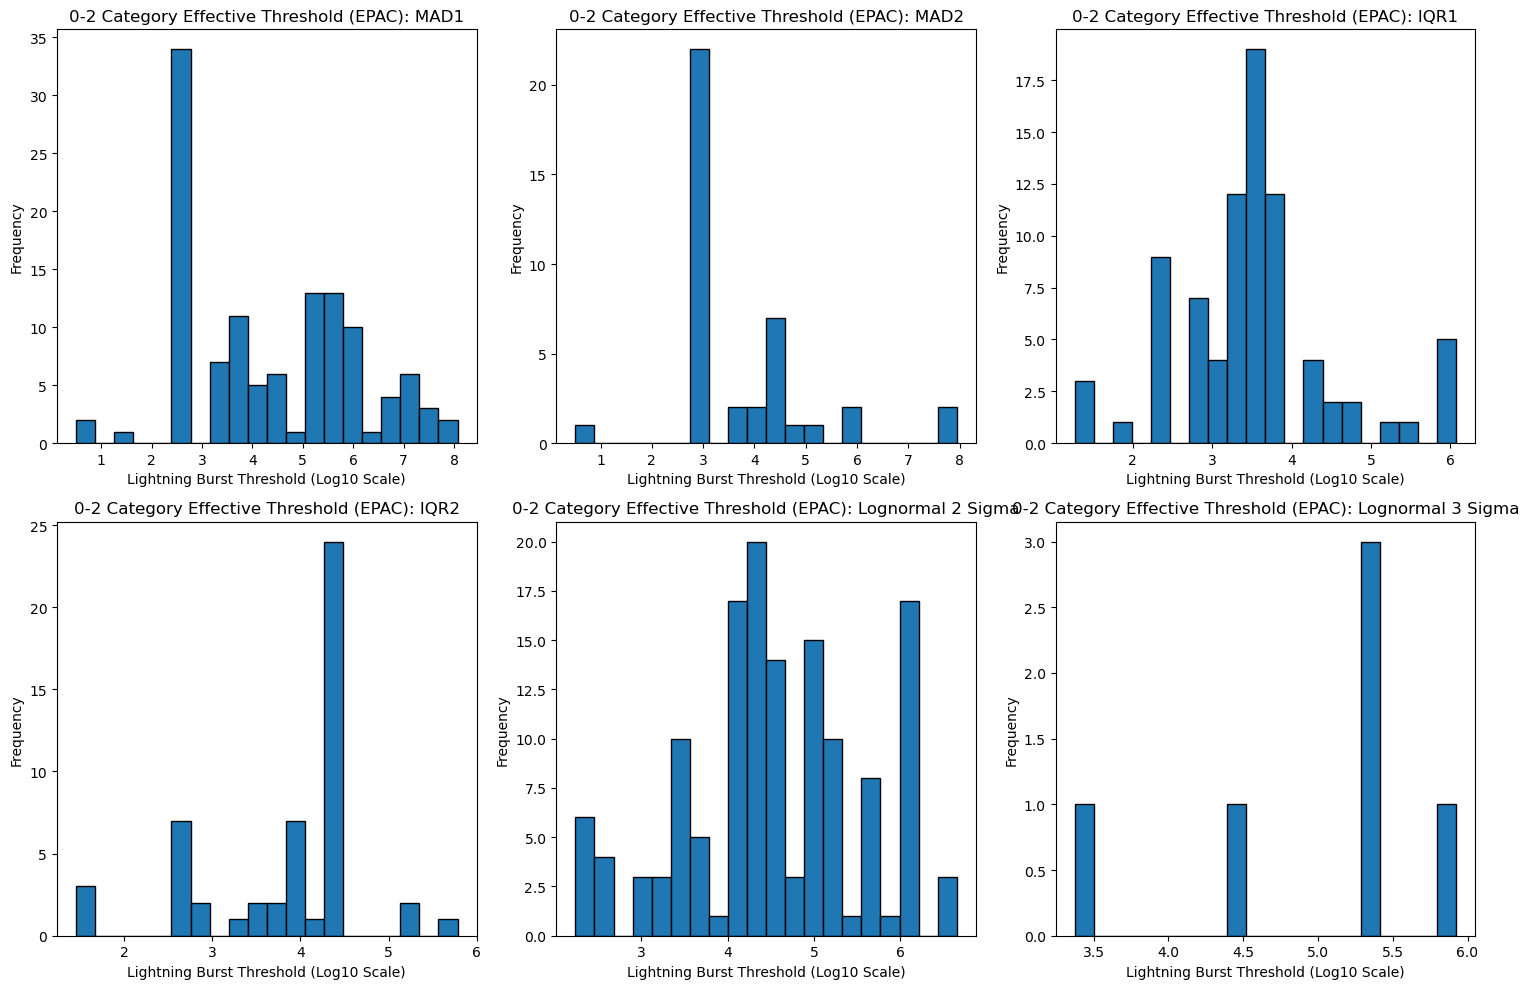

In [194]:
# Plot threshold value distributions for 0-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_weak_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"0-2 Category Effective Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [201]:
# Get mean and 2 standard dev - 0-2 categories
epac_weak_effective_summary = create_basin_summary(epac_weak_effective_lightning, "0-2", "EPAC")
epac_weak_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  4.557847  1.722731  4.382027  0.693147   
1  EPAC            0-2      mad2  3.907350  1.387424  3.125938  0.693147   
2  EPAC            0-2      iqr1  3.642842  0.994310  3.701302  1.386294   
3  EPAC            0-2      iqr2  3.967640  0.901196  4.453341  1.559581   
4  EPAC            0-2     logn1  4.649019  1.041497  4.560759  2.343750   
5  EPAC            0-2     logn2  5.006578  0.901697  5.368579  3.436726   

        Max  Basin-Category Threshold (Mean-Based)  \
0  8.258979                               8.003309   
1  8.132119                               6.682197   
2  6.191953                               5.631462   
3  5.891751                               5.770032   
4  6.767766                               6.732013   
5  5.986970                               6.809973   

   Basin-Category Threshold (Median-Based)  Burst Count  Timebin Count  \
0                                 7.827488          119            181   
1                                 5.900785           40            181   
2                                 5.689922           82            181   
3                                 6.255733           52            181   
4                                 6.643753          141            181   
5                                 7.171973            6            181   

   Burst Percentage  
0             65.75  
1             22.10  
2             45.30  
3             28.73  
4             77.90  
5              3.31

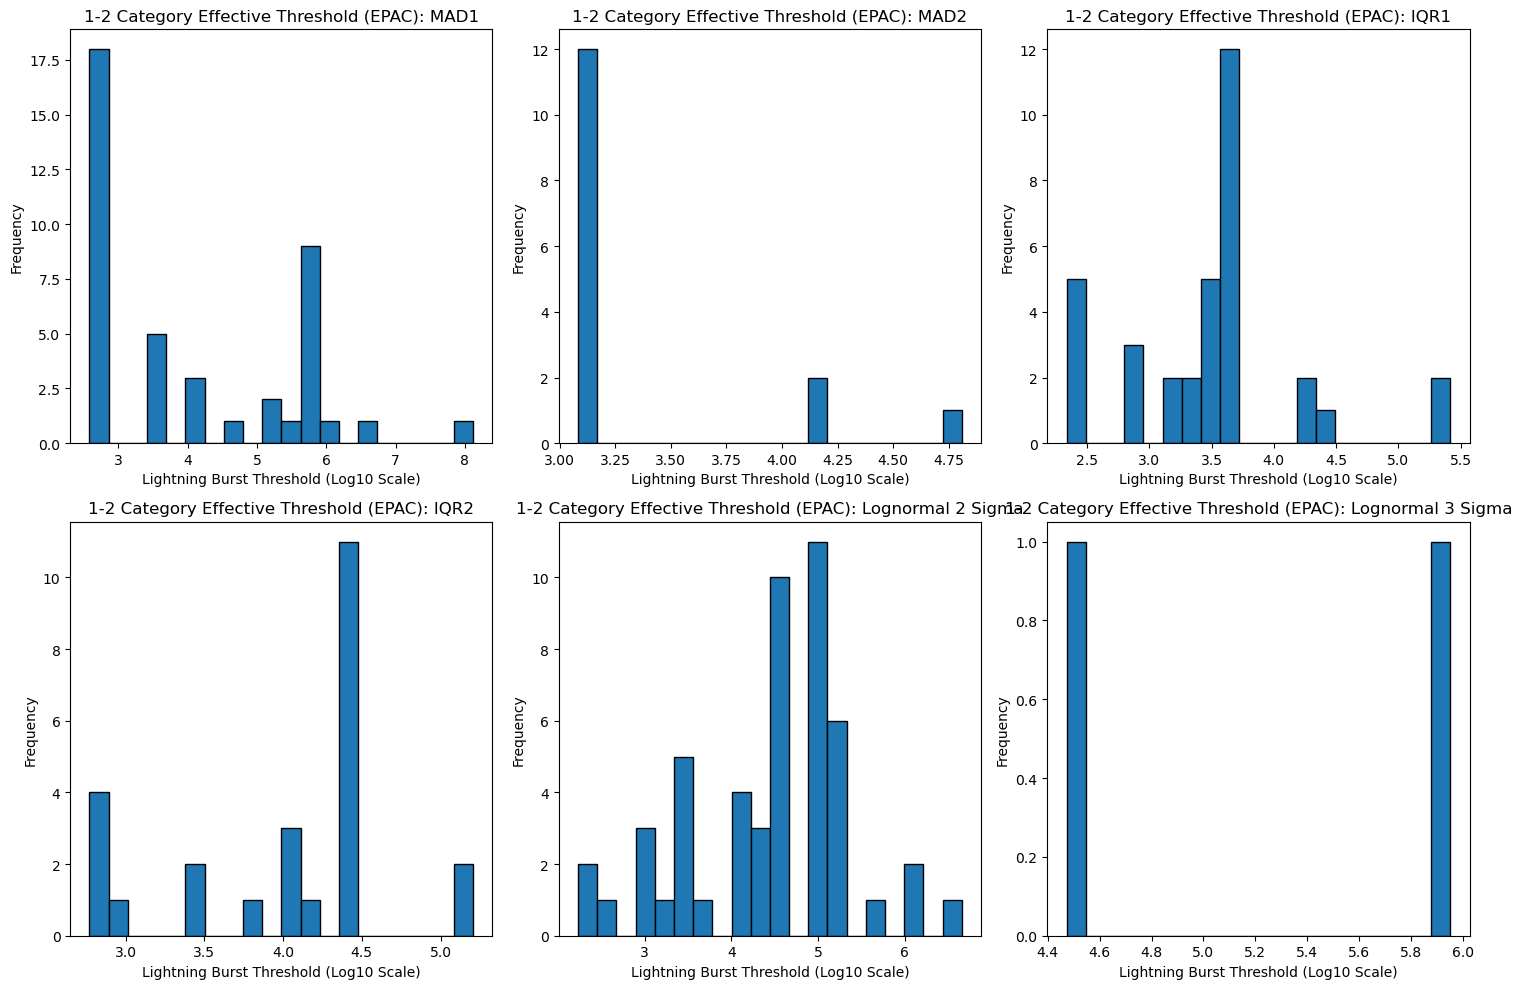

In [203]:
# Plot threshold value distributions for 1-2 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_weak_alt_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"1-2 Category Effective Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [204]:
# Get mean and 2 standard dev - 1-2 categories
epac_weak_alt_effective_summary = create_basin_summary(epac_weak_alt_effective_lightning, "0-2", "EPAC")
epac_weak_alt_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            0-2      mad1  4.162957  1.547052  3.652740  2.720473   
1  EPAC            0-2      mad2  3.379361  0.545723  3.125938  3.125938   
2  EPAC            0-2      iqr1  3.545660  0.716110  3.612965  2.414157   
3  EPAC            0-2      iqr2  4.055095  0.717920  4.453341  2.831480   
4  EPAC            0-2     logn1  4.525435  0.957033  4.560759  2.343750   
5  EPAC            0-2     logn2  5.248504  1.044348  5.248504  4.510039   

        Max  Basin-Category Threshold (Mean-Based)  \
0  8.258979                               7.257060   
1  4.852030                               4.470807   
2  5.493061                               4.977881   
3  5.268244                               5.490936   
4  6.767766                               6.439500   
5  5.986970                               7.337200   

   Basin-Category Threshold (Median-Based)  Burst Count  Timebin Count  \
0                                 6.746844           42             68   
1                                 4.217384           15             68   
2                                 5.045186           34             68   
3                                 5.889181           25             68   
4                                 6.474824           51             68   
5                                 7.337200            2             68   

   Burst Percentage  
0             61.76  
1             22.06  
2             50.00  
3             36.76  
4             75.00  
5              2.94

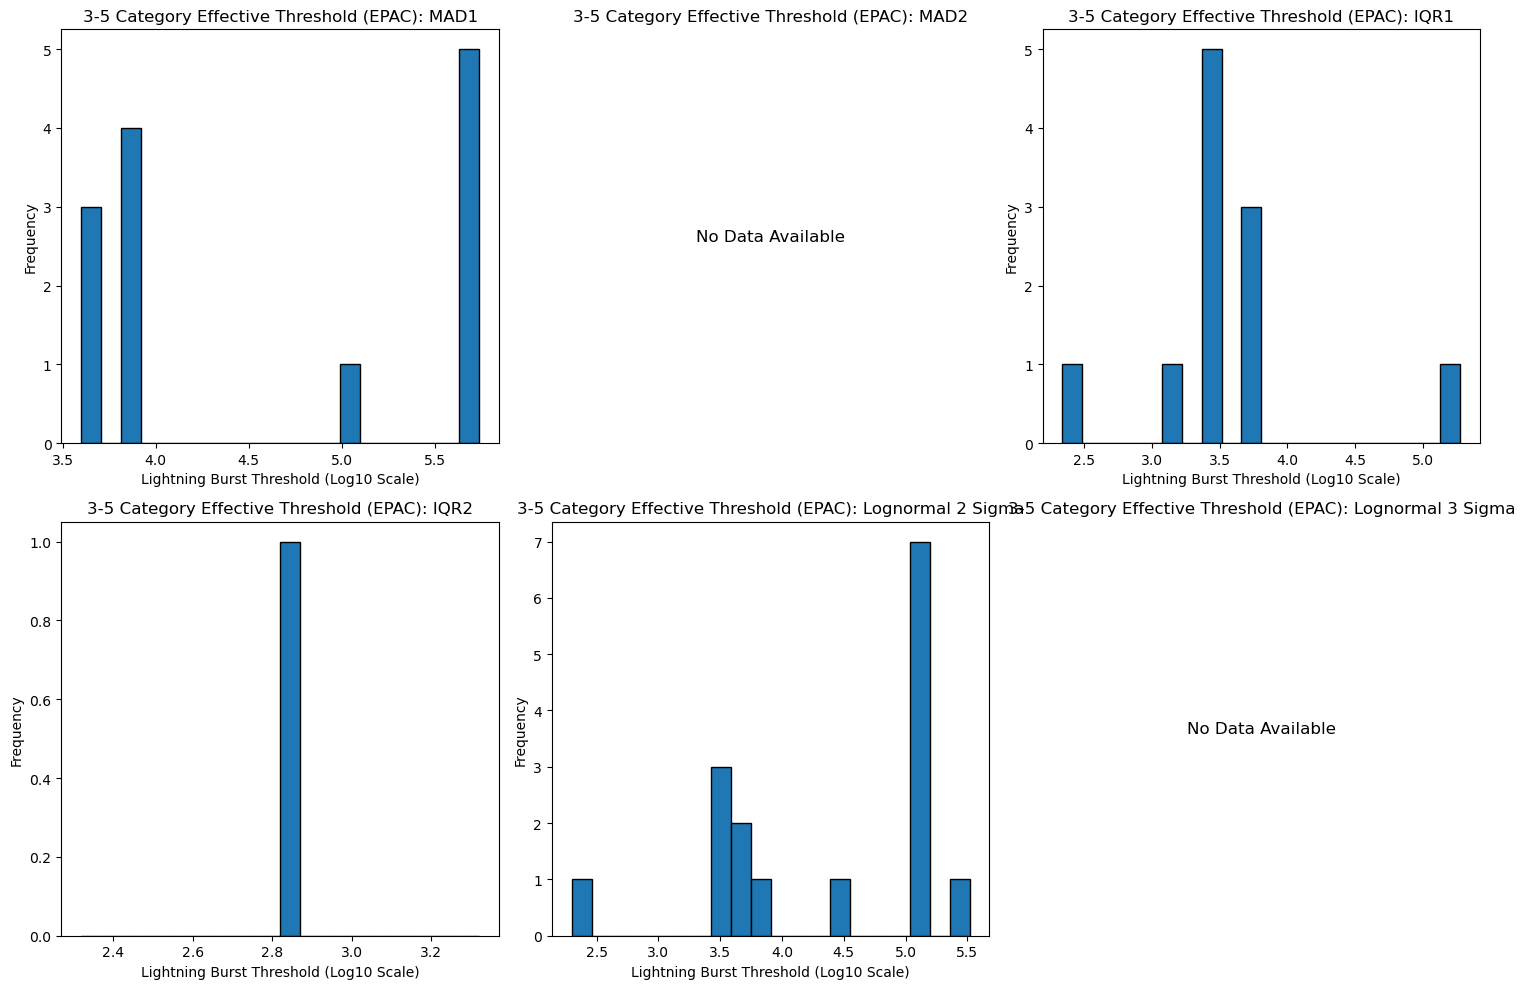

In [228]:
# Plot threshold value distributions for 3-5 category bins
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, threshold in enumerate(threshold_names):
    plt.sca(axes[i])  # Set current axis
    plot_threshold_histogram(epac_strong_effective_lightning, threshold, ax=axes[i])
    axes[i].set_title(f"3-5 Category Effective Threshold (EPAC): {threshold_names[threshold][1]}")  # Add a title for each plot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [219]:
# Get mean and 2 standard dev - 3-5 categories
epac_strong_effective_summary = create_basin_summary(epac_strong_effective_lightning, "3-5", "EPAC")
epac_strong_effective_summary

Basin Category Group Threshold      Mean   Std Dev    Median       Min  \
0  EPAC            3-5      mad1  4.683494  0.983965  3.960585  3.652740   
1  EPAC            3-5      mad2       NaN       NaN       NaN       NaN   
2  EPAC            3-5      iqr1  3.649424  0.696790  3.524627  2.414157   
3  EPAC            3-5      iqr2  2.844409       NaN  2.844409  2.844409   
4  EPAC            3-5     logn1  4.404095  0.920568  4.816549  2.379402   
5  EPAC            3-5     logn2       NaN       NaN       NaN       NaN   

        Max  Basin-Category Threshold (Mean-Based)  \
0  5.792262                               6.651423   
1       NaN                                    NaN   
2  5.348297                               5.043004   
3  2.844409                                    NaN   
4  5.598135                               6.245231   
5       NaN                                    NaN   

   Basin-Category Threshold (Median-Based)  Burst Count  Timebin Count  \
0                                 5.928514           13             23   
1                                      NaN            0             23   
2                                 4.918208           11             23   
3                                      NaN            1             23   
4                                 6.657686           16             23   
5                                      NaN            0             23   

   Burst Percentage  
0             56.52  
1              0.00  
2             47.83  
3              4.35  
4             69.57  
5              0.00

In [ ]:
# apply basin effective threshold

---------------------

### ATL Basin